# Beach Crowd Prediction — 3-Dataset Comparison

Compare model performance across three dataset strategies:
1. **Daytime only** — remove night hours, sklearn models only
2. **Full 24h** — keep all data including noisy night counts  
3. **Night = 0** — keep 24h but replace night counts with 0

Models with `stat_exog_list` (NBEATSx, NHITS, TFT, TiDE, BiTCN) can use beach metadata for zero-shot prediction on new beaches.

In [1]:
# === PATHS ===
CACHE_DIR = "cache/predictions"
COUNTING_MODEL = "bayesian_vgg19"
SAVE_DIR = "models/dataset_comparison"

# === SAMPLING (for quick testing) ===
SAMPLE_FRAC = 1.0
MAX_BEACHES = None

# === MODEL PARAMETERS ===
MAX_STEPS = 500
EARLY_STOP_PATIENCE = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
INPUT_SIZE = 24

# === TIME ===
NIGHT_START = 20
NIGHT_END = 6

# === FLAGS ===
RUN_SKLEARN = True
RUN_NEURALFORECAST = True

In [2]:
import subprocess, sys
for pkg in ["neuralforecast", "xgboost", "lightgbm", "catboost", "utilsforecast"]:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])
print("Packages installed")

Packages installed


In [3]:
import json, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso

import torch
warnings.filterwarnings('ignore')

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except: HAS_XGB = False

try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except: HAS_LGBM = False

try:
    from catboost import CatBoostRegressor
    HAS_CATBOOST = True
except: HAS_CATBOOST = False

try:
    from neuralforecast import NeuralForecast
    from neuralforecast.models import NBEATSx, NHITS, TFT, TiDE, BiTCN
    HAS_NF = True
except Exception as e:
    print(f"NeuralForecast error: {e}")
    HAS_NF = False

if torch.cuda.is_available():
    accelerator = 'gpu'
elif torch.backends.mps.is_available():
    accelerator = 'mps'
else:
    accelerator = 'cpu'

print(f"Accelerator: {accelerator}")
print(f"XGB: {HAS_XGB}, LGBM: {HAS_LGBM}, CatBoost: {HAS_CATBOOST}, NF: {HAS_NF}")

2026-02-08 17:24:38,481	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


2026-02-08 17:24:38,626	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Accelerator: gpu
XGB: True, LGBM: True, CatBoost: True, NF: True


In [4]:
def calc_metrics(y_true, y_pred, max_count):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    rel_mae = (mae / max_count) * 100 if max_count > 0 else 0
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'RelMAE': rel_mae}

def eval_per_beach(df, y_pred, beach_col='unique_id'):
    results = []
    for b in df[beach_col].unique():
        mask = df[beach_col] == b
        if mask.sum() < 3:
            continue
        y_true = df.loc[mask, 'y'].values if 'y' in df.columns else df.loc[mask, 'count'].values
        y_p = y_pred[mask.values]
        max_count = y_true.max()
        m = calc_metrics(y_true, y_p, max_count)
        m['camera'] = b
        m['max_count'] = max_count
        m['n'] = mask.sum()
        results.append(m)
    return pd.DataFrame(results)

In [5]:
def load_cache(cache_dir, model):
    cache_path = Path(cache_dir) / model
    records = []
    for jf in cache_path.rglob("*.json"):
        try:
            with open(jf) as f:
                r = json.load(f)
            if 'error' not in r:
                records.append(r)
        except: pass
    
    rows = []
    for r in records:
        row = {
            'beach': r.get('beach') or r.get('beach_folder'),
            'beach_folder': r.get('beach_folder'),
            'datetime': r.get('datetime'),
            'count': r.get('count')
        }
        for k, v in r.get('weather', {}).items():
            row[k] = v
        rows.append(row)
    
    df = pd.DataFrame(rows)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    return df

df_raw = load_cache(CACHE_DIR, COUNTING_MODEL)
print(f"Loaded: {len(df_raw)} rows, {df_raw['beach'].nunique()} beaches")
print(f"Date range: {df_raw['datetime'].min()} to {df_raw['datetime'].max()}")



Loaded: 169241 rows, 41 beaches
Date range: 1970-01-01 01:00:00 to 2023-01-27 08:00:00


In [6]:
print(df_raw.head())

                                       beach    beach_folder  \
0                                Camp de Mar  livecampro/070   
1                               Port Andratx  livecampro/001   
2  Platja d'or (Can Pastilla, desde BonaOna)  livecampro/043   
3                                Can Barbarà  livecampro/039   
4                          Portocolom Llotja  livecampro/021   

             datetime      count  ae_ta  ae_hr  ae_prec  ae_vv  ae_dv  \
0 1970-01-01 01:00:00  29.308895    NaN    NaN      NaN    NaN    NaN   
1 1970-01-01 01:00:00  13.774030    NaN    NaN      NaN    NaN    NaN   
2 1970-01-01 01:00:00  75.135834    NaN    NaN      NaN    NaN    NaN   
3 1970-01-01 01:00:00  18.020220    NaN    NaN      NaN    NaN    NaN   
4 1970-01-01 01:00:00  37.578743    NaN    NaN      NaN    NaN    NaN   

   ae_pres  ...  om_wind_direction_10m  om_wind_gusts_10m  om_cloud_cover  \
0      NaN  ...               262.0000            42.7333         70.6667   
1      NaN  ...       

In [7]:
EXCLUDE = ['livecampro/001', 'livecampro/011', 'livecampro/018', 'livecampro/021',
    'livecampro/030', 'livecampro/039', 'livecampro/070', 'MultimediaTres/PortAndratx',
    'SeeTheWorld/mallorca_pancam', 'skyline/es-pujols']
EXCLUDE_PREFIX = ['ibred', 'ClubNauticSoller', 'Guenthoer', 'youtube']

before = len(df_raw)
df_raw = df_raw[~df_raw['beach_folder'].isin(EXCLUDE)]
for p in EXCLUDE_PREFIX:
    df_raw = df_raw[~df_raw['beach_folder'].str.startswith(p, na=False)]
print(f"Filtered: {before} -> {len(df_raw)}")

Filtered: 169241 -> 70501


In [8]:
if SAMPLE_FRAC < 1.0:
    df_raw = df_raw.sample(frac=SAMPLE_FRAC, random_state=42).sort_values('datetime').reset_index(drop=True)
    print(f"Sampled to {len(df_raw)}")

if MAX_BEACHES:
    top = df_raw['beach'].value_counts().head(MAX_BEACHES).index.tolist()
    df_raw = df_raw[df_raw['beach'].isin(top)].reset_index(drop=True)
    print(f"Limited to {MAX_BEACHES} beaches: {len(df_raw)} rows")

print(f"Final: {len(df_raw)} rows, {df_raw['beach'].nunique()} beaches")

Final: 70501 rows, 14 beaches


In [9]:
df = df_raw.copy()
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_night'] = ((df['hour'] >= NIGHT_START) | (df['hour'] <= NIGHT_END)).astype(int)

WEATHER_COLS = [c for c in df.columns if c.startswith('ae_') or c.startswith('om_')]
TEMPORAL_COLS = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_summer', 'is_night']
ALL_FEATURES = WEATHER_COLS + TEMPORAL_COLS

df = df.dropna(subset=ALL_FEATURES + ['count']).reset_index(drop=True)
good = df.groupby('beach')['count'].max()
good = good[good > 20].index.tolist()
df = df[df['beach'].isin(good)].reset_index(drop=True)

print(f"After cleaning: {len(df)} rows, {len(good)} beaches")
print(f"Features: {len(ALL_FEATURES)}")

After cleaning: 70090 rows, 14 beaches
Features: 35


In [10]:
ds_daytime = df[df['is_night'] == 0].copy().reset_index(drop=True)
ds_full24h = df.copy()
ds_night0 = df.copy()
ds_night0.loc[ds_night0['is_night'] == 1, 'count'] = 0.0

datasets = {'Daytime': ds_daytime, 'Full24h': ds_full24h, 'Night0': ds_night0}

print("="*80)
print("DATASET COMPARISON")
print("="*80)

for name, d in datasets.items():
    night_rows = d[d['is_night'] == 1] if 'is_night' in d.columns else pd.DataFrame()
    day_rows = d[d['is_night'] == 0] if 'is_night' in d.columns else d
    
    print(f"\n{name}:")
    print(f"  Total rows:     {len(d)}")
    print(f"  Beaches:        {d['beach'].nunique()}")
    print(f"  Night rows:     {len(night_rows)} ({len(night_rows)/len(d)*100:.1f}%)")
    print(f"  Day rows:       {len(day_rows)} ({len(day_rows)/len(d)*100:.1f}%)")
    print(f"  Count - mean:   {d['count'].mean():.1f}")
    print(f"  Count - median: {d['count'].median():.1f}")
    print(f"  Count - std:    {d['count'].std():.1f}")
    print(f"  Count - min:    {d['count'].min():.1f}")
    print(f"  Count - max:    {d['count'].max():.1f}")
    if len(day_rows) > 0:
        print(f"  Day mean:       {day_rows['count'].mean():.1f}")
    if len(night_rows) > 0:
        print(f"  Night mean:     {night_rows['count'].mean():.1f}")
    print(f"  Zeros:          {(d['count'] == 0).sum()} ({(d['count'] == 0).sum()/len(d)*100:.1f}%)")

DATASET COMPARISON

Daytime:
  Total rows:     37643
  Beaches:        14
  Night rows:     0 (0.0%)
  Day rows:       37643 (100.0%)
  Count - mean:   57.2
  Count - median: 28.9
  Count - std:    69.0
  Count - min:    3.9
  Count - max:    538.0
  Day mean:       57.2
  Zeros:          0 (0.0%)



Full24h:
  Total rows:     70090
  Beaches:        14
  Night rows:     32447 (46.3%)
  Day rows:       37643 (53.7%)
  Count - mean:   53.8
  Count - median: 26.9
  Count - std:    72.7
  Count - min:    3.9
  Count - max:    538.0
  Day mean:       57.2
  Night mean:     49.7
  Zeros:          0 (0.0%)



Night0:
  Total rows:     70090
  Beaches:        14
  Night rows:     32447 (46.3%)
  Day rows:       37643 (53.7%)
  Count - mean:   30.7
  Count - median: 13.5
  Count - std:    58.0
  Count - min:    0.0
  Count - max:    538.0
  Day mean:       57.2
  Night mean:     0.0
  Zeros:          32447 (46.3%)


In [11]:
print(ds_night0.head())

                                               beach  \
0              Playa de Muro (Hotel Playa Esperanza)   
1                                     Port de Soller   
2                                     Badia dAlcúdia   
3                                         Cala Major   
4  Son Serra Marina (des de El Sol Sunshine Bar &...   

                 beach_folder            datetime       count    ae_ta  \
0              livecampro/024 2022-07-14 11:00:00   24.623276  31.2852   
1  SeeTheWorld/port_de_soller 2022-07-14 11:00:00  232.566895  28.6074   
2    skyline/mallorca-alcudia 2022-07-14 11:00:00   19.267483  31.7492   
3              livecampro/002 2022-07-14 11:00:00   74.671631  29.1944   
4              livecampro/035 2022-07-14 11:00:00   24.646879  33.7048   

     ae_hr  ae_prec   ae_vv     ae_dv    ae_pres  ...  om_sunshine_duration  \
0  50.3071      0.0  2.1501   63.3246  1015.1845  ...                3600.0   
1  65.7055      0.0  2.5767   26.7109  1015.0849  ...       

In [12]:
def split_data(df, train_frac=0.7, val_frac=0.15):
    n = len(df)
    t1 = int(n * train_frac)
    t2 = int(n * (train_frac + val_frac))
    return df.iloc[:t1], df.iloc[t1:t2], df.iloc[t2:]

splits = {}
for name, d in datasets.items():
    train, val, test = split_data(d)
    splits[name] = {'train': train, 'val': val, 'test': test}
    print(f"{name}: train={len(train)}, val={len(val)}, test={len(test)}")

Daytime: train=26350, val=5646, test=5647
Full24h: train=49063, val=10513, test=10514
Night0: train=49063, val=10513, test=10514


## Sklearn Models

In [13]:
def get_sklearn_models():
    models = {
        'Lasso': Lasso(alpha=0.1),
        'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42),
    }
    if HAS_XGB:
        models['XGBoost'] = XGBRegressor(n_estimators=200, max_depth=6, random_state=42, n_jobs=-1, verbosity=0)
    if HAS_LGBM:
        models['LightGBM'] = LGBMRegressor(n_estimators=200, max_depth=6, random_state=42, n_jobs=-1, verbose=-1)
    if HAS_CATBOOST:
        models['CatBoost'] = CatBoostRegressor(n_estimators=200, max_depth=6, random_state=42, verbose=0)
    return models

print(f"Sklearn models: {list(get_sklearn_models().keys())}")

Sklearn models: ['Lasso', 'RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM', 'CatBoost']


In [14]:
all_results = []
all_beach_results = []

if RUN_SKLEARN:
    for ds_name in datasets.keys():
        s = splits[ds_name]
        X_train = pd.concat([s['train'], s['val']])[ALL_FEATURES]
        y_train = pd.concat([s['train'], s['val']])['count']
        X_test = s['test'][ALL_FEATURES]
        y_test = s['test']['count']

        print(f"\n=== SKLEARN - {ds_name} ===")
        
        for model_name, model in get_sklearn_models().items():
            t0 = time.time()
            model.fit(X_train, y_train)
            y_pred = np.clip(model.predict(X_test), 0, None)
            elapsed = time.time() - t0

            m = calc_metrics(y_test.values, y_pred, y_test.max())
            beach_df = eval_per_beach(s['test'], y_pred, 'beach')
            beach_df['model'] = model_name
            beach_df['dataset'] = ds_name
            all_beach_results.append(beach_df)

            avg_rel = beach_df['RelMAE'].mean()
            all_results.append({
                'Model': model_name, 'Dataset': ds_name, 'Type': 'Sklearn',
                'MAE': m['MAE'], 'RMSE': m['RMSE'], 'R2': m['R2'],
                'AvgRelMAE': avg_rel, 'Time': elapsed
            })
            print(f"  {model_name:20s} | {elapsed:5.1f}s | MAE={m['MAE']:.1f} | RelMAE={avg_rel:.1f}%")


=== SKLEARN - Daytime ===


  Lasso                |   1.7s | MAE=73.9 | RelMAE=182.2%


  RandomForest         |   1.9s | MAE=63.4 | RelMAE=162.8%


  GradientBoosting     |  37.6s | MAE=49.4 | RelMAE=120.9%


  XGBoost              |   0.6s | MAE=49.0 | RelMAE=116.2%


  LightGBM             |   0.8s | MAE=32.3 | RelMAE=74.1%


  CatBoost             |   0.9s | MAE=33.8 | RelMAE=74.9%

=== SKLEARN - Full24h ===


  Lasso                |   1.9s | MAE=47.3 | RelMAE=104.9%


  RandomForest         |   3.3s | MAE=29.2 | RelMAE=60.2%


  GradientBoosting     |  68.8s | MAE=41.2 | RelMAE=94.4%


  XGBoost              |   0.6s | MAE=43.9 | RelMAE=100.2%


  LightGBM             |   0.9s | MAE=31.4 | RelMAE=70.8%


  CatBoost             |   1.0s | MAE=34.2 | RelMAE=76.4%

=== SKLEARN - Night0 ===


  Lasso                |   2.1s | MAE=40.2 | RelMAE=89.7%


  RandomForest         |   2.1s | MAE=32.9 | RelMAE=83.3%


  GradientBoosting     |  63.8s | MAE=43.5 | RelMAE=103.0%


  XGBoost              |   0.6s | MAE=45.6 | RelMAE=106.9%


  LightGBM             |   1.0s | MAE=23.7 | RelMAE=55.5%


  CatBoost             |   1.0s | MAE=20.0 | RelMAE=41.8%


## NeuralForecast Models


In [15]:
import subprocess, sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "mlforecast", "optuna", "window-ops", "-q"])

from mlforecast import MLForecast
from mlforecast.auto import (
    AutoMLForecast,
    AutoLightGBM,
    AutoXGBoost,
    AutoCatboost,
    AutoRidge,
)

print("MLForecast imported successfully")

MLForecast imported successfully


In [16]:
# === PREPARE DATASETS WITH FILLED GAPS ===
# This cell creates clean, gap-filled datasets for all models (NeuralForecast, MLForecast, etc.)

from utilsforecast.preprocessing import fill_gaps

def to_nf_format(df, id_col='beach_folder'):
    cols = ['datetime', id_col, 'count'] + ALL_FEATURES
    cols = [c for c in cols if c in df.columns]
    nf_df = df[cols].copy()
    nf_df = nf_df.rename(columns={'datetime': 'ds', id_col: 'unique_id', 'count': 'y'})
    return nf_df

def prepare_dataset_with_filled_gaps(train_df, test_df, freq='h'):
    """Prepare train/test with filled gaps and interpolation"""
    
    nf_train = to_nf_format(train_df)
    nf_test = to_nf_format(test_df)
    
    print(f"  Raw: train={len(nf_train)}, test={len(nf_test)}")
    
    # Step 1: Deduplicate (multiple images per hour)
    nf_train = nf_train.groupby(['unique_id', 'ds']).mean(numeric_only=True).reset_index()
    nf_test = nf_test.groupby(['unique_id', 'ds']).mean(numeric_only=True).reset_index()
    print(f"  After dedup: train={len(nf_train)}, test={len(nf_test)}")
    
    # Step 2: Check gaps before filling
    print(f"\n  Gaps BEFORE fill_gaps:")
    for uid in nf_train['unique_id'].unique()[:3]:
        s = nf_train[nf_train['unique_id'] == uid].sort_values('ds')
        gaps = s['ds'].diff().dt.total_seconds() / 3600
        n_gaps_gt1 = (gaps > 1).sum()
        max_gap = gaps.max()
        print(f"    {uid[:40]}: {len(s)} rows, max_gap={max_gap:.0f}h, gaps>1h={n_gaps_gt1}")
    
    # Step 3: Fill gaps to create continuous hourly series
    nf_train = fill_gaps(nf_train, freq=freq)
    nf_test = fill_gaps(nf_test, freq=freq)
    print(f"\n  After fill_gaps: train={len(nf_train)}, test={len(nf_test)}")
    
    # Step 4: Check gaps after filling
    print(f"\n  Gaps AFTER fill_gaps:")
    for uid in nf_train['unique_id'].unique()[:3]:
        s = nf_train[nf_train['unique_id'] == uid].sort_values('ds')
        gaps = s['ds'].diff().dt.total_seconds() / 3600
        n_gaps_gt1 = (gaps > 1).sum()
        max_gap = gaps.max()
        nan_count = s['y'].isna().sum()
        print(f"    {uid[:40]}: {len(s)} rows, max_gap={max_gap:.0f}h, gaps>1h={n_gaps_gt1}, NaN={nan_count}")
    
    # Step 5: Interpolate NaN values (linear interpolation + ffill/bfill for edges)
    numeric_cols = nf_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c in nf_train.columns]
    
    for col in numeric_cols:
        nf_train[col] = nf_train.groupby('unique_id')[col].transform(
            lambda x: x.interpolate(method='linear').ffill().bfill()
        )
        nf_test[col] = nf_test.groupby('unique_id')[col].transform(
            lambda x: x.interpolate(method='linear').ffill().bfill()
        )
    
    print(f"\n  After interpolation:")
    print(f"    Train NaN: {nf_train['y'].isna().sum()}")
    print(f"    Test NaN: {nf_test['y'].isna().sum()}")
    
    # Step 6: Keep only series present in both train and test
    common_ids = set(nf_train['unique_id'].unique()) & set(nf_test['unique_id'].unique())
    nf_train = nf_train[nf_train['unique_id'].isin(common_ids)].reset_index(drop=True)
    nf_test = nf_test[nf_test['unique_id'].isin(common_ids)].reset_index(drop=True)
    
    print(f"\n  Final: train={len(nf_train)}, test={len(nf_test)}, series={len(common_ids)}")
    
    return nf_train, nf_test, list(common_ids)

# Process all datasets
print("="*70)
print("PREPARING DATASETS WITH FILLED GAPS")
print("="*70)

prepared_data = {}

for ds_name in ['Daytime', 'Full24h', 'Night0']:
    print(f"\n{'='*70}")
    print(f"Processing: {ds_name}")
    print(f"{'='*70}")
    
    s = splits[ds_name]
    train_val = pd.concat([s['train'], s['val']])
    
    nf_train, nf_test, series_ids = prepare_dataset_with_filled_gaps(train_val, s['test'])
    
    prepared_data[ds_name] = {
        'train': nf_train,
        'test': nf_test,
        'series_ids': series_ids,
        'n_series': len(series_ids),
    }

# Summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
for ds_name, data in prepared_data.items():
    print(f"\n{ds_name}:")
    print(f"  Train: {len(data['train'])} rows")
    print(f"  Test: {len(data['test'])} rows")
    print(f"  Series: {data['n_series']}")
    print(f"  Features: {[c for c in data['train'].columns if c not in ['unique_id', 'ds', 'y']][:5]}...")

PREPARING DATASETS WITH FILLED GAPS

Processing: Daytime
  Raw: train=31996, test=5647
  After dedup: train=31996, test=5647

  Gaps BEFORE fill_gaps:
    HeliosHotel/frontline: 2110 rows, max_gap=23h, gaps>1h=193
    HeliosHotel/frontline-2: 2125 rows, max_gap=23h, gaps>1h=182
    Monnaber/webcam-alcudia000M: 2111 rows, max_gap=23h, gaps>1h=192

  After fill_gaps: train=63728, test=10916

  Gaps AFTER fill_gaps:
    HeliosHotel/frontline: 3983 rows, max_gap=1h, gaps>1h=0, NaN=1873
    HeliosHotel/frontline-2: 3983 rows, max_gap=1h, gaps>1h=0, NaN=1858
    Monnaber/webcam-alcudia000M: 3983 rows, max_gap=1h, gaps>1h=0, NaN=1872



  After interpolation:
    Train NaN: 0
    Test NaN: 0

  Final: train=63728, test=10916, series=16

Processing: Full24h
  Raw: train=59576, test=10514
  After dedup: train=59560, test=10514

  Gaps BEFORE fill_gaps:
    HeliosHotel/frontline: 3901 rows, max_gap=13h, gaps>1h=58
    HeliosHotel/frontline-2: 3907 rows, max_gap=13h, gaps>1h=51
    Monnaber/webcam-alcudia000M: 3868 rows, max_gap=13h, gaps>1h=93



  After fill_gaps: train=63648, test=11056

  Gaps AFTER fill_gaps:
    HeliosHotel/frontline: 3978 rows, max_gap=1h, gaps>1h=0, NaN=77
    HeliosHotel/frontline-2: 3978 rows, max_gap=1h, gaps>1h=0, NaN=71
    Monnaber/webcam-alcudia000M: 3978 rows, max_gap=1h, gaps>1h=0, NaN=110



  After interpolation:
    Train NaN: 0
    Test NaN: 0

  Final: train=63648, test=11056, series=16

Processing: Night0
  Raw: train=59576, test=10514
  After dedup: train=59560, test=10514

  Gaps BEFORE fill_gaps:
    HeliosHotel/frontline: 3901 rows, max_gap=13h, gaps>1h=58
    HeliosHotel/frontline-2: 3907 rows, max_gap=13h, gaps>1h=51
    Monnaber/webcam-alcudia000M: 3868 rows, max_gap=13h, gaps>1h=93



  After fill_gaps: train=63648, test=11056

  Gaps AFTER fill_gaps:
    HeliosHotel/frontline: 3978 rows, max_gap=1h, gaps>1h=0, NaN=77
    HeliosHotel/frontline-2: 3978 rows, max_gap=1h, gaps>1h=0, NaN=71
    Monnaber/webcam-alcudia000M: 3978 rows, max_gap=1h, gaps>1h=0, NaN=110



  After interpolation:
    Train NaN: 0
    Test NaN: 0

  Final: train=63648, test=11056, series=16

SUMMARY

Daytime:
  Train: 63728 rows
  Test: 10916 rows
  Series: 16
  Features: ['ae_ta', 'ae_hr', 'ae_prec', 'ae_vv', 'ae_dv']...

Full24h:
  Train: 63648 rows
  Test: 11056 rows
  Series: 16
  Features: ['ae_ta', 'ae_hr', 'ae_prec', 'ae_vv', 'ae_dv']...

Night0:
  Train: 63648 rows
  Test: 11056 rows
  Series: 16
  Features: ['ae_ta', 'ae_hr', 'ae_prec', 'ae_vv', 'ae_dv']...


In [17]:
all_results = []
all_beach_results = []

if RUN_SKLEARN:
    for ds_name in datasets.keys():
        if ds_name not in prepared_data:
            print(f"Skipping {ds_name} - not in prepared_data")
            continue
        
        # Use prepared clean data
        train_df = prepared_data[ds_name]['train']
        test_df = prepared_data[ds_name]['test']
        
        # Get features (exclude unique_id, ds, y)
        feature_cols = [c for c in train_df.columns if c not in ['unique_id', 'ds', 'y']]
        
        X_train = train_df[feature_cols]
        y_train = train_df['y']
        X_test = test_df[feature_cols]
        y_test = test_df['y']
        
        print(f"\n{'='*60}")
        print(f"SKLEARN - {ds_name}")
        print(f"{'='*60}")
        print(f"Train: {len(X_train)}, Test: {len(X_test)}, Features: {len(feature_cols)}")
        
        for model_name, model in get_sklearn_models().items():
            t0 = time.time()
            model.fit(X_train, y_train)
            y_pred = np.clip(model.predict(X_test), 0, None)
            elapsed = time.time() - t0
            
            m = calc_metrics(y_test.values, y_pred, y_test.max())
            
            # Eval per beach (camera)
            eval_df = test_df[['unique_id', 'y']].copy()
            eval_df['count'] = eval_df['y']
            eval_df['beach'] = eval_df['unique_id']
            beach_df = eval_per_beach(eval_df, y_pred, 'beach')
            beach_df['model'] = model_name
            beach_df['dataset'] = ds_name
            all_beach_results.append(beach_df)
            
            avg_rel = beach_df['RelMAE'].mean()
            all_results.append({
                'Model': model_name, 'Dataset': ds_name, 'Type': 'Sklearn',
                'MAE': m['MAE'], 'RMSE': m['RMSE'], 'R2': m['R2'],
                'AvgRelMAE': avg_rel, 'Time': elapsed
            })
            print(f"  {model_name:20s} | {elapsed:5.1f}s | MAE={m['MAE']:.1f} | RelMAE={avg_rel:.1f}%")


SKLEARN - Daytime
Train: 63728, Test: 10916, Features: 35


  Lasso                |   1.8s | MAE=51.1 | RelMAE=124.8%


  RandomForest         |   4.3s | MAE=32.0 | RelMAE=73.2%


  GradientBoosting     |  94.6s | MAE=36.5 | RelMAE=89.6%


  XGBoost              |   0.7s | MAE=30.9 | RelMAE=68.1%


  LightGBM             |   1.6s | MAE=27.7 | RelMAE=63.9%


  CatBoost             |   1.0s | MAE=29.4 | RelMAE=67.5%

SKLEARN - Full24h
Train: 63648, Test: 11056, Features: 35


  Lasso                |   1.8s | MAE=44.9 | RelMAE=101.1%


  RandomForest         |   3.7s | MAE=30.9 | RelMAE=65.9%


  GradientBoosting     |  77.6s | MAE=40.9 | RelMAE=95.9%


  XGBoost              |   0.6s | MAE=42.5 | RelMAE=101.2%


  LightGBM             |   0.9s | MAE=31.2 | RelMAE=71.2%


  CatBoost             |   1.1s | MAE=33.0 | RelMAE=75.9%

SKLEARN - Night0
Train: 63648, Test: 11056, Features: 35


  Lasso                |   2.1s | MAE=36.0 | RelMAE=81.1%


  RandomForest         |   3.2s | MAE=25.5 | RelMAE=61.4%


  GradientBoosting     |  77.3s | MAE=50.9 | RelMAE=127.7%


  XGBoost              |   0.6s | MAE=43.5 | RelMAE=108.1%


  LightGBM             |   1.0s | MAE=22.9 | RelMAE=54.6%


  CatBoost             |   1.0s | MAE=20.8 | RelMAE=49.4%


In [18]:
# For NeuralForecast
nf_train = prepared_data['Night0']['train']
nf_test = prepared_data['Night0']['test']

# For AutoMLForecast (only needs unique_id, ds, y)
mlf_train = prepared_data['Night0']['train'][['unique_id', 'ds', 'y']]
mlf_test = prepared_data['Night0']['test'][['unique_id', 'ds', 'y']]

In [19]:
def to_mlf_format(df, id_col='beach_folder'):
    mlf_df = df[['datetime', id_col, 'count']].copy()
    mlf_df = mlf_df.rename(columns={'datetime': 'ds', id_col: 'unique_id', 'count': 'y'})
    return mlf_df

if RUN_SKLEARN:
    for ds_name in ['Night0']:
        s = splits[ds_name]
        
        train_val = pd.concat([s['train'], s['val']])
        
        mlf_train = mlf_train.groupby(['unique_id', 'ds']).mean(numeric_only=True).reset_index()
        mlf_test = mlf_test.groupby(['unique_id', 'ds']).mean(numeric_only=True).reset_index()
        
        print(f"\n{'='*60}")
        print(f"AutoMLForecast - {ds_name}")
        print(f"{'='*60}")
        print(f"Train: {len(mlf_train)}, Test: {len(mlf_test)}, Series: {mlf_train['unique_id'].nunique()}")
        
        auto_mlf = AutoMLForecast(
            models={
                'AutoLightGBM': AutoLightGBM(),
                'AutoCatboost': AutoCatboost(),
                'AutoXGBoost': AutoXGBoost(),
            },
            freq='h',
            season_length=24,
            num_threads=-1,
        )
        
        t0 = time.time()
        auto_mlf.fit(
            df=mlf_train,
            n_windows=3,
            h=72,
            num_samples=15,
            optimize_kwargs={'timeout': 180, 'show_progress_bar': False},
        )
        elapsed = time.time() - t0
        print(f"Training time: {elapsed:.1f}s")
        
        preds = auto_mlf.predict(h=1)
        print(f"Predictions shape: {preds.shape}")
        print(f"Predictions sample:\n{preds.head()}")
        
        merged = mlf_test.merge(preds, on=['unique_id', 'ds'], how='inner')
        print(f"Matched predictions: {len(merged)}/{len(mlf_test)}")
        
        # Get actual model column names from predictions
        model_cols = [c for c in preds.columns if c not in ['unique_id', 'ds']]
        print(f"Model columns: {model_cols}")
        
        for model_name in model_cols:
            y_true = merged['y'].values
            y_pred = np.clip(merged[model_name].values, 0, None)
            
            m = calc_metrics(y_true, y_pred, y_true.max())
            
            eval_df = merged[['unique_id', 'y']].copy()
            eval_df['count'] = eval_df['y']
            eval_df['beach'] = eval_df['unique_id']
            beach_df = eval_per_beach(eval_df, y_pred, 'beach')
            avg_rel = beach_df['RelMAE'].mean() if len(beach_df) > 0 else np.nan
            
            all_results.append({
                'Model': model_name, 'Dataset': ds_name, 'Type': 'AutoMLForecast',
                'MAE': m['MAE'], 'RMSE': m['RMSE'], 'R2': m['R2'],
                'AvgRelMAE': avg_rel, 'Time': elapsed / len(model_cols)
            })
            
            print(f"  {model_name}: MAE={m['MAE']:.1f} | RelMAE={avg_rel:.1f}% | R2={m['R2']:.3f}")
        
        print(f"\nBest models found:")
        for name, model in auto_mlf.models_.items():
            print(f"  {name}: {type(model).__name__}")

[I 2026-02-08 17:32:40,686] A new study created in memory with name: no-name-48e77f4a-1c9c-4138-b2bf-f580713a2d4e



AutoMLForecast - Night0
Train: 63648, Test: 11056, Series: 16


[I 2026-02-08 17:32:42,291] Trial 0 finished with value: 0.5054185619083243 and parameters: {'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 5, 'lag_transforms_idx': 1, 'use_date_features': 0}. Best is trial 0 with value: 0.5054185619083243.


[I 2026-02-08 17:32:44,486] Trial 1 finished with value: 0.9507998397129005 and parameters: {'n_estimators': 805, 'lambda_l1': 0.0004973188214118054, 'lambda_l2': 5.3945777886906086e-05, 'num_leaves': 12, 'feature_fraction': 0.8871168447171083, 'bagging_fraction': 0.7280751661082743, 'objective': 'l1', 'target_transforms_idx': 3, 'lags_idx': 0, 'lag_transforms_idx': 3, 'use_date_features': 0}. Best is trial 0 with value: 0.5054185619083243.


[I 2026-02-08 17:32:45,325] Trial 2 finished with value: 0.5018635577560995 and parameters: {'n_estimators': 44, 'lambda_l1': 2.829994952731329e-07, 'lambda_l2': 0.007550486392036313, 'num_leaves': 11, 'feature_fraction': 0.7331553864281531, 'bagging_fraction': 0.6222127960008014, 'objective': 'l1', 'target_transforms_idx': 6, 'lags_idx': 3, 'lag_transforms_idx': 2, 'use_date_features': 0}. Best is trial 2 with value: 0.5018635577560995.


[I 2026-02-08 17:32:46,938] Trial 3 finished with value: 0.5113971292557388 and parameters: {'n_estimators': 100, 'lambda_l1': 3.778569956294474e-08, 'lambda_l2': 0.017070611332063324, 'num_leaves': 133, 'feature_fraction': 0.6326947454697227, 'bagging_fraction': 0.7616240267333498, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 2, 'lag_transforms_idx': 0, 'use_date_features': 1}. Best is trial 2 with value: 0.5018635577560995.


[I 2026-02-08 17:32:48,556] Trial 4 finished with value: 0.5047883403456598 and parameters: {'n_estimators': 47, 'lambda_l1': 3.7561342277759784, 'lambda_l2': 0.00010571300239371601, 'num_leaves': 1215, 'feature_fraction': 0.8497396376587522, 'bagging_fraction': 0.6487184754275668, 'objective': 'l1', 'target_transforms_idx': 6, 'lags_idx': 5, 'lag_transforms_idx': 0, 'use_date_features': 1}. Best is trial 2 with value: 0.5018635577560995.


[I 2026-02-08 17:32:51,055] Trial 5 pruned. 


[I 2026-02-08 17:32:52,445] Trial 6 pruned. 


[I 2026-02-08 17:32:52,848] Trial 7 pruned. 


[I 2026-02-08 17:32:56,398] Trial 8 pruned. 


[I 2026-02-08 17:32:56,400] Trial 9 finished with value: inf and parameters: {'n_estimators': 33, 'lambda_l1': 0.028296787326479306, 'lambda_l2': 3.668912254060719e-05, 'num_leaves': 132, 'feature_fraction': 0.5916399181070393, 'bagging_fraction': 0.5724238796716886, 'objective': 'l1', 'target_transforms_idx': 0, 'lags_idx': 0, 'lag_transforms_idx': 0, 'use_date_features': 0}. Best is trial 2 with value: 0.5018635577560995.


[I 2026-02-08 17:32:56,708] Trial 10 pruned. 


[I 2026-02-08 17:32:57,644] Trial 11 finished with value: 0.49945697909648396 and parameters: {'n_estimators': 38, 'lambda_l1': 9.838610270007045, 'lambda_l2': 0.49374243352828834, 'num_leaves': 19, 'feature_fraction': 0.8622226958172667, 'bagging_fraction': 0.6290402306024395, 'objective': 'l1', 'target_transforms_idx': 6, 'lags_idx': 5, 'lag_transforms_idx': 2, 'use_date_features': 1}. Best is trial 11 with value: 0.49945697909648396.


[I 2026-02-08 17:32:58,559] Trial 12 finished with value: 0.5068552767508752 and parameters: {'n_estimators': 20, 'lambda_l1': 1.1540269514377878e-06, 'lambda_l2': 1.543968596624594, 'num_leaves': 17, 'feature_fraction': 0.9252401123298061, 'bagging_fraction': 0.6004362045554315, 'objective': 'l1', 'target_transforms_idx': 6, 'lags_idx': 4, 'lag_transforms_idx': 2, 'use_date_features': 1}. Best is trial 11 with value: 0.49945697909648396.


[I 2026-02-08 17:32:59,409] Trial 13 finished with value: 0.5001296187972138 and parameters: {'n_estimators': 36, 'lambda_l1': 1.0138430073979752e-06, 'lambda_l2': 0.21896462868395494, 'num_leaves': 28, 'feature_fraction': 0.7905050375575327, 'bagging_fraction': 0.5323711840338053, 'objective': 'l1', 'target_transforms_idx': 5, 'lags_idx': 3, 'lag_transforms_idx': 2, 'use_date_features': 0}. Best is trial 11 with value: 0.49945697909648396.


[I 2026-02-08 17:33:00,279] Trial 14 finished with value: 0.5001158031678524 and parameters: {'n_estimators': 32, 'lambda_l1': 4.944329879772797e-06, 'lambda_l2': 0.3864358916237005, 'num_leaves': 36, 'feature_fraction': 0.8221317889242309, 'bagging_fraction': 0.5226535100461134, 'objective': 'l1', 'target_transforms_idx': 5, 'lags_idx': 3, 'lag_transforms_idx': 2, 'use_date_features': 0}. Best is trial 11 with value: 0.49945697909648396.


[I 2026-02-08 17:33:00,412] A new study created in memory with name: no-name-1920ee35-85c2-435e-8859-a617b9e388b3


[I 2026-02-08 17:33:10,177] Trial 0 finished with value: 0.49354779524029335 and parameters: {'n_estimators': 979, 'depth': 9, 'learning_rate': 0.005999483889855459, 'subsample': 0.9654131390873487, 'colsample_bylevel': 0.3085314638240841, 'min_data_in_leaf': 94.98256341915246, 'target_transforms_idx': 0, 'lags_idx': 3, 'lag_transforms_idx': 2, 'use_date_features': 1}. Best is trial 0 with value: 0.49354779524029335.


[I 2026-02-08 17:33:11,771] Trial 1 finished with value: 0.4975738374676319 and parameters: {'n_estimators': 263, 'depth': 1, 'learning_rate': 0.09636704535868337, 'subsample': 0.9756275401208173, 'colsample_bylevel': 0.9647511922567001, 'min_data_in_leaf': 90.74899442289671, 'target_transforms_idx': 0, 'lags_idx': 2, 'lag_transforms_idx': 3, 'use_date_features': 1}. Best is trial 0 with value: 0.49354779524029335.


[I 2026-02-08 17:33:13,260] Trial 2 finished with value: 0.49600874985756316 and parameters: {'n_estimators': 307, 'depth': 2, 'learning_rate': 0.001340966635327829, 'subsample': 0.3714387710328483, 'colsample_bylevel': 0.33590633431571043, 'min_data_in_leaf': 46.15791611324749, 'target_transforms_idx': 5, 'lags_idx': 1, 'lag_transforms_idx': 2, 'use_date_features': 1}. Best is trial 0 with value: 0.49354779524029335.


[I 2026-02-08 17:33:14,674] Trial 3 finished with value: 0.9406944754731549 and parameters: {'n_estimators': 123, 'depth': 6, 'learning_rate': 0.005081351546435484, 'subsample': 0.6197886539482379, 'colsample_bylevel': 0.9634900067500826, 'min_data_in_leaf': 64.91145420114438, 'target_transforms_idx': 4, 'lags_idx': 1, 'lag_transforms_idx': 3, 'use_date_features': 1}. Best is trial 0 with value: 0.49354779524029335.


[I 2026-02-08 17:33:17,918] Trial 4 finished with value: 0.5048475592099151 and parameters: {'n_estimators': 715, 'depth': 4, 'learning_rate': 0.05512776137293775, 'subsample': 0.6724549499024272, 'colsample_bylevel': 0.3160182460417386, 'min_data_in_leaf': 16.893343426040385, 'target_transforms_idx': 1, 'lags_idx': 2, 'lag_transforms_idx': 3, 'use_date_features': 0}. Best is trial 0 with value: 0.49354779524029335.


[I 2026-02-08 17:33:19,657] Trial 5 pruned. 


[I 2026-02-08 17:33:27,891] Trial 6 pruned. 


[I 2026-02-08 17:33:31,340] Trial 7 pruned. 


[I 2026-02-08 17:33:39,017] Trial 8 pruned. 


[I 2026-02-08 17:33:40,283] Trial 9 pruned. 


[I 2026-02-08 17:33:42,858] Trial 10 finished with value: 0.4948178235735731 and parameters: {'n_estimators': 789, 'depth': 8, 'learning_rate': 0.0018790839150855374, 'subsample': 0.7753273192225396, 'colsample_bylevel': 0.12569941955166905, 'min_data_in_leaf': 98.03874734074742, 'target_transforms_idx': 6, 'lags_idx': 3, 'lag_transforms_idx': 1, 'use_date_features': 0}. Best is trial 0 with value: 0.49354779524029335.


[I 2026-02-08 17:33:45,123] Trial 11 finished with value: 0.4946882835678524 and parameters: {'n_estimators': 759, 'depth': 8, 'learning_rate': 0.0014542009394702615, 'subsample': 0.7587605518327949, 'colsample_bylevel': 0.1025334023229538, 'min_data_in_leaf': 99.20188896182259, 'target_transforms_idx': 6, 'lags_idx': 3, 'lag_transforms_idx': 1, 'use_date_features': 0}. Best is trial 0 with value: 0.49354779524029335.


[I 2026-02-08 17:33:46,982] Trial 12 pruned. 


[I 2026-02-08 17:33:49,114] Trial 13 pruned. 


[I 2026-02-08 17:33:53,216] Trial 14 pruned. 


[I 2026-02-08 17:34:02,616] A new study created in memory with name: no-name-d012923a-7070-4022-8162-b71a15f700f4


[I 2026-02-08 17:34:04,007] Trial 0 finished with value: 0.9713688908198321 and parameters: {'n_estimators': 553, 'max_depth': 3, 'learning_rate': 0.0011737408929499537, 'subsample': 0.739303146076792, 'colsample_bytree': 0.10709569315759634, 'reg_lambda': 9.581479143120674e-06, 'reg_alpha': 0.00017550832299575772, 'min_child_weight': 10, 'target_transforms_idx': 4, 'lags_idx': 4, 'lag_transforms_idx': 2, 'use_date_features': 1}. Best is trial 0 with value: 0.9713688908198321.


[I 2026-02-08 17:34:04,012] Trial 1 finished with value: inf and parameters: {'n_estimators': 818, 'max_depth': 6, 'learning_rate': 0.005867636242929072, 'subsample': 0.8117561469046645, 'colsample_bytree': 0.1875186330691822, 'reg_lambda': 3.437835578589196e-05, 'reg_alpha': 0.00014441722528782652, 'min_child_weight': 8, 'target_transforms_idx': 4, 'lags_idx': 0, 'lag_transforms_idx': 0, 'use_date_features': 0}. Best is trial 0 with value: 0.9713688908198321.


[I 2026-02-08 17:34:05,647] Trial 2 finished with value: 0.6893484547396849 and parameters: {'n_estimators': 954, 'max_depth': 4, 'learning_rate': 0.002340134729399809, 'subsample': 0.897674199477904, 'colsample_bytree': 0.5017549739348827, 'reg_lambda': 0.18323344834129365, 'reg_alpha': 1.913567254316368e-07, 'min_child_weight': 7, 'target_transforms_idx': 2, 'lags_idx': 6, 'lag_transforms_idx': 3, 'use_date_features': 0}. Best is trial 2 with value: 0.6893484547396849.


[I 2026-02-08 17:34:07,362] Trial 3 finished with value: 0.6949670901185082 and parameters: {'n_estimators': 341, 'max_depth': 7, 'learning_rate': 0.001397792242064932, 'subsample': 0.6465244366103869, 'colsample_bytree': 0.5298818525887745, 'reg_lambda': 1.8706813396056717e-06, 'reg_alpha': 8.078044613988502e-07, 'min_child_weight': 6, 'target_transforms_idx': 3, 'lags_idx': 3, 'lag_transforms_idx': 1, 'use_date_features': 1}. Best is trial 2 with value: 0.6893484547396849.


[I 2026-02-08 17:34:08,501] Trial 4 finished with value: 0.4948973021583944 and parameters: {'n_estimators': 349, 'max_depth': 2, 'learning_rate': 0.001393565293753485, 'subsample': 0.3177115337813363, 'colsample_bytree': 0.4890533330631688, 'reg_lambda': 0.0001499581897260337, 'reg_alpha': 0.015299189798878633, 'min_child_weight': 10, 'target_transforms_idx': 6, 'lags_idx': 5, 'lag_transforms_idx': 1, 'use_date_features': 1}. Best is trial 4 with value: 0.4948973021583944.


[I 2026-02-08 17:34:09,308] Trial 5 finished with value: 0.4947419656926833 and parameters: {'n_estimators': 77, 'max_depth': 5, 'learning_rate': 0.0018473003457162686, 'subsample': 0.5113528851982306, 'colsample_bytree': 0.9819660937080783, 'reg_lambda': 2.4527361251856927e-05, 'reg_alpha': 0.0719447884714015, 'min_child_weight': 3, 'target_transforms_idx': 5, 'lags_idx': 4, 'lag_transforms_idx': 0, 'use_date_features': 0}. Best is trial 5 with value: 0.4947419656926833.


[I 2026-02-08 17:34:10,626] Trial 6 finished with value: 0.6227959961071539 and parameters: {'n_estimators': 49, 'max_depth': 8, 'learning_rate': 0.0017890287963389761, 'subsample': 0.6456773197405766, 'colsample_bytree': 0.7328957468204942, 'reg_lambda': 0.0011975415301588939, 'reg_alpha': 0.47112702356360997, 'min_child_weight': 2, 'target_transforms_idx': 0, 'lags_idx': 2, 'lag_transforms_idx': 2, 'use_date_features': 0}. Best is trial 5 with value: 0.4947419656926833.


[I 2026-02-08 17:34:12,186] Trial 7 finished with value: 0.5743305973765771 and parameters: {'n_estimators': 860, 'max_depth': 2, 'learning_rate': 0.019401977823268017, 'subsample': 0.7961099900041275, 'colsample_bytree': 0.51076860880516, 'reg_lambda': 1.6863628367848117e-07, 'reg_alpha': 3.951565062229025e-07, 'min_child_weight': 5, 'target_transforms_idx': 4, 'lags_idx': 3, 'lag_transforms_idx': 3, 'use_date_features': 1}. Best is trial 5 with value: 0.4947419656926833.


[I 2026-02-08 17:34:12,803] Trial 8 pruned. 


[I 2026-02-08 17:34:14,178] Trial 9 finished with value: 0.5225124974922386 and parameters: {'n_estimators': 349, 'max_depth': 9, 'learning_rate': 0.14946343546935884, 'subsample': 0.9927012962391665, 'colsample_bytree': 0.43906714026488813, 'reg_lambda': 0.5360182358032052, 'reg_alpha': 0.02162900579760745, 'min_child_weight': 8, 'target_transforms_idx': 3, 'lags_idx': 1, 'lag_transforms_idx': 3, 'use_date_features': 0}. Best is trial 5 with value: 0.4947419656926833.


[I 2026-02-08 17:34:15,007] Trial 10 finished with value: 0.49841706009726755 and parameters: {'n_estimators': 99, 'max_depth': 4, 'learning_rate': 0.023650613412169594, 'subsample': 0.4670544602276101, 'colsample_bytree': 0.9864295287023386, 'reg_lambda': 0.004709883049648399, 'reg_alpha': 0.502703472000772, 'min_child_weight': 4, 'target_transforms_idx': 5, 'lags_idx': 4, 'lag_transforms_idx': 0, 'use_date_features': 0}. Best is trial 5 with value: 0.4947419656926833.


[I 2026-02-08 17:34:16,147] Trial 11 finished with value: 0.4950339364063554 and parameters: {'n_estimators': 495, 'max_depth': 1, 'learning_rate': 0.0057978293194515095, 'subsample': 0.3968493070058663, 'colsample_bytree': 0.770048994999039, 'reg_lambda': 0.0005024978711812568, 'reg_alpha': 0.006334927381367369, 'min_child_weight': 10, 'target_transforms_idx': 6, 'lags_idx': 5, 'lag_transforms_idx': 1, 'use_date_features': 1}. Best is trial 5 with value: 0.4947419656926833.


[I 2026-02-08 17:34:16,631] Trial 12 pruned. 


[I 2026-02-08 17:34:17,762] Trial 13 finished with value: 0.49607701211276584 and parameters: {'n_estimators': 566, 'max_depth': 1, 'learning_rate': 0.04515520784981497, 'subsample': 0.34843819318113156, 'colsample_bytree': 0.7008023447620036, 'reg_lambda': 1.5004897557700426e-06, 'reg_alpha': 0.04342953461111199, 'min_child_weight': 2, 'target_transforms_idx': 6, 'lags_idx': 5, 'lag_transforms_idx': 0, 'use_date_features': 1}. Best is trial 5 with value: 0.4947419656926833.


[I 2026-02-08 17:34:19,274] Trial 14 finished with value: 0.49872563611958753 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.0033276167903148876, 'subsample': 0.5250346701049298, 'colsample_bytree': 0.9863966779089792, 'reg_lambda': 0.011112015744008216, 'reg_alpha': 0.0008024319301222848, 'min_child_weight': 9, 'target_transforms_idx': 5, 'lags_idx': 4, 'lag_transforms_idx': 1, 'use_date_features': 0}. Best is trial 5 with value: 0.4947419656926833.


Training time: 98.7s
Predictions shape: (16, 5)
Predictions sample:
                       unique_id                  ds  AutoLightGBM  \
0          HeliosHotel/frontline 2022-12-27 05:00:00 -7.860780e-10   
1        HeliosHotel/frontline-2 2022-12-27 05:00:00  1.316568e-07   
2    Monnaber/webcam-alcudia000M 2022-12-27 05:00:00 -1.050700e-07   
3  SeeTheWorld/pollenca_panorama 2022-12-27 05:00:00  2.234908e-14   
4     SeeTheWorld/port_de_soller 2022-12-27 05:00:00  1.018613e-10   

   AutoCatboost  AutoXGBoost  
0      0.320934    -0.000626  
1      0.206547     0.000551  
2      0.355483     0.000509  
3      0.075555     0.001222  
4      0.103132     0.001871  
Matched predictions: 15/11056
Model columns: ['AutoLightGBM', 'AutoCatboost', 'AutoXGBoost']
  AutoLightGBM: MAE=0.0 | RelMAE=nan% | R2=0.000
  AutoCatboost: MAE=0.3 | RelMAE=nan% | R2=0.000
  AutoXGBoost: MAE=0.0 | RelMAE=nan% | R2=0.000

Best models found:
  AutoLightGBM: MLForecast
  AutoCatboost: MLForecast
  AutoXGBoos


Models with stat_exog_list: NBEATSx, NHITS, TFT, TiDE, BiTCN

In [20]:
if RUN_NEURALFORECAST and HAS_NF:
    for ds_name in ['Full24h', 'Night0']:
        if ds_name not in prepared_data:
            print(f"Skipping {ds_name} - not in prepared_data")
            continue
        
        nf_train = prepared_data[ds_name]['train']
        nf_test = prepared_data[ds_name]['test']
        n_series = prepared_data[ds_name]['n_series']
        
        print(f"\n{'='*60}")
        print(f"NF - {ds_name}")
        print(f"{'='*60}")
        print(f"Train: {len(nf_train)}, Test: {len(nf_test)}, Series: {n_series}")
        print(f"NaN check - train: {nf_train['y'].isna().sum()}, test: {nf_test['y'].isna().sum()}")
        
        # Store in splits for compatibility
        splits[ds_name]['nf_train'] = nf_train
        splits[ds_name]['nf_test'] = nf_test
        splits[ds_name]['n_series'] = n_series


NF - Full24h
Train: 63648, Test: 11056, Series: 16
NaN check - train: 0, test: 0

NF - Night0
Train: 63648, Test: 11056, Series: 16
NaN check - train: 0, test: 0


In [21]:
def get_nf_models(hist_exog, horizon):
    # Detect device properly
    if torch.cuda.is_available():
        accelerator = 'gpu'
        devices = 1  # Use single GPU to avoid DDP issues
    else:
        accelerator = 'cpu'
        devices = 1
    
    common = dict(
        h=horizon, 
        input_size=INPUT_SIZE, 
        max_steps=MAX_STEPS,
        early_stop_patience_steps=EARLY_STOP_PATIENCE,
        learning_rate=LEARNING_RATE, 
        batch_size=BATCH_SIZE,
        scaler_type='robust', 
        random_seed=42,
        accelerator=accelerator,
        devices=devices,
    )
    return [
        ('NBEATSx', NBEATSx(hist_exog_list=hist_exog, stack_types=['identity', 'identity', 'identity'], **common)),
        ('NHITS', NHITS(hist_exog_list=hist_exog, **common)),
        ('TFT', TFT(hist_exog_list=hist_exog, hidden_size=64, **common)),
        ('TiDE', TiDE(hist_exog_list=hist_exog, **common)),
        ('BiTCN', BiTCN(hist_exog_list=hist_exog, **common)),
    ]

if HAS_NF:
    print(f"NF models: NBEATSx, NHITS, TFT, TiDE, BiTCN")
    print(f"hist_exog: {len(ALL_FEATURES)} features")

NF models: NBEATSx, NHITS, TFT, TiDE, BiTCN
hist_exog: 35 features


In [22]:
if RUN_NEURALFORECAST and HAS_NF:
    for ds_name in ['Full24h', 'Night0']:
        if ds_name not in prepared_data:
            continue
        
        # Combine train + test for proper evaluation
        nf_train = prepared_data[ds_name]['train']
        nf_test = prepared_data[ds_name]['test']
        nf_all = pd.concat([nf_train, nf_test]).sort_values(['unique_id', 'ds']).reset_index(drop=True)
        
        # Calculate test horizon per series
        test_horizon = 24*7
        
        print(f"\n{'='*60}")
        print(f"NF - {ds_name} (test_horizon={test_horizon})")
        print(f"{'='*60}")
        
        for model_name, model in get_nf_models(ALL_FEATURES, horizon=test_horizon):
            print(f"\n  {model_name}...")
            try:
                t0 = time.time()
                nf = NeuralForecast(models=[model], freq='h')
                
                # Use cross_validation for proper evaluation
                cv_results = nf.cross_validation(
                    df=nf_all,
                    n_windows=1,
                    step_size=test_horizon,
                )
                elapsed = time.time() - t0
                
                pred_col = [c for c in cv_results.columns if c not in ['unique_id', 'ds', 'cutoff', 'y']][0]
                
                print(f"    CV results: {len(cv_results)} rows")
                
                y_true = cv_results['y'].values
                y_pred = np.clip(cv_results[pred_col].values, 0, None)
                
                m = calc_metrics(y_true, y_pred, y_true.max())
                
                eval_df = cv_results.copy()
                eval_df['beach'] = eval_df['unique_id']
                eval_df['count'] = eval_df['y']
                beach_df = eval_per_beach(eval_df, y_pred, 'beach')
                avg_rel = beach_df['RelMAE'].mean() if len(beach_df) > 0 else np.nan
                
                all_results.append({
                    'Model': model_name, 'Dataset': ds_name, 'Type': 'NeuralForecast',
                    'MAE': m['MAE'], 'RMSE': m['RMSE'], 'R2': m['R2'],
                    'AvgRelMAE': avg_rel, 'Time': elapsed
                })
                print(f"    {elapsed:.1f}s | MAE={m['MAE']:.1f} | RelMAE={avg_rel:.1f}% | R2={m['R2']:.3f}")
                
            except Exception as e:
                print(f"    ERROR: {e}")

Seed set to 42


Seed set to 42


Seed set to 42


Seed set to 42



NF - Full24h (test_horizon=168)


Seed set to 42



  NBEATSx...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MAE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 4.0 M  | train | 0    
---------------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.952    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 396.06it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, v_num=20, train_loss_step=5.260]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s, v_num=20, train_loss_step=5.260, train_loss_epoch=5.260]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.260, train_loss_epoch=5.260]        

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.260, train_loss_epoch=5.260]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 31.28it/s, v_num=20, train_loss_step=5.260, train_loss_epoch=5.260]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 30.21it/s, v_num=20, train_loss_step=2.3e+4, train_loss_epoch=5.260]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 29.25it/s, v_num=20, train_loss_step=2.3e+4, train_loss_epoch=2.3e+4]

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.3e+4, train_loss_epoch=2.3e+4]        

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.3e+4, train_loss_epoch=2.3e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s, v_num=20, train_loss_step=2.3e+4, train_loss_epoch=2.3e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 37.23it/s, v_num=20, train_loss_step=2.71e+4, train_loss_epoch=2.3e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 35.43it/s, v_num=20, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]        

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s, v_num=20, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 37.14it/s, v_num=20, train_loss_step=3.82e+4, train_loss_epoch=2.71e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 35.36it/s, v_num=20, train_loss_step=3.82e+4, train_loss_epoch=3.82e+4]

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.82e+4, train_loss_epoch=3.82e+4]        

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.82e+4, train_loss_epoch=3.82e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 37.96it/s, v_num=20, train_loss_step=3.82e+4, train_loss_epoch=3.82e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 36.53it/s, v_num=20, train_loss_step=3.08e+4, train_loss_epoch=3.82e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 34.58it/s, v_num=20, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]        

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 37.83it/s, v_num=20, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 36.16it/s, v_num=20, train_loss_step=1.87e+4, train_loss_epoch=3.08e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 34.15it/s, v_num=20, train_loss_step=1.87e+4, train_loss_epoch=1.87e+4]

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.87e+4, train_loss_epoch=1.87e+4]        

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.87e+4, train_loss_epoch=1.87e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s, v_num=20, train_loss_step=1.87e+4, train_loss_epoch=1.87e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 36.81it/s, v_num=20, train_loss_step=1.03e+4, train_loss_epoch=1.87e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 34.72it/s, v_num=20, train_loss_step=1.03e+4, train_loss_epoch=1.03e+4]

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.03e+4, train_loss_epoch=1.03e+4]        

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.03e+4, train_loss_epoch=1.03e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s, v_num=20, train_loss_step=1.03e+4, train_loss_epoch=1.03e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 37.14it/s, v_num=20, train_loss_step=2.86e+4, train_loss_epoch=1.03e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 35.02it/s, v_num=20, train_loss_step=2.86e+4, train_loss_epoch=2.86e+4]

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.86e+4, train_loss_epoch=2.86e+4]        

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.86e+4, train_loss_epoch=2.86e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s, v_num=20, train_loss_step=2.86e+4, train_loss_epoch=2.86e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 37.00it/s, v_num=20, train_loss_step=4.16e+4, train_loss_epoch=2.86e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 34.87it/s, v_num=20, train_loss_step=4.16e+4, train_loss_epoch=4.16e+4]

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=4.16e+4, train_loss_epoch=4.16e+4]        

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=4.16e+4, train_loss_epoch=4.16e+4]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 37.88it/s, v_num=20, train_loss_step=4.16e+4, train_loss_epoch=4.16e+4]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 36.18it/s, v_num=20, train_loss_step=2.5e+4, train_loss_epoch=4.16e+4] 

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 34.20it/s, v_num=20, train_loss_step=2.5e+4, train_loss_epoch=2.5e+4] 

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.5e+4, train_loss_epoch=2.5e+4]        

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.5e+4, train_loss_epoch=2.5e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 37.82it/s, v_num=20, train_loss_step=2.5e+4, train_loss_epoch=2.5e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 36.28it/s, v_num=20, train_loss_step=7.7e+4, train_loss_epoch=2.5e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 34.47it/s, v_num=20, train_loss_step=7.7e+4, train_loss_epoch=7.7e+4]

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=7.7e+4, train_loss_epoch=7.7e+4]        

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=7.7e+4, train_loss_epoch=7.7e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s, v_num=20, train_loss_step=7.7e+4, train_loss_epoch=7.7e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 32.82it/s, v_num=20, train_loss_step=2.4e+4, train_loss_epoch=7.7e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 30.61it/s, v_num=20, train_loss_step=2.4e+4, train_loss_epoch=2.4e+4]

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.4e+4, train_loss_epoch=2.4e+4]        

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.4e+4, train_loss_epoch=2.4e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 29.40it/s, v_num=20, train_loss_step=2.4e+4, train_loss_epoch=2.4e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 28.34it/s, v_num=20, train_loss_step=2.92e+4, train_loss_epoch=2.4e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 26.76it/s, v_num=20, train_loss_step=2.92e+4, train_loss_epoch=2.92e+4]

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.92e+4, train_loss_epoch=2.92e+4]        

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.92e+4, train_loss_epoch=2.92e+4]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 33.97it/s, v_num=20, train_loss_step=2.92e+4, train_loss_epoch=2.92e+4]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 32.33it/s, v_num=20, train_loss_step=4e+4, train_loss_epoch=2.92e+4]   

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 30.86it/s, v_num=20, train_loss_step=4e+4, train_loss_epoch=4e+4]   

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=4e+4, train_loss_epoch=4e+4]        

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=4e+4, train_loss_epoch=4e+4]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 36.71it/s, v_num=20, train_loss_step=4e+4, train_loss_epoch=4e+4]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 35.40it/s, v_num=20, train_loss_step=33943.0, train_loss_epoch=4e+4]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 33.72it/s, v_num=20, train_loss_step=33943.0, train_loss_epoch=33943.0]

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=33943.0, train_loss_epoch=33943.0]        

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=33943.0, train_loss_epoch=33943.0]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 36.78it/s, v_num=20, train_loss_step=33943.0, train_loss_epoch=33943.0]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 35.34it/s, v_num=20, train_loss_step=3.46e+4, train_loss_epoch=33943.0]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 33.69it/s, v_num=20, train_loss_step=3.46e+4, train_loss_epoch=3.46e+4]

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.46e+4, train_loss_epoch=3.46e+4]        

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.46e+4, train_loss_epoch=3.46e+4]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 35.92it/s, v_num=20, train_loss_step=3.46e+4, train_loss_epoch=3.46e+4]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 34.61it/s, v_num=20, train_loss_step=2.43e+4, train_loss_epoch=3.46e+4]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 32.85it/s, v_num=20, train_loss_step=2.43e+4, train_loss_epoch=2.43e+4]

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.43e+4, train_loss_epoch=2.43e+4]        

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.43e+4, train_loss_epoch=2.43e+4]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 38.37it/s, v_num=20, train_loss_step=2.43e+4, train_loss_epoch=2.43e+4]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 36.64it/s, v_num=20, train_loss_step=3.1e+4, train_loss_epoch=2.43e+4] 

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 34.67it/s, v_num=20, train_loss_step=3.1e+4, train_loss_epoch=3.1e+4] 

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.1e+4, train_loss_epoch=3.1e+4]        

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.1e+4, train_loss_epoch=3.1e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s, v_num=20, train_loss_step=3.1e+4, train_loss_epoch=3.1e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 36.95it/s, v_num=20, train_loss_step=1.48e+4, train_loss_epoch=3.1e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 34.88it/s, v_num=20, train_loss_step=1.48e+4, train_loss_epoch=1.48e+4]

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.48e+4, train_loss_epoch=1.48e+4]        

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.48e+4, train_loss_epoch=1.48e+4]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s, v_num=20, train_loss_step=1.48e+4, train_loss_epoch=1.48e+4]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 36.96it/s, v_num=20, train_loss_step=3.23e+4, train_loss_epoch=1.48e+4]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 34.88it/s, v_num=20, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]        

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s, v_num=20, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 36.91it/s, v_num=20, train_loss_step=6.5e+4, train_loss_epoch=3.23e+4] 

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 34.84it/s, v_num=20, train_loss_step=6.5e+4, train_loss_epoch=6.5e+4] 

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=6.5e+4, train_loss_epoch=6.5e+4]        

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=6.5e+4, train_loss_epoch=6.5e+4]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 37.53it/s, v_num=20, train_loss_step=6.5e+4, train_loss_epoch=6.5e+4]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 35.98it/s, v_num=20, train_loss_step=4.260, train_loss_epoch=6.5e+4] 

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 34.19it/s, v_num=20, train_loss_step=4.260, train_loss_epoch=4.260] 

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=4.260, train_loss_epoch=4.260]        

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=4.260, train_loss_epoch=4.260]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s, v_num=20, train_loss_step=4.260, train_loss_epoch=4.260]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 37.03it/s, v_num=20, train_loss_step=2.65e+4, train_loss_epoch=4.260]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 35.15it/s, v_num=20, train_loss_step=2.65e+4, train_loss_epoch=2.65e+4]

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.65e+4, train_loss_epoch=2.65e+4]        

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.65e+4, train_loss_epoch=2.65e+4]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 38.52it/s, v_num=20, train_loss_step=2.65e+4, train_loss_epoch=2.65e+4]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 36.93it/s, v_num=20, train_loss_step=5.49e+4, train_loss_epoch=2.65e+4]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 35.13it/s, v_num=20, train_loss_step=5.49e+4, train_loss_epoch=5.49e+4]

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.49e+4, train_loss_epoch=5.49e+4]        

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.49e+4, train_loss_epoch=5.49e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 37.78it/s, v_num=20, train_loss_step=5.49e+4, train_loss_epoch=5.49e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 36.21it/s, v_num=20, train_loss_step=3.01e+4, train_loss_epoch=5.49e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 34.36it/s, v_num=20, train_loss_step=3.01e+4, train_loss_epoch=3.01e+4]

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.01e+4, train_loss_epoch=3.01e+4]        

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.01e+4, train_loss_epoch=3.01e+4]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 37.44it/s, v_num=20, train_loss_step=3.01e+4, train_loss_epoch=3.01e+4]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 36.04it/s, v_num=20, train_loss_step=1.06e+4, train_loss_epoch=3.01e+4]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s, v_num=20, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]        

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 37.22it/s, v_num=20, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 35.76it/s, v_num=20, train_loss_step=3.15e+4, train_loss_epoch=1.06e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 34.08it/s, v_num=20, train_loss_step=3.15e+4, train_loss_epoch=3.15e+4]

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.15e+4, train_loss_epoch=3.15e+4]        

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.15e+4, train_loss_epoch=3.15e+4]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 37.65it/s, v_num=20, train_loss_step=3.15e+4, train_loss_epoch=3.15e+4]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 36.26it/s, v_num=20, train_loss_step=5.04e+4, train_loss_epoch=3.15e+4]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 34.58it/s, v_num=20, train_loss_step=5.04e+4, train_loss_epoch=5.04e+4]

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.04e+4, train_loss_epoch=5.04e+4]        

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.04e+4, train_loss_epoch=5.04e+4]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 38.21it/s, v_num=20, train_loss_step=5.04e+4, train_loss_epoch=5.04e+4]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 36.78it/s, v_num=20, train_loss_step=2.11e+3, train_loss_epoch=5.04e+4]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 35.03it/s, v_num=20, train_loss_step=2.11e+3, train_loss_epoch=2.11e+3]

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.11e+3, train_loss_epoch=2.11e+3]        

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.11e+3, train_loss_epoch=2.11e+3]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 37.56it/s, v_num=20, train_loss_step=2.11e+3, train_loss_epoch=2.11e+3]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 36.12it/s, v_num=20, train_loss_step=5.29e+4, train_loss_epoch=2.11e+3]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 34.28it/s, v_num=20, train_loss_step=5.29e+4, train_loss_epoch=5.29e+4]

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.29e+4, train_loss_epoch=5.29e+4]        

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.29e+4, train_loss_epoch=5.29e+4]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 37.16it/s, v_num=20, train_loss_step=5.29e+4, train_loss_epoch=5.29e+4]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 35.50it/s, v_num=20, train_loss_step=2.66e+4, train_loss_epoch=5.29e+4]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 33.61it/s, v_num=20, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]        

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 38.34it/s, v_num=20, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 36.58it/s, v_num=20, train_loss_step=8.36e+3, train_loss_epoch=2.66e+4]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 34.53it/s, v_num=20, train_loss_step=8.36e+3, train_loss_epoch=8.36e+3]

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=8.36e+3, train_loss_epoch=8.36e+3]        

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=8.36e+3, train_loss_epoch=8.36e+3]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s, v_num=20, train_loss_step=8.36e+3, train_loss_epoch=8.36e+3]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 37.03it/s, v_num=20, train_loss_step=2.33e+4, train_loss_epoch=8.36e+3]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 34.95it/s, v_num=20, train_loss_step=2.33e+4, train_loss_epoch=2.33e+4]

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.33e+4, train_loss_epoch=2.33e+4]        

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.33e+4, train_loss_epoch=2.33e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 37.64it/s, v_num=20, train_loss_step=2.33e+4, train_loss_epoch=2.33e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 35.98it/s, v_num=20, train_loss_step=2.13e+4, train_loss_epoch=2.33e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 34.12it/s, v_num=20, train_loss_step=2.13e+4, train_loss_epoch=2.13e+4]

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.13e+4, train_loss_epoch=2.13e+4]        

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.13e+4, train_loss_epoch=2.13e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 37.98it/s, v_num=20, train_loss_step=2.13e+4, train_loss_epoch=2.13e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 36.46it/s, v_num=20, train_loss_step=4.51e+4, train_loss_epoch=2.13e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 34.60it/s, v_num=20, train_loss_step=4.51e+4, train_loss_epoch=4.51e+4]

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=4.51e+4, train_loss_epoch=4.51e+4]        

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=4.51e+4, train_loss_epoch=4.51e+4]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 37.18it/s, v_num=20, train_loss_step=4.51e+4, train_loss_epoch=4.51e+4]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 35.70it/s, v_num=20, train_loss_step=3.9e+4, train_loss_epoch=4.51e+4] 

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 34.04it/s, v_num=20, train_loss_step=3.9e+4, train_loss_epoch=3.9e+4] 

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.9e+4, train_loss_epoch=3.9e+4]        

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.9e+4, train_loss_epoch=3.9e+4]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 37.19it/s, v_num=20, train_loss_step=3.9e+4, train_loss_epoch=3.9e+4]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 35.78it/s, v_num=20, train_loss_step=3.16e+4, train_loss_epoch=3.9e+4]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 34.05it/s, v_num=20, train_loss_step=3.16e+4, train_loss_epoch=3.16e+4]

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.16e+4, train_loss_epoch=3.16e+4]        

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.16e+4, train_loss_epoch=3.16e+4]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 37.20it/s, v_num=20, train_loss_step=3.16e+4, train_loss_epoch=3.16e+4]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 35.87it/s, v_num=20, train_loss_step=1.4e+4, train_loss_epoch=3.16e+4] 

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 34.23it/s, v_num=20, train_loss_step=1.4e+4, train_loss_epoch=1.4e+4] 

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.4e+4, train_loss_epoch=1.4e+4]        

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.4e+4, train_loss_epoch=1.4e+4]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 38.33it/s, v_num=20, train_loss_step=1.4e+4, train_loss_epoch=1.4e+4]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 36.90it/s, v_num=20, train_loss_step=3.2e+4, train_loss_epoch=1.4e+4]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 35.13it/s, v_num=20, train_loss_step=3.2e+4, train_loss_epoch=3.2e+4]

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.2e+4, train_loss_epoch=3.2e+4]        

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.2e+4, train_loss_epoch=3.2e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 38.32it/s, v_num=20, train_loss_step=3.2e+4, train_loss_epoch=3.2e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 36.84it/s, v_num=20, train_loss_step=2.84e+3, train_loss_epoch=3.2e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 34.94it/s, v_num=20, train_loss_step=2.84e+3, train_loss_epoch=2.84e+3]

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.84e+3, train_loss_epoch=2.84e+3]        

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.84e+3, train_loss_epoch=2.84e+3]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 38.31it/s, v_num=20, train_loss_step=2.84e+3, train_loss_epoch=2.84e+3]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 36.86it/s, v_num=20, train_loss_step=8.3e+3, train_loss_epoch=2.84e+3] 

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 34.79it/s, v_num=20, train_loss_step=8.3e+3, train_loss_epoch=8.3e+3] 

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=8.3e+3, train_loss_epoch=8.3e+3]        

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=8.3e+3, train_loss_epoch=8.3e+3]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s, v_num=20, train_loss_step=8.3e+3, train_loss_epoch=8.3e+3]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 37.38it/s, v_num=20, train_loss_step=3.87e+4, train_loss_epoch=8.3e+3]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 35.30it/s, v_num=20, train_loss_step=3.87e+4, train_loss_epoch=3.87e+4]

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.87e+4, train_loss_epoch=3.87e+4]        

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.87e+4, train_loss_epoch=3.87e+4]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 38.06it/s, v_num=20, train_loss_step=3.87e+4, train_loss_epoch=3.87e+4]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 36.34it/s, v_num=20, train_loss_step=2.41e+4, train_loss_epoch=3.87e+4]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 34.37it/s, v_num=20, train_loss_step=2.41e+4, train_loss_epoch=2.41e+4]

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.41e+4, train_loss_epoch=2.41e+4]        

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.41e+4, train_loss_epoch=2.41e+4]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s, v_num=20, train_loss_step=2.41e+4, train_loss_epoch=2.41e+4]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 37.07it/s, v_num=20, train_loss_step=2.67e+4, train_loss_epoch=2.41e+4]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 35.00it/s, v_num=20, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]        

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s, v_num=20, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 37.08it/s, v_num=20, train_loss_step=5.12e+4, train_loss_epoch=2.67e+4]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 35.02it/s, v_num=20, train_loss_step=5.12e+4, train_loss_epoch=5.12e+4]

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.12e+4, train_loss_epoch=5.12e+4]        

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.12e+4, train_loss_epoch=5.12e+4]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 37.97it/s, v_num=20, train_loss_step=5.12e+4, train_loss_epoch=5.12e+4]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 36.33it/s, v_num=20, train_loss_step=1.27e+4, train_loss_epoch=5.12e+4]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 34.43it/s, v_num=20, train_loss_step=1.27e+4, train_loss_epoch=1.27e+4]

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.27e+4, train_loss_epoch=1.27e+4]        

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.27e+4, train_loss_epoch=1.27e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 37.94it/s, v_num=20, train_loss_step=1.27e+4, train_loss_epoch=1.27e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 36.32it/s, v_num=20, train_loss_step=5.67e+4, train_loss_epoch=1.27e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 34.45it/s, v_num=20, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]        

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 37.63it/s, v_num=20, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 36.08it/s, v_num=20, train_loss_step=3.48e+4, train_loss_epoch=5.67e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 34.25it/s, v_num=20, train_loss_step=3.48e+4, train_loss_epoch=3.48e+4]

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.48e+4, train_loss_epoch=3.48e+4]        

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.48e+4, train_loss_epoch=3.48e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 37.40it/s, v_num=20, train_loss_step=3.48e+4, train_loss_epoch=3.48e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 35.97it/s, v_num=20, train_loss_step=1.38e+4, train_loss_epoch=3.48e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 34.29it/s, v_num=20, train_loss_step=1.38e+4, train_loss_epoch=1.38e+4]

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.38e+4, train_loss_epoch=1.38e+4]        

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.38e+4, train_loss_epoch=1.38e+4]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 37.35it/s, v_num=20, train_loss_step=1.38e+4, train_loss_epoch=1.38e+4]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 35.87it/s, v_num=20, train_loss_step=9.37e+4, train_loss_epoch=1.38e+4]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 33.17it/s, v_num=20, train_loss_step=9.37e+4, train_loss_epoch=9.37e+4]

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=9.37e+4, train_loss_epoch=9.37e+4]        

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=9.37e+4, train_loss_epoch=9.37e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 36.66it/s, v_num=20, train_loss_step=9.37e+4, train_loss_epoch=9.37e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 35.25it/s, v_num=20, train_loss_step=3.78e+4, train_loss_epoch=9.37e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 33.29it/s, v_num=20, train_loss_step=3.78e+4, train_loss_epoch=3.78e+4]

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.78e+4, train_loss_epoch=3.78e+4]        

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.78e+4, train_loss_epoch=3.78e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 37.22it/s, v_num=20, train_loss_step=3.78e+4, train_loss_epoch=3.78e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 35.60it/s, v_num=20, train_loss_step=3.21e+4, train_loss_epoch=3.78e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 33.53it/s, v_num=20, train_loss_step=3.21e+4, train_loss_epoch=3.21e+4]

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.21e+4, train_loss_epoch=3.21e+4]        

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.21e+4, train_loss_epoch=3.21e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s, v_num=20, train_loss_step=3.21e+4, train_loss_epoch=3.21e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 36.79it/s, v_num=20, train_loss_step=2.59e+4, train_loss_epoch=3.21e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 34.66it/s, v_num=20, train_loss_step=2.59e+4, train_loss_epoch=2.59e+4]

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.59e+4, train_loss_epoch=2.59e+4]        

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.59e+4, train_loss_epoch=2.59e+4]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 37.88it/s, v_num=20, train_loss_step=2.59e+4, train_loss_epoch=2.59e+4]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 36.28it/s, v_num=20, train_loss_step=3.29e+4, train_loss_epoch=2.59e+4]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s, v_num=20, train_loss_step=3.29e+4, train_loss_epoch=3.29e+4]

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.29e+4, train_loss_epoch=3.29e+4]        

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.29e+4, train_loss_epoch=3.29e+4]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s, v_num=20, train_loss_step=3.29e+4, train_loss_epoch=3.29e+4]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 36.97it/s, v_num=20, train_loss_step=3.89e+4, train_loss_epoch=3.29e+4]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 35.00it/s, v_num=20, train_loss_step=3.89e+4, train_loss_epoch=3.89e+4]

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.89e+4, train_loss_epoch=3.89e+4]        

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.89e+4, train_loss_epoch=3.89e+4]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 37.94it/s, v_num=20, train_loss_step=3.89e+4, train_loss_epoch=3.89e+4]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 36.36it/s, v_num=20, train_loss_step=5.08e+4, train_loss_epoch=3.89e+4]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 34.45it/s, v_num=20, train_loss_step=5.08e+4, train_loss_epoch=5.08e+4]

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.08e+4, train_loss_epoch=5.08e+4]        

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.08e+4, train_loss_epoch=5.08e+4]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 37.52it/s, v_num=20, train_loss_step=5.08e+4, train_loss_epoch=5.08e+4]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 36.07it/s, v_num=20, train_loss_step=4.13e+4, train_loss_epoch=5.08e+4]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 34.26it/s, v_num=20, train_loss_step=4.13e+4, train_loss_epoch=4.13e+4]

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=4.13e+4, train_loss_epoch=4.13e+4]        

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=4.13e+4, train_loss_epoch=4.13e+4]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 36.40it/s, v_num=20, train_loss_step=4.13e+4, train_loss_epoch=4.13e+4]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 35.04it/s, v_num=20, train_loss_step=5.89e+4, train_loss_epoch=4.13e+4]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 33.42it/s, v_num=20, train_loss_step=5.89e+4, train_loss_epoch=5.89e+4]

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.89e+4, train_loss_epoch=5.89e+4]        

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.89e+4, train_loss_epoch=5.89e+4]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 38.07it/s, v_num=20, train_loss_step=5.89e+4, train_loss_epoch=5.89e+4]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 36.57it/s, v_num=20, train_loss_step=1.18e+4, train_loss_epoch=5.89e+4]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 34.67it/s, v_num=20, train_loss_step=1.18e+4, train_loss_epoch=1.18e+4]

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.18e+4, train_loss_epoch=1.18e+4]        

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.18e+4, train_loss_epoch=1.18e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 37.89it/s, v_num=20, train_loss_step=1.18e+4, train_loss_epoch=1.18e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 36.46it/s, v_num=20, train_loss_step=7.62e+4, train_loss_epoch=1.18e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 34.41it/s, v_num=20, train_loss_step=7.62e+4, train_loss_epoch=7.62e+4]

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=7.62e+4, train_loss_epoch=7.62e+4]        

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=7.62e+4, train_loss_epoch=7.62e+4]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 38.27it/s, v_num=20, train_loss_step=7.62e+4, train_loss_epoch=7.62e+4]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 36.68it/s, v_num=20, train_loss_step=4.4e+4, train_loss_epoch=7.62e+4] 

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 34.58it/s, v_num=20, train_loss_step=4.4e+4, train_loss_epoch=4.4e+4] 

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=4.4e+4, train_loss_epoch=4.4e+4]        

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=4.4e+4, train_loss_epoch=4.4e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 38.32it/s, v_num=20, train_loss_step=4.4e+4, train_loss_epoch=4.4e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 36.55it/s, v_num=20, train_loss_step=7.24e+3, train_loss_epoch=4.4e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 34.44it/s, v_num=20, train_loss_step=7.24e+3, train_loss_epoch=7.24e+3]

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=7.24e+3, train_loss_epoch=7.24e+3]        

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=7.24e+3, train_loss_epoch=7.24e+3]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 38.50it/s, v_num=20, train_loss_step=7.24e+3, train_loss_epoch=7.24e+3]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 36.74it/s, v_num=20, train_loss_step=3.06e+3, train_loss_epoch=7.24e+3]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 34.60it/s, v_num=20, train_loss_step=3.06e+3, train_loss_epoch=3.06e+3]

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.06e+3, train_loss_epoch=3.06e+3]        

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.06e+3, train_loss_epoch=3.06e+3]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 37.87it/s, v_num=20, train_loss_step=3.06e+3, train_loss_epoch=3.06e+3]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 36.22it/s, v_num=20, train_loss_step=2.96e+4, train_loss_epoch=3.06e+3]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 34.26it/s, v_num=20, train_loss_step=2.96e+4, train_loss_epoch=2.96e+4]

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.96e+4, train_loss_epoch=2.96e+4]        

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.96e+4, train_loss_epoch=2.96e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 37.90it/s, v_num=20, train_loss_step=2.96e+4, train_loss_epoch=2.96e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 36.29it/s, v_num=20, train_loss_step=2.24e+4, train_loss_epoch=2.96e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 34.41it/s, v_num=20, train_loss_step=2.24e+4, train_loss_epoch=2.24e+4]

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.24e+4, train_loss_epoch=2.24e+4]        

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.24e+4, train_loss_epoch=2.24e+4]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 37.11it/s, v_num=20, train_loss_step=2.24e+4, train_loss_epoch=2.24e+4]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 35.65it/s, v_num=20, train_loss_step=1.21e+4, train_loss_epoch=2.24e+4]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 33.87it/s, v_num=20, train_loss_step=1.21e+4, train_loss_epoch=1.21e+4]

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.21e+4, train_loss_epoch=1.21e+4]        

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.21e+4, train_loss_epoch=1.21e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 37.16it/s, v_num=20, train_loss_step=1.21e+4, train_loss_epoch=1.21e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 35.42it/s, v_num=20, train_loss_step=5.45e+4, train_loss_epoch=1.21e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 34.00it/s, v_num=20, train_loss_step=5.45e+4, train_loss_epoch=5.45e+4]

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.45e+4, train_loss_epoch=5.45e+4]        

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.45e+4, train_loss_epoch=5.45e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 37.80it/s, v_num=20, train_loss_step=5.45e+4, train_loss_epoch=5.45e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 36.09it/s, v_num=20, train_loss_step=2.94e+4, train_loss_epoch=5.45e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 34.62it/s, v_num=20, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]        

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 37.57it/s, v_num=20, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 36.11it/s, v_num=20, train_loss_step=3.69e+4, train_loss_epoch=2.94e+4]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 34.28it/s, v_num=20, train_loss_step=3.69e+4, train_loss_epoch=3.69e+4]

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.69e+4, train_loss_epoch=3.69e+4]        

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.69e+4, train_loss_epoch=3.69e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 38.29it/s, v_num=20, train_loss_step=3.69e+4, train_loss_epoch=3.69e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 36.78it/s, v_num=20, train_loss_step=3.55e+3, train_loss_epoch=3.69e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 34.65it/s, v_num=20, train_loss_step=3.55e+3, train_loss_epoch=3.55e+3]

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.55e+3, train_loss_epoch=3.55e+3]        

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.55e+3, train_loss_epoch=3.55e+3]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s, v_num=20, train_loss_step=3.55e+3, train_loss_epoch=3.55e+3]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 37.18it/s, v_num=20, train_loss_step=1.76e+4, train_loss_epoch=3.55e+3]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 35.00it/s, v_num=20, train_loss_step=1.76e+4, train_loss_epoch=1.76e+4]

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.76e+4, train_loss_epoch=1.76e+4]        

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.76e+4, train_loss_epoch=1.76e+4]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s, v_num=20, train_loss_step=1.76e+4, train_loss_epoch=1.76e+4]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 37.01it/s, v_num=20, train_loss_step=3.91e+4, train_loss_epoch=1.76e+4]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 34.78it/s, v_num=20, train_loss_step=3.91e+4, train_loss_epoch=3.91e+4]

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.91e+4, train_loss_epoch=3.91e+4]        

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.91e+4, train_loss_epoch=3.91e+4]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s, v_num=20, train_loss_step=3.91e+4, train_loss_epoch=3.91e+4]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 37.07it/s, v_num=20, train_loss_step=2.64e+4, train_loss_epoch=3.91e+4]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 34.89it/s, v_num=20, train_loss_step=2.64e+4, train_loss_epoch=2.64e+4]

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.64e+4, train_loss_epoch=2.64e+4]        

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.64e+4, train_loss_epoch=2.64e+4]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 37.58it/s, v_num=20, train_loss_step=2.64e+4, train_loss_epoch=2.64e+4]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 35.88it/s, v_num=20, train_loss_step=1.52e+4, train_loss_epoch=2.64e+4]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 33.83it/s, v_num=20, train_loss_step=1.52e+4, train_loss_epoch=1.52e+4]

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.52e+4, train_loss_epoch=1.52e+4]        

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.52e+4, train_loss_epoch=1.52e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 37.58it/s, v_num=20, train_loss_step=1.52e+4, train_loss_epoch=1.52e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 35.98it/s, v_num=20, train_loss_step=5.02e+4, train_loss_epoch=1.52e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 34.13it/s, v_num=20, train_loss_step=5.02e+4, train_loss_epoch=5.02e+4]

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.02e+4, train_loss_epoch=5.02e+4]        

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.02e+4, train_loss_epoch=5.02e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 37.50it/s, v_num=20, train_loss_step=5.02e+4, train_loss_epoch=5.02e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 36.07it/s, v_num=20, train_loss_step=1.02e+4, train_loss_epoch=5.02e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 34.36it/s, v_num=20, train_loss_step=1.02e+4, train_loss_epoch=1.02e+4]

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.02e+4, train_loss_epoch=1.02e+4]        

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.02e+4, train_loss_epoch=1.02e+4]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 37.43it/s, v_num=20, train_loss_step=1.02e+4, train_loss_epoch=1.02e+4]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 35.96it/s, v_num=20, train_loss_step=2.18e+4, train_loss_epoch=1.02e+4]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 34.26it/s, v_num=20, train_loss_step=2.18e+4, train_loss_epoch=2.18e+4]

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.18e+4, train_loss_epoch=2.18e+4]        

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.18e+4, train_loss_epoch=2.18e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 36.74it/s, v_num=20, train_loss_step=2.18e+4, train_loss_epoch=2.18e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 35.40it/s, v_num=20, train_loss_step=3.08e+4, train_loss_epoch=2.18e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 33.82it/s, v_num=20, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]        

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 37.78it/s, v_num=20, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 36.33it/s, v_num=20, train_loss_step=3.39e+4, train_loss_epoch=3.08e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 34.41it/s, v_num=20, train_loss_step=3.39e+4, train_loss_epoch=3.39e+4]

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.39e+4, train_loss_epoch=3.39e+4]        

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.39e+4, train_loss_epoch=3.39e+4]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 37.22it/s, v_num=20, train_loss_step=3.39e+4, train_loss_epoch=3.39e+4]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 35.56it/s, v_num=20, train_loss_step=3.4e+4, train_loss_epoch=3.39e+4] 

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 33.55it/s, v_num=20, train_loss_step=3.4e+4, train_loss_epoch=3.4e+4] 

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.4e+4, train_loss_epoch=3.4e+4]        

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.4e+4, train_loss_epoch=3.4e+4]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 37.59it/s, v_num=20, train_loss_step=3.4e+4, train_loss_epoch=3.4e+4]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 35.88it/s, v_num=20, train_loss_step=2.27e+4, train_loss_epoch=3.4e+4]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 33.82it/s, v_num=20, train_loss_step=2.27e+4, train_loss_epoch=2.27e+4]

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.27e+4, train_loss_epoch=2.27e+4]        

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.27e+4, train_loss_epoch=2.27e+4]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 36.65it/s, v_num=20, train_loss_step=2.27e+4, train_loss_epoch=2.27e+4]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 35.06it/s, v_num=20, train_loss_step=1.44e+4, train_loss_epoch=2.27e+4]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 33.24it/s, v_num=20, train_loss_step=1.44e+4, train_loss_epoch=1.44e+4]

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.44e+4, train_loss_epoch=1.44e+4]        

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.44e+4, train_loss_epoch=1.44e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 36.80it/s, v_num=20, train_loss_step=1.44e+4, train_loss_epoch=1.44e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 35.36it/s, v_num=20, train_loss_step=5.72e+4, train_loss_epoch=1.44e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 33.63it/s, v_num=20, train_loss_step=5.72e+4, train_loss_epoch=5.72e+4]

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.72e+4, train_loss_epoch=5.72e+4]        

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.72e+4, train_loss_epoch=5.72e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 37.01it/s, v_num=20, train_loss_step=5.72e+4, train_loss_epoch=5.72e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 35.70it/s, v_num=20, train_loss_step=1.42e+4, train_loss_epoch=5.72e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 33.98it/s, v_num=20, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]        

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 37.63it/s, v_num=20, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 36.17it/s, v_num=20, train_loss_step=3.88e+4, train_loss_epoch=1.42e+4]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 34.42it/s, v_num=20, train_loss_step=3.88e+4, train_loss_epoch=3.88e+4]

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.88e+4, train_loss_epoch=3.88e+4]        

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=3.88e+4, train_loss_epoch=3.88e+4]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 37.88it/s, v_num=20, train_loss_step=3.88e+4, train_loss_epoch=3.88e+4]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 36.41it/s, v_num=20, train_loss_step=2.91e+4, train_loss_epoch=3.88e+4]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 34.38it/s, v_num=20, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]        

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 38.21it/s, v_num=20, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 36.51it/s, v_num=20, train_loss_step=2.17e+4, train_loss_epoch=2.91e+4]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 34.42it/s, v_num=20, train_loss_step=2.17e+4, train_loss_epoch=2.17e+4]

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.17e+4, train_loss_epoch=2.17e+4]        

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.17e+4, train_loss_epoch=2.17e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 37.91it/s, v_num=20, train_loss_step=2.17e+4, train_loss_epoch=2.17e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 36.19it/s, v_num=20, train_loss_step=5.31e+4, train_loss_epoch=2.17e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 34.11it/s, v_num=20, train_loss_step=5.31e+4, train_loss_epoch=5.31e+4]

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.31e+4, train_loss_epoch=5.31e+4]        

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.31e+4, train_loss_epoch=5.31e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 36.62it/s, v_num=20, train_loss_step=5.31e+4, train_loss_epoch=5.31e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 35.01it/s, v_num=20, train_loss_step=2.31e+4, train_loss_epoch=5.31e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 33.07it/s, v_num=20, train_loss_step=2.31e+4, train_loss_epoch=2.31e+4]

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.31e+4, train_loss_epoch=2.31e+4]        

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.31e+4, train_loss_epoch=2.31e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 37.04it/s, v_num=20, train_loss_step=2.31e+4, train_loss_epoch=2.31e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 35.56it/s, v_num=20, train_loss_step=2.71e+4, train_loss_epoch=2.31e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 33.86it/s, v_num=20, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]        

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 36.97it/s, v_num=20, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 35.27it/s, v_num=20, train_loss_step=8.12e+4, train_loss_epoch=2.71e+4]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 33.83it/s, v_num=20, train_loss_step=8.12e+4, train_loss_epoch=8.12e+4]

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=8.12e+4, train_loss_epoch=8.12e+4]        

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=8.12e+4, train_loss_epoch=8.12e+4]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 37.64it/s, v_num=20, train_loss_step=8.12e+4, train_loss_epoch=8.12e+4]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 35.94it/s, v_num=20, train_loss_step=2.57e+4, train_loss_epoch=8.12e+4]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 34.51it/s, v_num=20, train_loss_step=2.57e+4, train_loss_epoch=2.57e+4]

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.57e+4, train_loss_epoch=2.57e+4]        

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.57e+4, train_loss_epoch=2.57e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 37.67it/s, v_num=20, train_loss_step=2.57e+4, train_loss_epoch=2.57e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 36.21it/s, v_num=20, train_loss_step=6.27e+4, train_loss_epoch=2.57e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 34.14it/s, v_num=20, train_loss_step=6.27e+4, train_loss_epoch=6.27e+4]

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=6.27e+4, train_loss_epoch=6.27e+4]        

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=6.27e+4, train_loss_epoch=6.27e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 37.98it/s, v_num=20, train_loss_step=6.27e+4, train_loss_epoch=6.27e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 36.24it/s, v_num=20, train_loss_step=1.57e+4, train_loss_epoch=6.27e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 34.21it/s, v_num=20, train_loss_step=1.57e+4, train_loss_epoch=1.57e+4]

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.57e+4, train_loss_epoch=1.57e+4]        

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=1.57e+4, train_loss_epoch=1.57e+4]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 37.42it/s, v_num=20, train_loss_step=1.57e+4, train_loss_epoch=1.57e+4]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 35.75it/s, v_num=20, train_loss_step=988.0, train_loss_epoch=1.57e+4]  

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 33.76it/s, v_num=20, train_loss_step=988.0, train_loss_epoch=988.0]  

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=988.0, train_loss_epoch=988.0]        

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=988.0, train_loss_epoch=988.0]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 36.94it/s, v_num=20, train_loss_step=988.0, train_loss_epoch=988.0]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 35.36it/s, v_num=20, train_loss_step=2.93e+4, train_loss_epoch=988.0]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 33.53it/s, v_num=20, train_loss_step=2.93e+4, train_loss_epoch=2.93e+4]

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.93e+4, train_loss_epoch=2.93e+4]        

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=2.93e+4, train_loss_epoch=2.93e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 37.00it/s, v_num=20, train_loss_step=2.93e+4, train_loss_epoch=2.93e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 35.57it/s, v_num=20, train_loss_step=6.26e+4, train_loss_epoch=2.93e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 33.82it/s, v_num=20, train_loss_step=6.26e+4, train_loss_epoch=6.26e+4]

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=6.26e+4, train_loss_epoch=6.26e+4]        

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=6.26e+4, train_loss_epoch=6.26e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 37.40it/s, v_num=20, train_loss_step=6.26e+4, train_loss_epoch=6.26e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 35.99it/s, v_num=20, train_loss_step=4.56e+4, train_loss_epoch=6.26e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 34.24it/s, v_num=20, train_loss_step=4.56e+4, train_loss_epoch=4.56e+4]

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=4.56e+4, train_loss_epoch=4.56e+4]        

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=4.56e+4, train_loss_epoch=4.56e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 37.21it/s, v_num=20, train_loss_step=4.56e+4, train_loss_epoch=4.56e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 35.51it/s, v_num=20, train_loss_step=5.67e+4, train_loss_epoch=4.56e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 34.11it/s, v_num=20, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]        

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=20, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 38.15it/s, v_num=20, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 36.34it/s, v_num=20, train_loss_step=2.48e+4, train_loss_epoch=5.67e+4]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.56it/s]

    ERROR: Early stopping conditioned on metric `ptl/val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`, `train_loss_step`, `train_loss_epoch`

  NHITS...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MAE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 3.4 M  | train | 0    
---------------------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.752    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 460.51it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 29.54it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 28.59it/s, v_num=21, train_loss_step=5.260]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 27.48it/s, v_num=21, train_loss_step=5.260, train_loss_epoch=5.260]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.260, train_loss_epoch=5.260]        

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.260, train_loss_epoch=5.260]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 36.58it/s, v_num=21, train_loss_step=5.260, train_loss_epoch=5.260]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 35.11it/s, v_num=21, train_loss_step=2.3e+4, train_loss_epoch=5.260]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 33.38it/s, v_num=21, train_loss_step=2.3e+4, train_loss_epoch=2.3e+4]

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.3e+4, train_loss_epoch=2.3e+4]        

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.3e+4, train_loss_epoch=2.3e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 35.70it/s, v_num=21, train_loss_step=2.3e+4, train_loss_epoch=2.3e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 34.17it/s, v_num=21, train_loss_step=2.71e+4, train_loss_epoch=2.3e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 32.41it/s, v_num=21, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]        

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 35.71it/s, v_num=21, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 34.14it/s, v_num=21, train_loss_step=3.82e+4, train_loss_epoch=2.71e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 32.84it/s, v_num=21, train_loss_step=3.82e+4, train_loss_epoch=3.82e+4]

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.82e+4, train_loss_epoch=3.82e+4]        

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.82e+4, train_loss_epoch=3.82e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 35.80it/s, v_num=21, train_loss_step=3.82e+4, train_loss_epoch=3.82e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 34.45it/s, v_num=21, train_loss_step=3.08e+4, train_loss_epoch=3.82e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 32.66it/s, v_num=21, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]        

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 36.62it/s, v_num=21, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 35.11it/s, v_num=21, train_loss_step=1.87e+4, train_loss_epoch=3.08e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 33.26it/s, v_num=21, train_loss_step=1.87e+4, train_loss_epoch=1.87e+4]

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.87e+4, train_loss_epoch=1.87e+4]        

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.87e+4, train_loss_epoch=1.87e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 35.43it/s, v_num=21, train_loss_step=1.87e+4, train_loss_epoch=1.87e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 33.98it/s, v_num=21, train_loss_step=1.03e+4, train_loss_epoch=1.87e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 32.21it/s, v_num=21, train_loss_step=1.03e+4, train_loss_epoch=1.03e+4]

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.03e+4, train_loss_epoch=1.03e+4]        

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.03e+4, train_loss_epoch=1.03e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 35.34it/s, v_num=21, train_loss_step=1.03e+4, train_loss_epoch=1.03e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 33.97it/s, v_num=21, train_loss_step=2.86e+4, train_loss_epoch=1.03e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 32.47it/s, v_num=21, train_loss_step=2.86e+4, train_loss_epoch=2.86e+4]

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.86e+4, train_loss_epoch=2.86e+4]        

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.86e+4, train_loss_epoch=2.86e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 35.10it/s, v_num=21, train_loss_step=2.86e+4, train_loss_epoch=2.86e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 33.73it/s, v_num=21, train_loss_step=4.16e+4, train_loss_epoch=2.86e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 32.04it/s, v_num=21, train_loss_step=4.16e+4, train_loss_epoch=4.16e+4]

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=4.16e+4, train_loss_epoch=4.16e+4]        

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=4.16e+4, train_loss_epoch=4.16e+4]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 35.15it/s, v_num=21, train_loss_step=4.16e+4, train_loss_epoch=4.16e+4]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 33.72it/s, v_num=21, train_loss_step=2.5e+4, train_loss_epoch=4.16e+4] 

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 31.97it/s, v_num=21, train_loss_step=2.5e+4, train_loss_epoch=2.5e+4] 

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.5e+4, train_loss_epoch=2.5e+4]        

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.5e+4, train_loss_epoch=2.5e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 35.43it/s, v_num=21, train_loss_step=2.5e+4, train_loss_epoch=2.5e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 34.11it/s, v_num=21, train_loss_step=7.7e+4, train_loss_epoch=2.5e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 32.56it/s, v_num=21, train_loss_step=7.7e+4, train_loss_epoch=7.7e+4]

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=7.7e+4, train_loss_epoch=7.7e+4]        

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=7.7e+4, train_loss_epoch=7.7e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 35.87it/s, v_num=21, train_loss_step=7.7e+4, train_loss_epoch=7.7e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 34.55it/s, v_num=21, train_loss_step=2.4e+4, train_loss_epoch=7.7e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 32.66it/s, v_num=21, train_loss_step=2.4e+4, train_loss_epoch=2.4e+4]

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.4e+4, train_loss_epoch=2.4e+4]        

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.4e+4, train_loss_epoch=2.4e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 36.75it/s, v_num=21, train_loss_step=2.4e+4, train_loss_epoch=2.4e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 35.14it/s, v_num=21, train_loss_step=2.92e+4, train_loss_epoch=2.4e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 33.22it/s, v_num=21, train_loss_step=2.92e+4, train_loss_epoch=2.92e+4]

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.92e+4, train_loss_epoch=2.92e+4]        

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.92e+4, train_loss_epoch=2.92e+4]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 35.41it/s, v_num=21, train_loss_step=2.92e+4, train_loss_epoch=2.92e+4]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 33.95it/s, v_num=21, train_loss_step=4e+4, train_loss_epoch=2.92e+4]   

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 32.21it/s, v_num=21, train_loss_step=4e+4, train_loss_epoch=4e+4]   

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=4e+4, train_loss_epoch=4e+4]        

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=4e+4, train_loss_epoch=4e+4]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 36.05it/s, v_num=21, train_loss_step=4e+4, train_loss_epoch=4e+4]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 34.73it/s, v_num=21, train_loss_step=3.39e+4, train_loss_epoch=4e+4]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 33.13it/s, v_num=21, train_loss_step=3.39e+4, train_loss_epoch=3.39e+4]

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.39e+4, train_loss_epoch=3.39e+4]        

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.39e+4, train_loss_epoch=3.39e+4]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 35.80it/s, v_num=21, train_loss_step=3.39e+4, train_loss_epoch=3.39e+4]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 34.38it/s, v_num=21, train_loss_step=3.46e+4, train_loss_epoch=3.39e+4]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 32.55it/s, v_num=21, train_loss_step=3.46e+4, train_loss_epoch=3.46e+4]

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.46e+4, train_loss_epoch=3.46e+4]        

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.46e+4, train_loss_epoch=3.46e+4]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 36.23it/s, v_num=21, train_loss_step=3.46e+4, train_loss_epoch=3.46e+4]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 34.63it/s, v_num=21, train_loss_step=2.43e+4, train_loss_epoch=3.46e+4]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 32.73it/s, v_num=21, train_loss_step=2.43e+4, train_loss_epoch=2.43e+4]

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.43e+4, train_loss_epoch=2.43e+4]        

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.43e+4, train_loss_epoch=2.43e+4]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 35.51it/s, v_num=21, train_loss_step=2.43e+4, train_loss_epoch=2.43e+4]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 34.12it/s, v_num=21, train_loss_step=3.1e+4, train_loss_epoch=2.43e+4] 

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 32.48it/s, v_num=21, train_loss_step=3.1e+4, train_loss_epoch=3.1e+4] 

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.1e+4, train_loss_epoch=3.1e+4]        

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.1e+4, train_loss_epoch=3.1e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 35.45it/s, v_num=21, train_loss_step=3.1e+4, train_loss_epoch=3.1e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 34.23it/s, v_num=21, train_loss_step=1.48e+4, train_loss_epoch=3.1e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 32.72it/s, v_num=21, train_loss_step=1.48e+4, train_loss_epoch=1.48e+4]

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.48e+4, train_loss_epoch=1.48e+4]        

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.48e+4, train_loss_epoch=1.48e+4]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 35.62it/s, v_num=21, train_loss_step=1.48e+4, train_loss_epoch=1.48e+4]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 34.08it/s, v_num=21, train_loss_step=3.23e+4, train_loss_epoch=1.48e+4]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 32.25it/s, v_num=21, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]        

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 35.30it/s, v_num=21, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 33.81it/s, v_num=21, train_loss_step=6.5e+4, train_loss_epoch=3.23e+4] 

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 31.96it/s, v_num=21, train_loss_step=6.5e+4, train_loss_epoch=6.5e+4] 

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=6.5e+4, train_loss_epoch=6.5e+4]        

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=6.5e+4, train_loss_epoch=6.5e+4]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 35.66it/s, v_num=21, train_loss_step=6.5e+4, train_loss_epoch=6.5e+4]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 34.07it/s, v_num=21, train_loss_step=4.380, train_loss_epoch=6.5e+4] 

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 32.73it/s, v_num=21, train_loss_step=4.380, train_loss_epoch=4.380] 

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=4.380, train_loss_epoch=4.380]        

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=4.380, train_loss_epoch=4.380]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 35.91it/s, v_num=21, train_loss_step=4.380, train_loss_epoch=4.380]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 34.57it/s, v_num=21, train_loss_step=2.65e+4, train_loss_epoch=4.380]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 32.77it/s, v_num=21, train_loss_step=2.65e+4, train_loss_epoch=2.65e+4]

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.65e+4, train_loss_epoch=2.65e+4]        

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.65e+4, train_loss_epoch=2.65e+4]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 36.80it/s, v_num=21, train_loss_step=2.65e+4, train_loss_epoch=2.65e+4]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 35.19it/s, v_num=21, train_loss_step=5.49e+4, train_loss_epoch=2.65e+4]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 33.21it/s, v_num=21, train_loss_step=5.49e+4, train_loss_epoch=5.49e+4]

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.49e+4, train_loss_epoch=5.49e+4]        

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.49e+4, train_loss_epoch=5.49e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 35.10it/s, v_num=21, train_loss_step=5.49e+4, train_loss_epoch=5.49e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 33.62it/s, v_num=21, train_loss_step=3.01e+4, train_loss_epoch=5.49e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 31.82it/s, v_num=21, train_loss_step=3.01e+4, train_loss_epoch=3.01e+4]

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.01e+4, train_loss_epoch=3.01e+4]        

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.01e+4, train_loss_epoch=3.01e+4]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 35.57it/s, v_num=21, train_loss_step=3.01e+4, train_loss_epoch=3.01e+4]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 34.26it/s, v_num=21, train_loss_step=1.06e+4, train_loss_epoch=3.01e+4]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 32.68it/s, v_num=21, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]        

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 35.79it/s, v_num=21, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 34.23it/s, v_num=21, train_loss_step=3.15e+4, train_loss_epoch=1.06e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 32.36it/s, v_num=21, train_loss_step=3.15e+4, train_loss_epoch=3.15e+4]

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.15e+4, train_loss_epoch=3.15e+4]        

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.15e+4, train_loss_epoch=3.15e+4]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 35.84it/s, v_num=21, train_loss_step=3.15e+4, train_loss_epoch=3.15e+4]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 34.29it/s, v_num=21, train_loss_step=5.04e+4, train_loss_epoch=3.15e+4]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 32.41it/s, v_num=21, train_loss_step=5.04e+4, train_loss_epoch=5.04e+4]

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.04e+4, train_loss_epoch=5.04e+4]        

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.04e+4, train_loss_epoch=5.04e+4]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 35.73it/s, v_num=21, train_loss_step=5.04e+4, train_loss_epoch=5.04e+4]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s, v_num=21, train_loss_step=2.11e+3, train_loss_epoch=5.04e+4]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 32.74it/s, v_num=21, train_loss_step=2.11e+3, train_loss_epoch=2.11e+3]

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.11e+3, train_loss_epoch=2.11e+3]        

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.11e+3, train_loss_epoch=2.11e+3]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 35.90it/s, v_num=21, train_loss_step=2.11e+3, train_loss_epoch=2.11e+3]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 34.30it/s, v_num=21, train_loss_step=5.29e+4, train_loss_epoch=2.11e+3]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 32.68it/s, v_num=21, train_loss_step=5.29e+4, train_loss_epoch=5.29e+4]

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.29e+4, train_loss_epoch=5.29e+4]        

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.29e+4, train_loss_epoch=5.29e+4]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 36.57it/s, v_num=21, train_loss_step=5.29e+4, train_loss_epoch=5.29e+4]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 34.94it/s, v_num=21, train_loss_step=2.66e+4, train_loss_epoch=5.29e+4]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 33.00it/s, v_num=21, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]        

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 35.25it/s, v_num=21, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 33.80it/s, v_num=21, train_loss_step=8.36e+3, train_loss_epoch=2.66e+4]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 32.08it/s, v_num=21, train_loss_step=8.36e+3, train_loss_epoch=8.36e+3]

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=8.36e+3, train_loss_epoch=8.36e+3]        

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=8.36e+3, train_loss_epoch=8.36e+3]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 35.38it/s, v_num=21, train_loss_step=8.36e+3, train_loss_epoch=8.36e+3]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 34.11it/s, v_num=21, train_loss_step=2.33e+4, train_loss_epoch=8.36e+3]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 32.53it/s, v_num=21, train_loss_step=2.33e+4, train_loss_epoch=2.33e+4]

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.33e+4, train_loss_epoch=2.33e+4]        

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.33e+4, train_loss_epoch=2.33e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 36.00it/s, v_num=21, train_loss_step=2.33e+4, train_loss_epoch=2.33e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 34.43it/s, v_num=21, train_loss_step=2.13e+4, train_loss_epoch=2.33e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 32.53it/s, v_num=21, train_loss_step=2.13e+4, train_loss_epoch=2.13e+4]

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.13e+4, train_loss_epoch=2.13e+4]        

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.13e+4, train_loss_epoch=2.13e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 35.76it/s, v_num=21, train_loss_step=2.13e+4, train_loss_epoch=2.13e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 34.28it/s, v_num=21, train_loss_step=4.51e+4, train_loss_epoch=2.13e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 32.33it/s, v_num=21, train_loss_step=4.51e+4, train_loss_epoch=4.51e+4]

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=4.51e+4, train_loss_epoch=4.51e+4]        

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=4.51e+4, train_loss_epoch=4.51e+4]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 35.37it/s, v_num=21, train_loss_step=4.51e+4, train_loss_epoch=4.51e+4]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 34.08it/s, v_num=21, train_loss_step=3.9e+4, train_loss_epoch=4.51e+4] 

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 32.44it/s, v_num=21, train_loss_step=3.9e+4, train_loss_epoch=3.9e+4] 

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.9e+4, train_loss_epoch=3.9e+4]        

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.9e+4, train_loss_epoch=3.9e+4]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 35.54it/s, v_num=21, train_loss_step=3.9e+4, train_loss_epoch=3.9e+4]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 34.04it/s, v_num=21, train_loss_step=3.16e+4, train_loss_epoch=3.9e+4]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 32.18it/s, v_num=21, train_loss_step=3.16e+4, train_loss_epoch=3.16e+4]

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.16e+4, train_loss_epoch=3.16e+4]        

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.16e+4, train_loss_epoch=3.16e+4]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 35.60it/s, v_num=21, train_loss_step=3.16e+4, train_loss_epoch=3.16e+4]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 34.13it/s, v_num=21, train_loss_step=1.4e+4, train_loss_epoch=3.16e+4] 

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 32.21it/s, v_num=21, train_loss_step=1.4e+4, train_loss_epoch=1.4e+4] 

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.4e+4, train_loss_epoch=1.4e+4]        

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.4e+4, train_loss_epoch=1.4e+4]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 36.02it/s, v_num=21, train_loss_step=1.4e+4, train_loss_epoch=1.4e+4]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 34.54it/s, v_num=21, train_loss_step=3.2e+4, train_loss_epoch=1.4e+4]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 32.83it/s, v_num=21, train_loss_step=3.2e+4, train_loss_epoch=3.2e+4]

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.2e+4, train_loss_epoch=3.2e+4]        

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.2e+4, train_loss_epoch=3.2e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 35.04it/s, v_num=21, train_loss_step=3.2e+4, train_loss_epoch=3.2e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 33.78it/s, v_num=21, train_loss_step=2.84e+3, train_loss_epoch=3.2e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 32.19it/s, v_num=21, train_loss_step=2.84e+3, train_loss_epoch=2.84e+3]

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.84e+3, train_loss_epoch=2.84e+3]        

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.84e+3, train_loss_epoch=2.84e+3]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 35.47it/s, v_num=21, train_loss_step=2.84e+3, train_loss_epoch=2.84e+3]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 34.00it/s, v_num=21, train_loss_step=8.3e+3, train_loss_epoch=2.84e+3] 

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 32.07it/s, v_num=21, train_loss_step=8.3e+3, train_loss_epoch=8.3e+3] 

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=8.3e+3, train_loss_epoch=8.3e+3]        

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=8.3e+3, train_loss_epoch=8.3e+3]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 34.42it/s, v_num=21, train_loss_step=8.3e+3, train_loss_epoch=8.3e+3]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 33.01it/s, v_num=21, train_loss_step=3.87e+4, train_loss_epoch=8.3e+3]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 31.24it/s, v_num=21, train_loss_step=3.87e+4, train_loss_epoch=3.87e+4]

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.87e+4, train_loss_epoch=3.87e+4]        

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.87e+4, train_loss_epoch=3.87e+4]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 35.37it/s, v_num=21, train_loss_step=3.87e+4, train_loss_epoch=3.87e+4]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 34.08it/s, v_num=21, train_loss_step=2.41e+4, train_loss_epoch=3.87e+4]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 32.53it/s, v_num=21, train_loss_step=2.41e+4, train_loss_epoch=2.41e+4]

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.41e+4, train_loss_epoch=2.41e+4]        

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.41e+4, train_loss_epoch=2.41e+4]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 35.12it/s, v_num=21, train_loss_step=2.41e+4, train_loss_epoch=2.41e+4]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 33.60it/s, v_num=21, train_loss_step=2.67e+4, train_loss_epoch=2.41e+4]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 31.79it/s, v_num=21, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]        

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 35.35it/s, v_num=21, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 33.93it/s, v_num=21, train_loss_step=5.12e+4, train_loss_epoch=2.67e+4]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 32.15it/s, v_num=21, train_loss_step=5.12e+4, train_loss_epoch=5.12e+4]

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.12e+4, train_loss_epoch=5.12e+4]        

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.12e+4, train_loss_epoch=5.12e+4]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 36.01it/s, v_num=21, train_loss_step=5.12e+4, train_loss_epoch=5.12e+4]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 34.68it/s, v_num=21, train_loss_step=1.27e+4, train_loss_epoch=5.12e+4]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 33.08it/s, v_num=21, train_loss_step=1.27e+4, train_loss_epoch=1.27e+4]

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.27e+4, train_loss_epoch=1.27e+4]        

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.27e+4, train_loss_epoch=1.27e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 35.64it/s, v_num=21, train_loss_step=1.27e+4, train_loss_epoch=1.27e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 34.25it/s, v_num=21, train_loss_step=5.67e+4, train_loss_epoch=1.27e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 32.36it/s, v_num=21, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]        

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 35.75it/s, v_num=21, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 34.27it/s, v_num=21, train_loss_step=3.48e+4, train_loss_epoch=5.67e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 32.36it/s, v_num=21, train_loss_step=3.48e+4, train_loss_epoch=3.48e+4]

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.48e+4, train_loss_epoch=3.48e+4]        

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.48e+4, train_loss_epoch=3.48e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 35.35it/s, v_num=21, train_loss_step=3.48e+4, train_loss_epoch=3.48e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 33.98it/s, v_num=21, train_loss_step=1.38e+4, train_loss_epoch=3.48e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 32.31it/s, v_num=21, train_loss_step=1.38e+4, train_loss_epoch=1.38e+4]

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.38e+4, train_loss_epoch=1.38e+4]        

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.38e+4, train_loss_epoch=1.38e+4]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 35.17it/s, v_num=21, train_loss_step=1.38e+4, train_loss_epoch=1.38e+4]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 33.83it/s, v_num=21, train_loss_step=9.37e+4, train_loss_epoch=1.38e+4]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 31.04it/s, v_num=21, train_loss_step=9.37e+4, train_loss_epoch=9.37e+4]

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=9.37e+4, train_loss_epoch=9.37e+4]        

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=9.37e+4, train_loss_epoch=9.37e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 35.34it/s, v_num=21, train_loss_step=9.37e+4, train_loss_epoch=9.37e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 33.84it/s, v_num=21, train_loss_step=3.78e+4, train_loss_epoch=9.37e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 31.97it/s, v_num=21, train_loss_step=3.78e+4, train_loss_epoch=3.78e+4]

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.78e+4, train_loss_epoch=3.78e+4]        

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.78e+4, train_loss_epoch=3.78e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 35.23it/s, v_num=21, train_loss_step=3.78e+4, train_loss_epoch=3.78e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 33.89it/s, v_num=21, train_loss_step=3.21e+4, train_loss_epoch=3.78e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 32.28it/s, v_num=21, train_loss_step=3.21e+4, train_loss_epoch=3.21e+4]

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.21e+4, train_loss_epoch=3.21e+4]        

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.21e+4, train_loss_epoch=3.21e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 35.36it/s, v_num=21, train_loss_step=3.21e+4, train_loss_epoch=3.21e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 34.10it/s, v_num=21, train_loss_step=2.59e+4, train_loss_epoch=3.21e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 32.25it/s, v_num=21, train_loss_step=2.59e+4, train_loss_epoch=2.59e+4]

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.59e+4, train_loss_epoch=2.59e+4]        

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.59e+4, train_loss_epoch=2.59e+4]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 36.34it/s, v_num=21, train_loss_step=2.59e+4, train_loss_epoch=2.59e+4]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 34.75it/s, v_num=21, train_loss_step=3.29e+4, train_loss_epoch=2.59e+4]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 32.81it/s, v_num=21, train_loss_step=3.29e+4, train_loss_epoch=3.29e+4]

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.29e+4, train_loss_epoch=3.29e+4]        

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.29e+4, train_loss_epoch=3.29e+4]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 35.35it/s, v_num=21, train_loss_step=3.29e+4, train_loss_epoch=3.29e+4]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 33.95it/s, v_num=21, train_loss_step=3.89e+4, train_loss_epoch=3.29e+4]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 32.28it/s, v_num=21, train_loss_step=3.89e+4, train_loss_epoch=3.89e+4]

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.89e+4, train_loss_epoch=3.89e+4]        

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.89e+4, train_loss_epoch=3.89e+4]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 35.70it/s, v_num=21, train_loss_step=3.89e+4, train_loss_epoch=3.89e+4]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 34.41it/s, v_num=21, train_loss_step=5.08e+4, train_loss_epoch=3.89e+4]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 32.88it/s, v_num=21, train_loss_step=5.08e+4, train_loss_epoch=5.08e+4]

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.08e+4, train_loss_epoch=5.08e+4]        

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.08e+4, train_loss_epoch=5.08e+4]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 35.82it/s, v_num=21, train_loss_step=5.08e+4, train_loss_epoch=5.08e+4]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 34.28it/s, v_num=21, train_loss_step=4.13e+4, train_loss_epoch=5.08e+4]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 32.42it/s, v_num=21, train_loss_step=4.13e+4, train_loss_epoch=4.13e+4]

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=4.13e+4, train_loss_epoch=4.13e+4]        

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=4.13e+4, train_loss_epoch=4.13e+4]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 35.94it/s, v_num=21, train_loss_step=4.13e+4, train_loss_epoch=4.13e+4]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 34.36it/s, v_num=21, train_loss_step=5.89e+4, train_loss_epoch=4.13e+4]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 32.50it/s, v_num=21, train_loss_step=5.89e+4, train_loss_epoch=5.89e+4]

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.89e+4, train_loss_epoch=5.89e+4]        

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.89e+4, train_loss_epoch=5.89e+4]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 35.37it/s, v_num=21, train_loss_step=5.89e+4, train_loss_epoch=5.89e+4]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 34.03it/s, v_num=21, train_loss_step=1.18e+4, train_loss_epoch=5.89e+4]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 32.46it/s, v_num=21, train_loss_step=1.18e+4, train_loss_epoch=1.18e+4]

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.18e+4, train_loss_epoch=1.18e+4]        

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.18e+4, train_loss_epoch=1.18e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 35.81it/s, v_num=21, train_loss_step=1.18e+4, train_loss_epoch=1.18e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 34.49it/s, v_num=21, train_loss_step=7.62e+4, train_loss_epoch=1.18e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 32.52it/s, v_num=21, train_loss_step=7.62e+4, train_loss_epoch=7.62e+4]

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=7.62e+4, train_loss_epoch=7.62e+4]        

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=7.62e+4, train_loss_epoch=7.62e+4]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 36.55it/s, v_num=21, train_loss_step=7.62e+4, train_loss_epoch=7.62e+4]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 34.95it/s, v_num=21, train_loss_step=4.4e+4, train_loss_epoch=7.62e+4] 

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 33.02it/s, v_num=21, train_loss_step=4.4e+4, train_loss_epoch=4.4e+4] 

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=4.4e+4, train_loss_epoch=4.4e+4]        

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=4.4e+4, train_loss_epoch=4.4e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 35.30it/s, v_num=21, train_loss_step=4.4e+4, train_loss_epoch=4.4e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 33.76it/s, v_num=21, train_loss_step=7.24e+3, train_loss_epoch=4.4e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 31.97it/s, v_num=21, train_loss_step=7.24e+3, train_loss_epoch=7.24e+3]

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=7.24e+3, train_loss_epoch=7.24e+3]        

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=7.24e+3, train_loss_epoch=7.24e+3]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 35.93it/s, v_num=21, train_loss_step=7.24e+3, train_loss_epoch=7.24e+3]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 34.35it/s, v_num=21, train_loss_step=3.06e+3, train_loss_epoch=7.24e+3]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 33.03it/s, v_num=21, train_loss_step=3.06e+3, train_loss_epoch=3.06e+3]

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.06e+3, train_loss_epoch=3.06e+3]        

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.06e+3, train_loss_epoch=3.06e+3]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 35.92it/s, v_num=21, train_loss_step=3.06e+3, train_loss_epoch=3.06e+3]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 34.57it/s, v_num=21, train_loss_step=2.96e+4, train_loss_epoch=3.06e+3]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 32.68it/s, v_num=21, train_loss_step=2.96e+4, train_loss_epoch=2.96e+4]

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.96e+4, train_loss_epoch=2.96e+4]        

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.96e+4, train_loss_epoch=2.96e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 36.34it/s, v_num=21, train_loss_step=2.96e+4, train_loss_epoch=2.96e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 34.75it/s, v_num=21, train_loss_step=2.24e+4, train_loss_epoch=2.96e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 32.87it/s, v_num=21, train_loss_step=2.24e+4, train_loss_epoch=2.24e+4]

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.24e+4, train_loss_epoch=2.24e+4]        

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.24e+4, train_loss_epoch=2.24e+4]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 35.18it/s, v_num=21, train_loss_step=2.24e+4, train_loss_epoch=2.24e+4]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 33.74it/s, v_num=21, train_loss_step=1.21e+4, train_loss_epoch=2.24e+4]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 32.04it/s, v_num=21, train_loss_step=1.21e+4, train_loss_epoch=1.21e+4]

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.21e+4, train_loss_epoch=1.21e+4]        

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.21e+4, train_loss_epoch=1.21e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 35.38it/s, v_num=21, train_loss_step=1.21e+4, train_loss_epoch=1.21e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 34.12it/s, v_num=21, train_loss_step=5.45e+4, train_loss_epoch=1.21e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 32.61it/s, v_num=21, train_loss_step=5.45e+4, train_loss_epoch=5.45e+4]

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.45e+4, train_loss_epoch=5.45e+4]        

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.45e+4, train_loss_epoch=5.45e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 35.96it/s, v_num=21, train_loss_step=5.45e+4, train_loss_epoch=5.45e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 34.44it/s, v_num=21, train_loss_step=2.94e+4, train_loss_epoch=5.45e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 32.57it/s, v_num=21, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]        

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 35.66it/s, v_num=21, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 34.13it/s, v_num=21, train_loss_step=3.69e+4, train_loss_epoch=2.94e+4]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 32.28it/s, v_num=21, train_loss_step=3.69e+4, train_loss_epoch=3.69e+4]

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.69e+4, train_loss_epoch=3.69e+4]        

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.69e+4, train_loss_epoch=3.69e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 35.50it/s, v_num=21, train_loss_step=3.69e+4, train_loss_epoch=3.69e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 34.19it/s, v_num=21, train_loss_step=3.55e+3, train_loss_epoch=3.69e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 32.58it/s, v_num=21, train_loss_step=3.55e+3, train_loss_epoch=3.55e+3]

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.55e+3, train_loss_epoch=3.55e+3]        

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.55e+3, train_loss_epoch=3.55e+3]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 35.11it/s, v_num=21, train_loss_step=3.55e+3, train_loss_epoch=3.55e+3]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 33.68it/s, v_num=21, train_loss_step=1.76e+4, train_loss_epoch=3.55e+3]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 31.85it/s, v_num=21, train_loss_step=1.76e+4, train_loss_epoch=1.76e+4]

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.76e+4, train_loss_epoch=1.76e+4]        

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.76e+4, train_loss_epoch=1.76e+4]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 35.42it/s, v_num=21, train_loss_step=1.76e+4, train_loss_epoch=1.76e+4]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 33.93it/s, v_num=21, train_loss_step=3.91e+4, train_loss_epoch=1.76e+4]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 32.09it/s, v_num=21, train_loss_step=3.91e+4, train_loss_epoch=3.91e+4]

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.91e+4, train_loss_epoch=3.91e+4]        

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.91e+4, train_loss_epoch=3.91e+4]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 35.16it/s, v_num=21, train_loss_step=3.91e+4, train_loss_epoch=3.91e+4]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 33.90it/s, v_num=21, train_loss_step=2.64e+4, train_loss_epoch=3.91e+4]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 32.24it/s, v_num=21, train_loss_step=2.64e+4, train_loss_epoch=2.64e+4]

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.64e+4, train_loss_epoch=2.64e+4]        

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.64e+4, train_loss_epoch=2.64e+4]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 35.47it/s, v_num=21, train_loss_step=2.64e+4, train_loss_epoch=2.64e+4]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 34.14it/s, v_num=21, train_loss_step=1.52e+4, train_loss_epoch=2.64e+4]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 32.25it/s, v_num=21, train_loss_step=1.52e+4, train_loss_epoch=1.52e+4]

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.52e+4, train_loss_epoch=1.52e+4]        

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.52e+4, train_loss_epoch=1.52e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 36.25it/s, v_num=21, train_loss_step=1.52e+4, train_loss_epoch=1.52e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 34.69it/s, v_num=21, train_loss_step=5.02e+4, train_loss_epoch=1.52e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 32.73it/s, v_num=21, train_loss_step=5.02e+4, train_loss_epoch=5.02e+4]

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.02e+4, train_loss_epoch=5.02e+4]        

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.02e+4, train_loss_epoch=5.02e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 35.20it/s, v_num=21, train_loss_step=5.02e+4, train_loss_epoch=5.02e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 33.79it/s, v_num=21, train_loss_step=1.02e+4, train_loss_epoch=5.02e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 32.08it/s, v_num=21, train_loss_step=1.02e+4, train_loss_epoch=1.02e+4]

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.02e+4, train_loss_epoch=1.02e+4]        

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.02e+4, train_loss_epoch=1.02e+4]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 35.87it/s, v_num=21, train_loss_step=1.02e+4, train_loss_epoch=1.02e+4]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 34.30it/s, v_num=21, train_loss_step=2.18e+4, train_loss_epoch=1.02e+4]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 32.99it/s, v_num=21, train_loss_step=2.18e+4, train_loss_epoch=2.18e+4]

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.18e+4, train_loss_epoch=2.18e+4]        

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.18e+4, train_loss_epoch=2.18e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 35.58it/s, v_num=21, train_loss_step=2.18e+4, train_loss_epoch=2.18e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 34.15it/s, v_num=21, train_loss_step=3.08e+4, train_loss_epoch=2.18e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 32.28it/s, v_num=21, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]        

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 35.54it/s, v_num=21, train_loss_step=3.08e+4, train_loss_epoch=3.08e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 34.08it/s, v_num=21, train_loss_step=3.39e+4, train_loss_epoch=3.08e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 32.17it/s, v_num=21, train_loss_step=3.39e+4, train_loss_epoch=3.39e+4]

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.39e+4, train_loss_epoch=3.39e+4]        

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.39e+4, train_loss_epoch=3.39e+4]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 35.30it/s, v_num=21, train_loss_step=3.39e+4, train_loss_epoch=3.39e+4]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 33.96it/s, v_num=21, train_loss_step=3.4e+4, train_loss_epoch=3.39e+4] 

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 32.37it/s, v_num=21, train_loss_step=3.4e+4, train_loss_epoch=3.4e+4] 

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.4e+4, train_loss_epoch=3.4e+4]        

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.4e+4, train_loss_epoch=3.4e+4]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 35.45it/s, v_num=21, train_loss_step=3.4e+4, train_loss_epoch=3.4e+4]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 34.13it/s, v_num=21, train_loss_step=2.27e+4, train_loss_epoch=3.4e+4]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 32.27it/s, v_num=21, train_loss_step=2.27e+4, train_loss_epoch=2.27e+4]

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.27e+4, train_loss_epoch=2.27e+4]        

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.27e+4, train_loss_epoch=2.27e+4]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 35.61it/s, v_num=21, train_loss_step=2.27e+4, train_loss_epoch=2.27e+4]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 34.09it/s, v_num=21, train_loss_step=1.44e+4, train_loss_epoch=2.27e+4]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 32.24it/s, v_num=21, train_loss_step=1.44e+4, train_loss_epoch=1.44e+4]

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.44e+4, train_loss_epoch=1.44e+4]        

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.44e+4, train_loss_epoch=1.44e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 35.48it/s, v_num=21, train_loss_step=1.44e+4, train_loss_epoch=1.44e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 34.11it/s, v_num=21, train_loss_step=5.72e+4, train_loss_epoch=1.44e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 32.43it/s, v_num=21, train_loss_step=5.72e+4, train_loss_epoch=5.72e+4]

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.72e+4, train_loss_epoch=5.72e+4]        

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.72e+4, train_loss_epoch=5.72e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 35.40it/s, v_num=21, train_loss_step=5.72e+4, train_loss_epoch=5.72e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 34.14it/s, v_num=21, train_loss_step=1.42e+4, train_loss_epoch=5.72e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 32.39it/s, v_num=21, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]        

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 35.96it/s, v_num=21, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 34.47it/s, v_num=21, train_loss_step=3.88e+4, train_loss_epoch=1.42e+4]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 32.60it/s, v_num=21, train_loss_step=3.88e+4, train_loss_epoch=3.88e+4]

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.88e+4, train_loss_epoch=3.88e+4]        

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=3.88e+4, train_loss_epoch=3.88e+4]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 35.40it/s, v_num=21, train_loss_step=3.88e+4, train_loss_epoch=3.88e+4]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 33.96it/s, v_num=21, train_loss_step=2.91e+4, train_loss_epoch=3.88e+4]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 32.08it/s, v_num=21, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]        

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 35.39it/s, v_num=21, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 34.11it/s, v_num=21, train_loss_step=2.17e+4, train_loss_epoch=2.91e+4]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 32.59it/s, v_num=21, train_loss_step=2.17e+4, train_loss_epoch=2.17e+4]

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.17e+4, train_loss_epoch=2.17e+4]        

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.17e+4, train_loss_epoch=2.17e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 35.10it/s, v_num=21, train_loss_step=2.17e+4, train_loss_epoch=2.17e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 33.68it/s, v_num=21, train_loss_step=5.31e+4, train_loss_epoch=2.17e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 31.80it/s, v_num=21, train_loss_step=5.31e+4, train_loss_epoch=5.31e+4]

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.31e+4, train_loss_epoch=5.31e+4]        

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.31e+4, train_loss_epoch=5.31e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 35.32it/s, v_num=21, train_loss_step=5.31e+4, train_loss_epoch=5.31e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 33.80it/s, v_num=21, train_loss_step=2.31e+4, train_loss_epoch=5.31e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 31.96it/s, v_num=21, train_loss_step=2.31e+4, train_loss_epoch=2.31e+4]

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.31e+4, train_loss_epoch=2.31e+4]        

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.31e+4, train_loss_epoch=2.31e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 35.38it/s, v_num=21, train_loss_step=2.31e+4, train_loss_epoch=2.31e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 34.06it/s, v_num=21, train_loss_step=2.71e+4, train_loss_epoch=2.31e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 32.43it/s, v_num=21, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]        

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 35.40it/s, v_num=21, train_loss_step=2.71e+4, train_loss_epoch=2.71e+4]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 34.18it/s, v_num=21, train_loss_step=8.12e+4, train_loss_epoch=2.71e+4]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 32.27it/s, v_num=21, train_loss_step=8.12e+4, train_loss_epoch=8.12e+4]

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=8.12e+4, train_loss_epoch=8.12e+4]        

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=8.12e+4, train_loss_epoch=8.12e+4]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 35.95it/s, v_num=21, train_loss_step=8.12e+4, train_loss_epoch=8.12e+4]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 34.38it/s, v_num=21, train_loss_step=2.57e+4, train_loss_epoch=8.12e+4]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 32.49it/s, v_num=21, train_loss_step=2.57e+4, train_loss_epoch=2.57e+4]

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.57e+4, train_loss_epoch=2.57e+4]        

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.57e+4, train_loss_epoch=2.57e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 35.47it/s, v_num=21, train_loss_step=2.57e+4, train_loss_epoch=2.57e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 34.16it/s, v_num=21, train_loss_step=6.27e+4, train_loss_epoch=2.57e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 32.44it/s, v_num=21, train_loss_step=6.27e+4, train_loss_epoch=6.27e+4]

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=6.27e+4, train_loss_epoch=6.27e+4]        

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=6.27e+4, train_loss_epoch=6.27e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 35.37it/s, v_num=21, train_loss_step=6.27e+4, train_loss_epoch=6.27e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 34.10it/s, v_num=21, train_loss_step=1.57e+4, train_loss_epoch=6.27e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 32.37it/s, v_num=21, train_loss_step=1.57e+4, train_loss_epoch=1.57e+4]

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.57e+4, train_loss_epoch=1.57e+4]        

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=1.57e+4, train_loss_epoch=1.57e+4]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 36.18it/s, v_num=21, train_loss_step=1.57e+4, train_loss_epoch=1.57e+4]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 34.66it/s, v_num=21, train_loss_step=988.0, train_loss_epoch=1.57e+4]  

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 32.68it/s, v_num=21, train_loss_step=988.0, train_loss_epoch=988.0]  

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=988.0, train_loss_epoch=988.0]        

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=988.0, train_loss_epoch=988.0]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 34.64it/s, v_num=21, train_loss_step=988.0, train_loss_epoch=988.0]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 33.18it/s, v_num=21, train_loss_step=2.93e+4, train_loss_epoch=988.0]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 31.39it/s, v_num=21, train_loss_step=2.93e+4, train_loss_epoch=2.93e+4]

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.93e+4, train_loss_epoch=2.93e+4]        

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=2.93e+4, train_loss_epoch=2.93e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 34.62it/s, v_num=21, train_loss_step=2.93e+4, train_loss_epoch=2.93e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 33.44it/s, v_num=21, train_loss_step=6.26e+4, train_loss_epoch=2.93e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 31.72it/s, v_num=21, train_loss_step=6.26e+4, train_loss_epoch=6.26e+4]

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=6.26e+4, train_loss_epoch=6.26e+4]        

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=6.26e+4, train_loss_epoch=6.26e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 35.95it/s, v_num=21, train_loss_step=6.26e+4, train_loss_epoch=6.26e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 34.46it/s, v_num=21, train_loss_step=4.56e+4, train_loss_epoch=6.26e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 32.50it/s, v_num=21, train_loss_step=4.56e+4, train_loss_epoch=4.56e+4]

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=4.56e+4, train_loss_epoch=4.56e+4]        

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=4.56e+4, train_loss_epoch=4.56e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 35.05it/s, v_num=21, train_loss_step=4.56e+4, train_loss_epoch=4.56e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 33.61it/s, v_num=21, train_loss_step=5.67e+4, train_loss_epoch=4.56e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 31.85it/s, v_num=21, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]        

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=21, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 35.85it/s, v_num=21, train_loss_step=5.67e+4, train_loss_epoch=5.67e+4]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 34.51it/s, v_num=21, train_loss_step=2.48e+4, train_loss_epoch=5.67e+4]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.09it/s]

    ERROR: Early stopping conditioned on metric `ptl/val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`, `train_loss_step`, `train_loss_epoch`

  TFT...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name                    | Type                     | Params | Mode  | FLOPs
-------------------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train | 0    
1 | padder_train            | ConstantPad1d            | 0      | train | 0    
2 | scaler                  | TemporalNorm             | 0      | train | 0    
3 | embedding               | TFTEmbedding             | 4.7 K  | train | 0    
4 | temporal_encoder        | TemporalCovariateEncoder | 977 K  | train | 0    
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train | 0    
6 | output_adapter          | Linear                   | 65     | train | 0    
-------------------------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.187     Total estimated model params size (MB)
368       Modules in train mode
0         Modules in eval

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 489.19it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s, v_num=22, train_loss_step=4.320]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s, v_num=22, train_loss_step=4.320, train_loss_epoch=4.320]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.320, train_loss_epoch=4.320]        

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.320, train_loss_epoch=4.320]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s, v_num=22, train_loss_step=4.320, train_loss_epoch=4.320]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=22, train_loss_step=4.6e+4, train_loss_epoch=4.320]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, v_num=22, train_loss_step=4.6e+4, train_loss_epoch=4.6e+4]

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.6e+4, train_loss_epoch=4.6e+4]        

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.6e+4, train_loss_epoch=4.6e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s, v_num=22, train_loss_step=4.6e+4, train_loss_epoch=4.6e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=1.69e+4, train_loss_epoch=4.6e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=1.69e+4, train_loss_epoch=1.69e+4]

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.69e+4, train_loss_epoch=1.69e+4]        

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.69e+4, train_loss_epoch=1.69e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s, v_num=22, train_loss_step=1.69e+4, train_loss_epoch=1.69e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=2.82e+4, train_loss_epoch=1.69e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=2.82e+4, train_loss_epoch=2.82e+4]

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.82e+4, train_loss_epoch=2.82e+4]        

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.82e+4, train_loss_epoch=2.82e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s, v_num=22, train_loss_step=2.82e+4, train_loss_epoch=2.82e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=3.85e+4, train_loss_epoch=2.82e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=3.85e+4, train_loss_epoch=3.85e+4]

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.85e+4, train_loss_epoch=3.85e+4]        

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.85e+4, train_loss_epoch=3.85e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  8.03it/s, v_num=22, train_loss_step=3.85e+4, train_loss_epoch=3.85e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=3.48e+4, train_loss_epoch=3.85e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=22, train_loss_step=3.48e+4, train_loss_epoch=3.48e+4]

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.48e+4, train_loss_epoch=3.48e+4]        

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.48e+4, train_loss_epoch=3.48e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  8.00it/s, v_num=22, train_loss_step=3.48e+4, train_loss_epoch=3.48e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=3.22e+4, train_loss_epoch=3.48e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=3.22e+4, train_loss_epoch=3.22e+4]

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.22e+4, train_loss_epoch=3.22e+4]        

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.22e+4, train_loss_epoch=3.22e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s, v_num=22, train_loss_step=3.22e+4, train_loss_epoch=3.22e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=1.76e+4, train_loss_epoch=3.22e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=1.76e+4, train_loss_epoch=1.76e+4]

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.76e+4, train_loss_epoch=1.76e+4]        

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.76e+4, train_loss_epoch=1.76e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  7.76it/s, v_num=22, train_loss_step=1.76e+4, train_loss_epoch=1.76e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=22, train_loss_step=2.31e+4, train_loss_epoch=1.76e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=22, train_loss_step=2.31e+4, train_loss_epoch=2.31e+4]

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.31e+4, train_loss_epoch=2.31e+4]        

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.31e+4, train_loss_epoch=2.31e+4]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s, v_num=22, train_loss_step=2.31e+4, train_loss_epoch=2.31e+4]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=1.12e+4, train_loss_epoch=2.31e+4]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=1.12e+4, train_loss_epoch=1.12e+4]

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.12e+4, train_loss_epoch=1.12e+4]        

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.12e+4, train_loss_epoch=1.12e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s, v_num=22, train_loss_step=1.12e+4, train_loss_epoch=1.12e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=22, train_loss_step=2.75e+4, train_loss_epoch=1.12e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=22, train_loss_step=2.75e+4, train_loss_epoch=2.75e+4]

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.75e+4, train_loss_epoch=2.75e+4]        

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.75e+4, train_loss_epoch=2.75e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s, v_num=22, train_loss_step=2.75e+4, train_loss_epoch=2.75e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=5.83e+4, train_loss_epoch=2.75e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=5.83e+4, train_loss_epoch=5.83e+4]

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.83e+4, train_loss_epoch=5.83e+4]        

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.83e+4, train_loss_epoch=5.83e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s, v_num=22, train_loss_step=5.83e+4, train_loss_epoch=5.83e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=22, train_loss_step=2.89e+4, train_loss_epoch=5.83e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=2.89e+4, train_loss_epoch=2.89e+4]

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.89e+4, train_loss_epoch=2.89e+4]        

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.89e+4, train_loss_epoch=2.89e+4]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s, v_num=22, train_loss_step=2.89e+4, train_loss_epoch=2.89e+4]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=22, train_loss_step=3.58e+4, train_loss_epoch=2.89e+4]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s, v_num=22, train_loss_step=3.58e+4, train_loss_epoch=3.58e+4]

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.58e+4, train_loss_epoch=3.58e+4]        

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.58e+4, train_loss_epoch=3.58e+4]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s, v_num=22, train_loss_step=3.58e+4, train_loss_epoch=3.58e+4]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=4.65e+4, train_loss_epoch=3.58e+4]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=4.65e+4, train_loss_epoch=4.65e+4]

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.65e+4, train_loss_epoch=4.65e+4]        

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.65e+4, train_loss_epoch=4.65e+4]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s, v_num=22, train_loss_step=4.65e+4, train_loss_epoch=4.65e+4]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=4.94e+4, train_loss_epoch=4.65e+4]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=4.94e+4, train_loss_epoch=4.94e+4]

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.94e+4, train_loss_epoch=4.94e+4]        

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.94e+4, train_loss_epoch=4.94e+4]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s, v_num=22, train_loss_step=4.94e+4, train_loss_epoch=4.94e+4]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=22, train_loss_step=4.9e+4, train_loss_epoch=4.94e+4] 

Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=22, train_loss_step=4.9e+4, train_loss_epoch=4.9e+4] 

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.9e+4, train_loss_epoch=4.9e+4]        

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.9e+4, train_loss_epoch=4.9e+4]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s, v_num=22, train_loss_step=4.9e+4, train_loss_epoch=4.9e+4]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=22, train_loss_step=2.26e+4, train_loss_epoch=4.9e+4]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=22, train_loss_step=2.26e+4, train_loss_epoch=2.26e+4]

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.26e+4, train_loss_epoch=2.26e+4]        

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.26e+4, train_loss_epoch=2.26e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s, v_num=22, train_loss_step=2.26e+4, train_loss_epoch=2.26e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=2.73e+4, train_loss_epoch=2.26e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=2.73e+4, train_loss_epoch=2.73e+4]

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.73e+4, train_loss_epoch=2.73e+4]        

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.73e+4, train_loss_epoch=2.73e+4]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s, v_num=22, train_loss_step=2.73e+4, train_loss_epoch=2.73e+4]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=5.77e+4, train_loss_epoch=2.73e+4]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=5.77e+4, train_loss_epoch=5.77e+4]

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.77e+4, train_loss_epoch=5.77e+4]        

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.77e+4, train_loss_epoch=5.77e+4]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s, v_num=22, train_loss_step=5.77e+4, train_loss_epoch=5.77e+4]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=2.91e+4, train_loss_epoch=5.77e+4]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]        

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s, v_num=22, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=22, train_loss_step=4.17e+4, train_loss_epoch=2.91e+4]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=22, train_loss_step=4.17e+4, train_loss_epoch=4.17e+4]

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.17e+4, train_loss_epoch=4.17e+4]        

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.17e+4, train_loss_epoch=4.17e+4]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s, v_num=22, train_loss_step=4.17e+4, train_loss_epoch=4.17e+4]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=22, train_loss_step=1.91e+4, train_loss_epoch=4.17e+4]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=22, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]        

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s, v_num=22, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=1.61e+4, train_loss_epoch=1.91e+4]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=1.61e+4, train_loss_epoch=1.61e+4]

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.61e+4, train_loss_epoch=1.61e+4]        

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.61e+4, train_loss_epoch=1.61e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s, v_num=22, train_loss_step=1.61e+4, train_loss_epoch=1.61e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=22, train_loss_step=2.91e+4, train_loss_epoch=1.61e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]        

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s, v_num=22, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=5.3e+4, train_loss_epoch=2.91e+4] 

Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=22, train_loss_step=5.3e+4, train_loss_epoch=5.3e+4] 

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.3e+4, train_loss_epoch=5.3e+4]        

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.3e+4, train_loss_epoch=5.3e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s, v_num=22, train_loss_step=5.3e+4, train_loss_epoch=5.3e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=5.68e+4, train_loss_epoch=5.3e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=5.68e+4, train_loss_epoch=5.68e+4]

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.68e+4, train_loss_epoch=5.68e+4]        

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.68e+4, train_loss_epoch=5.68e+4]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s, v_num=22, train_loss_step=5.68e+4, train_loss_epoch=5.68e+4]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=22, train_loss_step=5.11e+4, train_loss_epoch=5.68e+4]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=22, train_loss_step=5.11e+4, train_loss_epoch=5.11e+4]

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.11e+4, train_loss_epoch=5.11e+4]        

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.11e+4, train_loss_epoch=5.11e+4]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  7.93it/s, v_num=22, train_loss_step=5.11e+4, train_loss_epoch=5.11e+4]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=22, train_loss_step=2e+3, train_loss_epoch=5.11e+4]   

Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=2e+3, train_loss_epoch=2e+3]   

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2e+3, train_loss_epoch=2e+3]        

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2e+3, train_loss_epoch=2e+3]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s, v_num=22, train_loss_step=2e+3, train_loss_epoch=2e+3]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=5.04e+4, train_loss_epoch=2e+3]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=5.04e+4, train_loss_epoch=5.04e+4]

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.04e+4, train_loss_epoch=5.04e+4]        

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.04e+4, train_loss_epoch=5.04e+4]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s, v_num=22, train_loss_step=5.04e+4, train_loss_epoch=5.04e+4]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=6.41e+3, train_loss_epoch=5.04e+4]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=6.41e+3, train_loss_epoch=6.41e+3]

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=6.41e+3, train_loss_epoch=6.41e+3]        

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=6.41e+3, train_loss_epoch=6.41e+3]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s, v_num=22, train_loss_step=6.41e+3, train_loss_epoch=6.41e+3]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=3.73e+4, train_loss_epoch=6.41e+3]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=3.73e+4, train_loss_epoch=3.73e+4]

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.73e+4, train_loss_epoch=3.73e+4]        

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.73e+4, train_loss_epoch=3.73e+4]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s, v_num=22, train_loss_step=3.73e+4, train_loss_epoch=3.73e+4]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=22, train_loss_step=5.53e+4, train_loss_epoch=3.73e+4]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=22, train_loss_step=5.53e+4, train_loss_epoch=5.53e+4]

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.53e+4, train_loss_epoch=5.53e+4]        

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.53e+4, train_loss_epoch=5.53e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s, v_num=22, train_loss_step=5.53e+4, train_loss_epoch=5.53e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s, v_num=22, train_loss_step=1.36e+4, train_loss_epoch=5.53e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=22, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]        

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s, v_num=22, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=22, train_loss_step=4.01e+4, train_loss_epoch=1.36e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=4.01e+4, train_loss_epoch=4.01e+4]

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.01e+4, train_loss_epoch=4.01e+4]        

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.01e+4, train_loss_epoch=4.01e+4]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s, v_num=22, train_loss_step=4.01e+4, train_loss_epoch=4.01e+4]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=3.88e+4, train_loss_epoch=4.01e+4]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=22, train_loss_step=3.88e+4, train_loss_epoch=3.88e+4]

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.88e+4, train_loss_epoch=3.88e+4]        

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.88e+4, train_loss_epoch=3.88e+4]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s, v_num=22, train_loss_step=3.88e+4, train_loss_epoch=3.88e+4]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=22, train_loss_step=4.31e+4, train_loss_epoch=3.88e+4]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=4.31e+4, train_loss_epoch=4.31e+4]

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.31e+4, train_loss_epoch=4.31e+4]        

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.31e+4, train_loss_epoch=4.31e+4]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s, v_num=22, train_loss_step=4.31e+4, train_loss_epoch=4.31e+4]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=1.01e+4, train_loss_epoch=4.31e+4]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=1.01e+4, train_loss_epoch=1.01e+4]

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.01e+4, train_loss_epoch=1.01e+4]        

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.01e+4, train_loss_epoch=1.01e+4]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s, v_num=22, train_loss_step=1.01e+4, train_loss_epoch=1.01e+4]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=1.82e+4, train_loss_epoch=1.01e+4]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=1.82e+4, train_loss_epoch=1.82e+4]

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.82e+4, train_loss_epoch=1.82e+4]        

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.82e+4, train_loss_epoch=1.82e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s, v_num=22, train_loss_step=1.82e+4, train_loss_epoch=1.82e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=3.84e+4, train_loss_epoch=1.82e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=3.84e+4, train_loss_epoch=3.84e+4]

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.84e+4, train_loss_epoch=3.84e+4]        

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.84e+4, train_loss_epoch=3.84e+4]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  8.05it/s, v_num=22, train_loss_step=3.84e+4, train_loss_epoch=3.84e+4]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=2.96e+4, train_loss_epoch=3.84e+4]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=22, train_loss_step=2.96e+4, train_loss_epoch=2.96e+4]

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.96e+4, train_loss_epoch=2.96e+4]        

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.96e+4, train_loss_epoch=2.96e+4]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s, v_num=22, train_loss_step=2.96e+4, train_loss_epoch=2.96e+4]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=4.48e+4, train_loss_epoch=2.96e+4]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=4.48e+4, train_loss_epoch=4.48e+4]

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.48e+4, train_loss_epoch=4.48e+4]        

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.48e+4, train_loss_epoch=4.48e+4]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s, v_num=22, train_loss_step=4.48e+4, train_loss_epoch=4.48e+4]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=1e+4, train_loss_epoch=4.48e+4]   

Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=1e+4, train_loss_epoch=1e+4]   

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1e+4, train_loss_epoch=1e+4]        

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1e+4, train_loss_epoch=1e+4]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s, v_num=22, train_loss_step=1e+4, train_loss_epoch=1e+4]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=22, train_loss_step=5.15e+4, train_loss_epoch=1e+4]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=22, train_loss_step=5.15e+4, train_loss_epoch=5.15e+4]

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.15e+4, train_loss_epoch=5.15e+4]        

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.15e+4, train_loss_epoch=5.15e+4]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  8.08it/s, v_num=22, train_loss_step=5.15e+4, train_loss_epoch=5.15e+4]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=3.34e+4, train_loss_epoch=5.15e+4]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=3.34e+4, train_loss_epoch=3.34e+4]

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.34e+4, train_loss_epoch=3.34e+4]        

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.34e+4, train_loss_epoch=3.34e+4]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s, v_num=22, train_loss_step=3.34e+4, train_loss_epoch=3.34e+4]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=2.55e+4, train_loss_epoch=3.34e+4]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=22, train_loss_step=2.55e+4, train_loss_epoch=2.55e+4]

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.55e+4, train_loss_epoch=2.55e+4]        

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.55e+4, train_loss_epoch=2.55e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s, v_num=22, train_loss_step=2.55e+4, train_loss_epoch=2.55e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=5.95e+4, train_loss_epoch=2.55e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=5.95e+4, train_loss_epoch=5.95e+4]

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.95e+4, train_loss_epoch=5.95e+4]        

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.95e+4, train_loss_epoch=5.95e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  7.72it/s, v_num=22, train_loss_step=5.95e+4, train_loss_epoch=5.95e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s, v_num=22, train_loss_step=1.28e+4, train_loss_epoch=5.95e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=22, train_loss_step=1.28e+4, train_loss_epoch=1.28e+4]

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.28e+4, train_loss_epoch=1.28e+4]        

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.28e+4, train_loss_epoch=1.28e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s, v_num=22, train_loss_step=1.28e+4, train_loss_epoch=1.28e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=3.33e+4, train_loss_epoch=1.28e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=3.33e+4, train_loss_epoch=3.33e+4]

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.33e+4, train_loss_epoch=3.33e+4]        

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.33e+4, train_loss_epoch=3.33e+4]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  8.08it/s, v_num=22, train_loss_step=3.33e+4, train_loss_epoch=3.33e+4]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=3.79e+4, train_loss_epoch=3.33e+4]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=22, train_loss_step=3.79e+4, train_loss_epoch=3.79e+4]

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.79e+4, train_loss_epoch=3.79e+4]        

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.79e+4, train_loss_epoch=3.79e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s, v_num=22, train_loss_step=3.79e+4, train_loss_epoch=3.79e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=6.07e+4, train_loss_epoch=3.79e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=22, train_loss_step=6.07e+4, train_loss_epoch=6.07e+4]

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=6.07e+4, train_loss_epoch=6.07e+4]        

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=6.07e+4, train_loss_epoch=6.07e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s, v_num=22, train_loss_step=6.07e+4, train_loss_epoch=6.07e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=1.49e+4, train_loss_epoch=6.07e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=1.49e+4, train_loss_epoch=1.49e+4]

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.49e+4, train_loss_epoch=1.49e+4]        

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.49e+4, train_loss_epoch=1.49e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s, v_num=22, train_loss_step=1.49e+4, train_loss_epoch=1.49e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, v_num=22, train_loss_step=5.08e+3, train_loss_epoch=1.49e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=22, train_loss_step=5.08e+3, train_loss_epoch=5.08e+3]

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.08e+3, train_loss_epoch=5.08e+3]        

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.08e+3, train_loss_epoch=5.08e+3]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s, v_num=22, train_loss_step=5.08e+3, train_loss_epoch=5.08e+3]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=2.08e+4, train_loss_epoch=5.08e+3]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=2.08e+4, train_loss_epoch=2.08e+4]

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.08e+4, train_loss_epoch=2.08e+4]        

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.08e+4, train_loss_epoch=2.08e+4]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s, v_num=22, train_loss_step=2.08e+4, train_loss_epoch=2.08e+4]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=4.92e+4, train_loss_epoch=2.08e+4]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=4.92e+4, train_loss_epoch=4.92e+4]

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.92e+4, train_loss_epoch=4.92e+4]        

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.92e+4, train_loss_epoch=4.92e+4]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s, v_num=22, train_loss_step=4.92e+4, train_loss_epoch=4.92e+4]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=3.4e+4, train_loss_epoch=4.92e+4] 

Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=3.4e+4, train_loss_epoch=3.4e+4] 

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.4e+4, train_loss_epoch=3.4e+4]        

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.4e+4, train_loss_epoch=3.4e+4]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s, v_num=22, train_loss_step=3.4e+4, train_loss_epoch=3.4e+4]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=3.37e+4, train_loss_epoch=3.4e+4]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=3.37e+4, train_loss_epoch=3.37e+4]

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.37e+4, train_loss_epoch=3.37e+4]        

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.37e+4, train_loss_epoch=3.37e+4]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s, v_num=22, train_loss_step=3.37e+4, train_loss_epoch=3.37e+4]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=2.66e+4, train_loss_epoch=3.37e+4]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]        

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s, v_num=22, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=6.32e+4, train_loss_epoch=2.66e+4]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=6.32e+4, train_loss_epoch=6.32e+4]

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=6.32e+4, train_loss_epoch=6.32e+4]        

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=6.32e+4, train_loss_epoch=6.32e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s, v_num=22, train_loss_step=6.32e+4, train_loss_epoch=6.32e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=2.08e+4, train_loss_epoch=6.32e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=2.08e+4, train_loss_epoch=2.08e+4]

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.08e+4, train_loss_epoch=2.08e+4]        

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.08e+4, train_loss_epoch=2.08e+4]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s, v_num=22, train_loss_step=2.08e+4, train_loss_epoch=2.08e+4]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=5.24e+4, train_loss_epoch=2.08e+4]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=5.24e+4, train_loss_epoch=5.24e+4]

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.24e+4, train_loss_epoch=5.24e+4]        

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=5.24e+4, train_loss_epoch=5.24e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  8.03it/s, v_num=22, train_loss_step=5.24e+4, train_loss_epoch=5.24e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=2.57e+4, train_loss_epoch=5.24e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=2.57e+4, train_loss_epoch=2.57e+4]

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.57e+4, train_loss_epoch=2.57e+4]        

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.57e+4, train_loss_epoch=2.57e+4]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s, v_num=22, train_loss_step=2.57e+4, train_loss_epoch=2.57e+4]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=2.85e+4, train_loss_epoch=2.57e+4]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=2.85e+4, train_loss_epoch=2.85e+4]

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.85e+4, train_loss_epoch=2.85e+4]        

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.85e+4, train_loss_epoch=2.85e+4]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s, v_num=22, train_loss_step=2.85e+4, train_loss_epoch=2.85e+4]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=2.22e+4, train_loss_epoch=2.85e+4]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=2.22e+4, train_loss_epoch=2.22e+4]

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.22e+4, train_loss_epoch=2.22e+4]        

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.22e+4, train_loss_epoch=2.22e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s, v_num=22, train_loss_step=2.22e+4, train_loss_epoch=2.22e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=1.08e+4, train_loss_epoch=2.22e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=1.08e+4, train_loss_epoch=1.08e+4]

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.08e+4, train_loss_epoch=1.08e+4]        

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.08e+4, train_loss_epoch=1.08e+4]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s, v_num=22, train_loss_step=1.08e+4, train_loss_epoch=1.08e+4]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=3.93e+4, train_loss_epoch=1.08e+4]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=3.93e+4, train_loss_epoch=3.93e+4]

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.93e+4, train_loss_epoch=3.93e+4]        

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.93e+4, train_loss_epoch=3.93e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  7.98it/s, v_num=22, train_loss_step=3.93e+4, train_loss_epoch=3.93e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=4.61e+4, train_loss_epoch=3.93e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=4.61e+4, train_loss_epoch=4.61e+4]

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.61e+4, train_loss_epoch=4.61e+4]        

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.61e+4, train_loss_epoch=4.61e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  8.08it/s, v_num=22, train_loss_step=4.61e+4, train_loss_epoch=4.61e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=2.62e+3, train_loss_epoch=4.61e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=2.62e+3, train_loss_epoch=2.62e+3]

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.62e+3, train_loss_epoch=2.62e+3]        

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.62e+3, train_loss_epoch=2.62e+3]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00,  7.65it/s, v_num=22, train_loss_step=2.62e+3, train_loss_epoch=2.62e+3]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=1.67e+4, train_loss_epoch=2.62e+3]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=1.67e+4, train_loss_epoch=1.67e+4]

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.67e+4, train_loss_epoch=1.67e+4]        

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.67e+4, train_loss_epoch=1.67e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s, v_num=22, train_loss_step=1.67e+4, train_loss_epoch=1.67e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=2.75e+4, train_loss_epoch=1.67e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=2.75e+4, train_loss_epoch=2.75e+4]

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.75e+4, train_loss_epoch=2.75e+4]        

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.75e+4, train_loss_epoch=2.75e+4]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s, v_num=22, train_loss_step=2.75e+4, train_loss_epoch=2.75e+4]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=3.53e+4, train_loss_epoch=2.75e+4]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=3.53e+4, train_loss_epoch=3.53e+4]

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.53e+4, train_loss_epoch=3.53e+4]        

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.53e+4, train_loss_epoch=3.53e+4]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s, v_num=22, train_loss_step=3.53e+4, train_loss_epoch=3.53e+4]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=3e+4, train_loss_epoch=3.53e+4]   

Epoch 71: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=22, train_loss_step=3e+4, train_loss_epoch=3e+4]   

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3e+4, train_loss_epoch=3e+4]        

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3e+4, train_loss_epoch=3e+4]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s, v_num=22, train_loss_step=3e+4, train_loss_epoch=3e+4]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=3.36e+4, train_loss_epoch=3e+4]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=3.36e+4, train_loss_epoch=3.36e+4]

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.36e+4, train_loss_epoch=3.36e+4]        

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.36e+4, train_loss_epoch=3.36e+4]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s, v_num=22, train_loss_step=3.36e+4, train_loss_epoch=3.36e+4]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=6.59e+4, train_loss_epoch=3.36e+4]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=6.59e+4, train_loss_epoch=6.59e+4]

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=6.59e+4, train_loss_epoch=6.59e+4]        

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=6.59e+4, train_loss_epoch=6.59e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s, v_num=22, train_loss_step=6.59e+4, train_loss_epoch=6.59e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=1.97e+4, train_loss_epoch=6.59e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=1.97e+4, train_loss_epoch=1.97e+4]

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.97e+4, train_loss_epoch=1.97e+4]        

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.97e+4, train_loss_epoch=1.97e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s, v_num=22, train_loss_step=1.97e+4, train_loss_epoch=1.97e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=2.39e+4, train_loss_epoch=1.97e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=2.39e+4, train_loss_epoch=2.39e+4]

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.39e+4, train_loss_epoch=2.39e+4]        

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.39e+4, train_loss_epoch=2.39e+4]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s, v_num=22, train_loss_step=2.39e+4, train_loss_epoch=2.39e+4]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s, v_num=22, train_loss_step=3.04e+4, train_loss_epoch=2.39e+4]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=22, train_loss_step=3.04e+4, train_loss_epoch=3.04e+4]

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.04e+4, train_loss_epoch=3.04e+4]        

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.04e+4, train_loss_epoch=3.04e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s, v_num=22, train_loss_step=3.04e+4, train_loss_epoch=3.04e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=1.42e+4, train_loss_epoch=3.04e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]        

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s, v_num=22, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=1.63e+4, train_loss_epoch=1.42e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]        

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s, v_num=22, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=1.4e+4, train_loss_epoch=1.63e+4] 

Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=1.4e+4, train_loss_epoch=1.4e+4] 

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.4e+4, train_loss_epoch=1.4e+4]        

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.4e+4, train_loss_epoch=1.4e+4]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s, v_num=22, train_loss_step=1.4e+4, train_loss_epoch=1.4e+4]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=4.23e+4, train_loss_epoch=1.4e+4]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=4.23e+4, train_loss_epoch=4.23e+4]

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.23e+4, train_loss_epoch=4.23e+4]        

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.23e+4, train_loss_epoch=4.23e+4]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s, v_num=22, train_loss_step=4.23e+4, train_loss_epoch=4.23e+4]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=22, train_loss_step=4.5e+4, train_loss_epoch=4.23e+4] 

Epoch 81: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=22, train_loss_step=4.5e+4, train_loss_epoch=4.5e+4] 

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.5e+4, train_loss_epoch=4.5e+4]        

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.5e+4, train_loss_epoch=4.5e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s, v_num=22, train_loss_step=4.5e+4, train_loss_epoch=4.5e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=4.27e+4, train_loss_epoch=4.5e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=4.27e+4, train_loss_epoch=4.27e+4]

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.27e+4, train_loss_epoch=4.27e+4]        

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.27e+4, train_loss_epoch=4.27e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s, v_num=22, train_loss_step=4.27e+4, train_loss_epoch=4.27e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=2.52e+4, train_loss_epoch=4.27e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=2.52e+4, train_loss_epoch=2.52e+4]

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.52e+4, train_loss_epoch=2.52e+4]        

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.52e+4, train_loss_epoch=2.52e+4]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s, v_num=22, train_loss_step=2.52e+4, train_loss_epoch=2.52e+4]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=3.23e+4, train_loss_epoch=2.52e+4]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=22, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]        

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s, v_num=22, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=1.6e+4, train_loss_epoch=3.23e+4] 

Epoch 85: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=22, train_loss_step=1.6e+4, train_loss_epoch=1.6e+4] 

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.6e+4, train_loss_epoch=1.6e+4]        

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.6e+4, train_loss_epoch=1.6e+4]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s, v_num=22, train_loss_step=1.6e+4, train_loss_epoch=1.6e+4]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=22, train_loss_step=1.5e+4, train_loss_epoch=1.6e+4]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=22, train_loss_step=1.5e+4, train_loss_epoch=1.5e+4]

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.5e+4, train_loss_epoch=1.5e+4]        

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.5e+4, train_loss_epoch=1.5e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s, v_num=22, train_loss_step=1.5e+4, train_loss_epoch=1.5e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=22, train_loss_step=1.71e+4, train_loss_epoch=1.5e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=1.71e+4, train_loss_epoch=1.71e+4]

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.71e+4, train_loss_epoch=1.71e+4]        

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.71e+4, train_loss_epoch=1.71e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s, v_num=22, train_loss_step=1.71e+4, train_loss_epoch=1.71e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=3.45e+4, train_loss_epoch=1.71e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=3.45e+4, train_loss_epoch=3.45e+4]

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.45e+4, train_loss_epoch=3.45e+4]        

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.45e+4, train_loss_epoch=3.45e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s, v_num=22, train_loss_step=3.45e+4, train_loss_epoch=3.45e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=2.98e+4, train_loss_epoch=3.45e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=22, train_loss_step=2.98e+4, train_loss_epoch=2.98e+4]

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.98e+4, train_loss_epoch=2.98e+4]        

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.98e+4, train_loss_epoch=2.98e+4]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s, v_num=22, train_loss_step=2.98e+4, train_loss_epoch=2.98e+4]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=22, train_loss_step=6.27e+4, train_loss_epoch=2.98e+4]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, v_num=22, train_loss_step=6.27e+4, train_loss_epoch=6.27e+4]

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=6.27e+4, train_loss_epoch=6.27e+4]        

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=6.27e+4, train_loss_epoch=6.27e+4]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s, v_num=22, train_loss_step=6.27e+4, train_loss_epoch=6.27e+4]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s, v_num=22, train_loss_step=4.62e+4, train_loss_epoch=6.27e+4]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=22, train_loss_step=4.62e+4, train_loss_epoch=4.62e+4]

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.62e+4, train_loss_epoch=4.62e+4]        

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.62e+4, train_loss_epoch=4.62e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s, v_num=22, train_loss_step=4.62e+4, train_loss_epoch=4.62e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s, v_num=22, train_loss_step=4.41e+4, train_loss_epoch=4.62e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=22, train_loss_step=4.41e+4, train_loss_epoch=4.41e+4]

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.41e+4, train_loss_epoch=4.41e+4]        

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.41e+4, train_loss_epoch=4.41e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s, v_num=22, train_loss_step=4.41e+4, train_loss_epoch=4.41e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=22, train_loss_step=4.03e+4, train_loss_epoch=4.41e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=22, train_loss_step=4.03e+4, train_loss_epoch=4.03e+4]

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.03e+4, train_loss_epoch=4.03e+4]        

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=4.03e+4, train_loss_epoch=4.03e+4]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s, v_num=22, train_loss_step=4.03e+4, train_loss_epoch=4.03e+4]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=3.78e+4, train_loss_epoch=4.03e+4]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=22, train_loss_step=3.78e+4, train_loss_epoch=3.78e+4]

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.78e+4, train_loss_epoch=3.78e+4]        

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=3.78e+4, train_loss_epoch=3.78e+4]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s, v_num=22, train_loss_step=3.78e+4, train_loss_epoch=3.78e+4]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s, v_num=22, train_loss_step=2.38e+4, train_loss_epoch=3.78e+4]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=22, train_loss_step=2.38e+4, train_loss_epoch=2.38e+4]

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.38e+4, train_loss_epoch=2.38e+4]        

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.38e+4, train_loss_epoch=2.38e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s, v_num=22, train_loss_step=2.38e+4, train_loss_epoch=2.38e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=22, train_loss_step=1.63e+4, train_loss_epoch=2.38e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=22, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]        

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00,  7.33it/s, v_num=22, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s, v_num=22, train_loss_step=1.36e+4, train_loss_epoch=1.63e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=22, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]        

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00,  8.08it/s, v_num=22, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=2.41e+4, train_loss_epoch=1.36e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=22, train_loss_step=2.41e+4, train_loss_epoch=2.41e+4]

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.41e+4, train_loss_epoch=2.41e+4]        

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=22, train_loss_step=2.41e+4, train_loss_epoch=2.41e+4]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.04it/s, v_num=22, train_loss_step=2.41e+4, train_loss_epoch=2.41e+4]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s, v_num=22, train_loss_step=4.2e+4, train_loss_epoch=2.41e+4] 

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.88it/s]

    ERROR: Early stopping conditioned on metric `ptl/val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`, `train_loss_step`, `train_loss_epoch`

  TiDE...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name                 | Type          | Params | Mode  | FLOPs
-----------------------------------------------------------------------
0 | loss                 | MAE           | 0      | train | 0    
1 | padder_train         | ConstantPad1d | 0      | train | 0    
2 | scaler               | TemporalNorm  | 0      | train | 0    
3 | hist_exog_projection | MLPResidual   | 20.6 K | train | 0    
4 | dense_encoder        | Sequential    | 387 K  | train | 0    
5 | dense_decoder        | Sequential    | 5.8 M  | train | 0    
6 | temporal_decoder     | MLPResidual   | 4.4 K  | train | 0    
7 | global_skip          | Linear        | 4.2 K  | train | 0    
-----------------------------------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.824    Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 422.81it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 31.72it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 30.73it/s, v_num=23, train_loss_step=5.040]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 29.57it/s, v_num=23, train_loss_step=5.040, train_loss_epoch=5.040]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.040, train_loss_epoch=5.040]        

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.040, train_loss_epoch=5.040]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 34.76it/s, v_num=23, train_loss_step=5.040, train_loss_epoch=5.040]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 33.48it/s, v_num=23, train_loss_step=3.32e+4, train_loss_epoch=5.040]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 31.96it/s, v_num=23, train_loss_step=3.32e+4, train_loss_epoch=3.32e+4]

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.32e+4, train_loss_epoch=3.32e+4]        

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.32e+4, train_loss_epoch=3.32e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 33.93it/s, v_num=23, train_loss_step=3.32e+4, train_loss_epoch=3.32e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 32.56it/s, v_num=23, train_loss_step=2.12e+4, train_loss_epoch=3.32e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 30.92it/s, v_num=23, train_loss_step=2.12e+4, train_loss_epoch=2.12e+4]

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.12e+4, train_loss_epoch=2.12e+4]        

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.12e+4, train_loss_epoch=2.12e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 33.36it/s, v_num=23, train_loss_step=2.12e+4, train_loss_epoch=2.12e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 32.02it/s, v_num=23, train_loss_step=2.02e+4, train_loss_epoch=2.12e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 30.44it/s, v_num=23, train_loss_step=2.02e+4, train_loss_epoch=2.02e+4]

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.02e+4, train_loss_epoch=2.02e+4]        

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.02e+4, train_loss_epoch=2.02e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 33.15it/s, v_num=23, train_loss_step=2.02e+4, train_loss_epoch=2.02e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 31.72it/s, v_num=23, train_loss_step=5.42e+4, train_loss_epoch=2.02e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 30.17it/s, v_num=23, train_loss_step=5.42e+4, train_loss_epoch=5.42e+4]

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.42e+4, train_loss_epoch=5.42e+4]        

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.42e+4, train_loss_epoch=5.42e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 33.52it/s, v_num=23, train_loss_step=5.42e+4, train_loss_epoch=5.42e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 32.09it/s, v_num=23, train_loss_step=1.22e+4, train_loss_epoch=5.42e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 30.27it/s, v_num=23, train_loss_step=1.22e+4, train_loss_epoch=1.22e+4]

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.22e+4, train_loss_epoch=1.22e+4]        

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.22e+4, train_loss_epoch=1.22e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 33.05it/s, v_num=23, train_loss_step=1.22e+4, train_loss_epoch=1.22e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 31.59it/s, v_num=23, train_loss_step=2.66e+4, train_loss_epoch=1.22e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 29.82it/s, v_num=23, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]        

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 33.31it/s, v_num=23, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 31.83it/s, v_num=23, train_loss_step=2.67e+4, train_loss_epoch=2.66e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 30.04it/s, v_num=23, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]        

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 33.14it/s, v_num=23, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 31.61it/s, v_num=23, train_loss_step=4.21e+4, train_loss_epoch=2.67e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 29.89it/s, v_num=23, train_loss_step=4.21e+4, train_loss_epoch=4.21e+4]

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.21e+4, train_loss_epoch=4.21e+4]        

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.21e+4, train_loss_epoch=4.21e+4]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 33.65it/s, v_num=23, train_loss_step=4.21e+4, train_loss_epoch=4.21e+4]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 32.16it/s, v_num=23, train_loss_step=2.69e+4, train_loss_epoch=4.21e+4]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 30.30it/s, v_num=23, train_loss_step=2.69e+4, train_loss_epoch=2.69e+4]

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.69e+4, train_loss_epoch=2.69e+4]        

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.69e+4, train_loss_epoch=2.69e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 33.42it/s, v_num=23, train_loss_step=2.69e+4, train_loss_epoch=2.69e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 31.94it/s, v_num=23, train_loss_step=3.55e+4, train_loss_epoch=2.69e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 30.12it/s, v_num=23, train_loss_step=3.55e+4, train_loss_epoch=3.55e+4]

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.55e+4, train_loss_epoch=3.55e+4]        

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.55e+4, train_loss_epoch=3.55e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 33.65it/s, v_num=23, train_loss_step=3.55e+4, train_loss_epoch=3.55e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 32.14it/s, v_num=23, train_loss_step=6.55e+4, train_loss_epoch=3.55e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 30.31it/s, v_num=23, train_loss_step=6.55e+4, train_loss_epoch=6.55e+4]

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=6.55e+4, train_loss_epoch=6.55e+4]        

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=6.55e+4, train_loss_epoch=6.55e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 33.13it/s, v_num=23, train_loss_step=6.55e+4, train_loss_epoch=6.55e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 31.68it/s, v_num=23, train_loss_step=3.32e+4, train_loss_epoch=6.55e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 29.90it/s, v_num=23, train_loss_step=3.32e+4, train_loss_epoch=3.32e+4]

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.32e+4, train_loss_epoch=3.32e+4]        

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.32e+4, train_loss_epoch=3.32e+4]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 33.52it/s, v_num=23, train_loss_step=3.32e+4, train_loss_epoch=3.32e+4]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 31.98it/s, v_num=23, train_loss_step=2.54e+4, train_loss_epoch=3.32e+4]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 30.22it/s, v_num=23, train_loss_step=2.54e+4, train_loss_epoch=2.54e+4]

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.54e+4, train_loss_epoch=2.54e+4]        

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.54e+4, train_loss_epoch=2.54e+4]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 32.66it/s, v_num=23, train_loss_step=2.54e+4, train_loss_epoch=2.54e+4]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 31.19it/s, v_num=23, train_loss_step=6.56e+4, train_loss_epoch=2.54e+4]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 29.49it/s, v_num=23, train_loss_step=6.56e+4, train_loss_epoch=6.56e+4]

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=6.56e+4, train_loss_epoch=6.56e+4]        

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=6.56e+4, train_loss_epoch=6.56e+4]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 33.19it/s, v_num=23, train_loss_step=6.56e+4, train_loss_epoch=6.56e+4]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 31.67it/s, v_num=23, train_loss_step=9990.25, train_loss_epoch=6.56e+4]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 29.94it/s, v_num=23, train_loss_step=9990.25, train_loss_epoch=9990.25]

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=9990.25, train_loss_epoch=9990.25]        

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=9990.25, train_loss_epoch=9990.25]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 33.25it/s, v_num=23, train_loss_step=9990.25, train_loss_epoch=9990.25]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 31.78it/s, v_num=23, train_loss_step=6.93e+4, train_loss_epoch=9990.25]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 29.98it/s, v_num=23, train_loss_step=6.93e+4, train_loss_epoch=6.93e+4]

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=6.93e+4, train_loss_epoch=6.93e+4]        

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=6.93e+4, train_loss_epoch=6.93e+4]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 32.83it/s, v_num=23, train_loss_step=6.93e+4, train_loss_epoch=6.93e+4]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 31.33it/s, v_num=23, train_loss_step=4.32e+4, train_loss_epoch=6.93e+4]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 29.62it/s, v_num=23, train_loss_step=4.32e+4, train_loss_epoch=4.32e+4]

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.32e+4, train_loss_epoch=4.32e+4]        

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.32e+4, train_loss_epoch=4.32e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 33.59it/s, v_num=23, train_loss_step=4.32e+4, train_loss_epoch=4.32e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 32.10it/s, v_num=23, train_loss_step=5.09e+3, train_loss_epoch=4.32e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 30.26it/s, v_num=23, train_loss_step=5.09e+3, train_loss_epoch=5.09e+3]

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.09e+3, train_loss_epoch=5.09e+3]        

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.09e+3, train_loss_epoch=5.09e+3]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 33.11it/s, v_num=23, train_loss_step=5.09e+3, train_loss_epoch=5.09e+3]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 31.60it/s, v_num=23, train_loss_step=6.88e+4, train_loss_epoch=5.09e+3]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 29.86it/s, v_num=23, train_loss_step=6.88e+4, train_loss_epoch=6.88e+4]

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=6.88e+4, train_loss_epoch=6.88e+4]        

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=6.88e+4, train_loss_epoch=6.88e+4]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 33.27it/s, v_num=23, train_loss_step=6.88e+4, train_loss_epoch=6.88e+4]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 31.74it/s, v_num=23, train_loss_step=5.87e+4, train_loss_epoch=6.88e+4]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 29.98it/s, v_num=23, train_loss_step=5.87e+4, train_loss_epoch=5.87e+4]

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.87e+4, train_loss_epoch=5.87e+4]        

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.87e+4, train_loss_epoch=5.87e+4]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 32.72it/s, v_num=23, train_loss_step=5.87e+4, train_loss_epoch=5.87e+4]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 31.31it/s, v_num=23, train_loss_step=4.160, train_loss_epoch=5.87e+4]  

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 29.56it/s, v_num=23, train_loss_step=4.160, train_loss_epoch=4.160]  

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.160, train_loss_epoch=4.160]        

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.160, train_loss_epoch=4.160]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 32.82it/s, v_num=23, train_loss_step=4.160, train_loss_epoch=4.160]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 31.58it/s, v_num=23, train_loss_step=5.5e+4, train_loss_epoch=4.160]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 30.01it/s, v_num=23, train_loss_step=5.5e+4, train_loss_epoch=5.5e+4]

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.5e+4, train_loss_epoch=5.5e+4]        

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.5e+4, train_loss_epoch=5.5e+4]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 32.68it/s, v_num=23, train_loss_step=5.5e+4, train_loss_epoch=5.5e+4]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 31.45it/s, v_num=23, train_loss_step=3.73e+4, train_loss_epoch=5.5e+4]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 30.00it/s, v_num=23, train_loss_step=3.73e+4, train_loss_epoch=3.73e+4]

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.73e+4, train_loss_epoch=3.73e+4]        

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.73e+4, train_loss_epoch=3.73e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 34.13it/s, v_num=23, train_loss_step=3.73e+4, train_loss_epoch=3.73e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 32.46it/s, v_num=23, train_loss_step=1.26e+4, train_loss_epoch=3.73e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 31.04it/s, v_num=23, train_loss_step=1.26e+4, train_loss_epoch=1.26e+4]

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.26e+4, train_loss_epoch=1.26e+4]        

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.26e+4, train_loss_epoch=1.26e+4]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 33.25it/s, v_num=23, train_loss_step=1.26e+4, train_loss_epoch=1.26e+4]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 32.01it/s, v_num=23, train_loss_step=1.74e+4, train_loss_epoch=1.26e+4]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 30.51it/s, v_num=23, train_loss_step=1.74e+4, train_loss_epoch=1.74e+4]

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.74e+4, train_loss_epoch=1.74e+4]        

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.74e+4, train_loss_epoch=1.74e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 33.28it/s, v_num=23, train_loss_step=1.74e+4, train_loss_epoch=1.74e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 31.97it/s, v_num=23, train_loss_step=2.89e+4, train_loss_epoch=1.74e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 30.39it/s, v_num=23, train_loss_step=2.89e+4, train_loss_epoch=2.89e+4]

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.89e+4, train_loss_epoch=2.89e+4]        

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.89e+4, train_loss_epoch=2.89e+4]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 33.22it/s, v_num=23, train_loss_step=2.89e+4, train_loss_epoch=2.89e+4]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 31.92it/s, v_num=23, train_loss_step=8.32e+4, train_loss_epoch=2.89e+4]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 30.36it/s, v_num=23, train_loss_step=8.32e+4, train_loss_epoch=8.32e+4]

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=8.32e+4, train_loss_epoch=8.32e+4]        

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=8.32e+4, train_loss_epoch=8.32e+4]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 33.07it/s, v_num=23, train_loss_step=8.32e+4, train_loss_epoch=8.32e+4]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 31.77it/s, v_num=23, train_loss_step=1.78e+4, train_loss_epoch=8.32e+4]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 30.21it/s, v_num=23, train_loss_step=1.78e+4, train_loss_epoch=1.78e+4]

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.78e+4, train_loss_epoch=1.78e+4]        

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.78e+4, train_loss_epoch=1.78e+4]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 33.13it/s, v_num=23, train_loss_step=1.78e+4, train_loss_epoch=1.78e+4]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 31.81it/s, v_num=23, train_loss_step=5.46e+4, train_loss_epoch=1.78e+4]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 30.27it/s, v_num=23, train_loss_step=5.46e+4, train_loss_epoch=5.46e+4]

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.46e+4, train_loss_epoch=5.46e+4]        

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.46e+4, train_loss_epoch=5.46e+4]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 33.49it/s, v_num=23, train_loss_step=5.46e+4, train_loss_epoch=5.46e+4]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 32.21it/s, v_num=23, train_loss_step=7.3e+4, train_loss_epoch=5.46e+4] 

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 30.60it/s, v_num=23, train_loss_step=7.3e+4, train_loss_epoch=7.3e+4] 

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=7.3e+4, train_loss_epoch=7.3e+4]        

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=7.3e+4, train_loss_epoch=7.3e+4]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 32.88it/s, v_num=23, train_loss_step=7.3e+4, train_loss_epoch=7.3e+4]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 31.57it/s, v_num=23, train_loss_step=2.01e+4, train_loss_epoch=7.3e+4]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 30.05it/s, v_num=23, train_loss_step=2.01e+4, train_loss_epoch=2.01e+4]

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.01e+4, train_loss_epoch=2.01e+4]        

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.01e+4, train_loss_epoch=2.01e+4]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 34.14it/s, v_num=23, train_loss_step=2.01e+4, train_loss_epoch=2.01e+4]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 32.55it/s, v_num=23, train_loss_step=4.63e+4, train_loss_epoch=2.01e+4]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 31.14it/s, v_num=23, train_loss_step=4.63e+4, train_loss_epoch=4.63e+4]

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.63e+4, train_loss_epoch=4.63e+4]        

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.63e+4, train_loss_epoch=4.63e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 33.51it/s, v_num=23, train_loss_step=4.63e+4, train_loss_epoch=4.63e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 32.14it/s, v_num=23, train_loss_step=4.57e+4, train_loss_epoch=4.63e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 30.56it/s, v_num=23, train_loss_step=4.57e+4, train_loss_epoch=4.57e+4]

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.57e+4, train_loss_epoch=4.57e+4]        

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.57e+4, train_loss_epoch=4.57e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 33.75it/s, v_num=23, train_loss_step=4.57e+4, train_loss_epoch=4.57e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 32.62it/s, v_num=23, train_loss_step=1.45e+4, train_loss_epoch=4.57e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 30.99it/s, v_num=23, train_loss_step=1.45e+4, train_loss_epoch=1.45e+4]

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.45e+4, train_loss_epoch=1.45e+4]        

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.45e+4, train_loss_epoch=1.45e+4]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 33.61it/s, v_num=23, train_loss_step=1.45e+4, train_loss_epoch=1.45e+4]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 32.24it/s, v_num=23, train_loss_step=1.69e+4, train_loss_epoch=1.45e+4]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 30.68it/s, v_num=23, train_loss_step=1.69e+4, train_loss_epoch=1.69e+4]

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.69e+4, train_loss_epoch=1.69e+4]        

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.69e+4, train_loss_epoch=1.69e+4]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 33.28it/s, v_num=23, train_loss_step=1.69e+4, train_loss_epoch=1.69e+4]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 32.13it/s, v_num=23, train_loss_step=3.36e+4, train_loss_epoch=1.69e+4]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 30.65it/s, v_num=23, train_loss_step=3.36e+4, train_loss_epoch=3.36e+4]

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.36e+4, train_loss_epoch=3.36e+4]        

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.36e+4, train_loss_epoch=3.36e+4]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 34.37it/s, v_num=23, train_loss_step=3.36e+4, train_loss_epoch=3.36e+4]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 32.75it/s, v_num=23, train_loss_step=7.09e+3, train_loss_epoch=3.36e+4]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 31.32it/s, v_num=23, train_loss_step=7.09e+3, train_loss_epoch=7.09e+3]

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=7.09e+3, train_loss_epoch=7.09e+3]        

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=7.09e+3, train_loss_epoch=7.09e+3]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 32.59it/s, v_num=23, train_loss_step=7.09e+3, train_loss_epoch=7.09e+3]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 31.40it/s, v_num=23, train_loss_step=3.23e+4, train_loss_epoch=7.09e+3]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 30.00it/s, v_num=23, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]        

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 34.30it/s, v_num=23, train_loss_step=3.23e+4, train_loss_epoch=3.23e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 32.59it/s, v_num=23, train_loss_step=6.41e+4, train_loss_epoch=3.23e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 31.17it/s, v_num=23, train_loss_step=6.41e+4, train_loss_epoch=6.41e+4]

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=6.41e+4, train_loss_epoch=6.41e+4]        

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=6.41e+4, train_loss_epoch=6.41e+4]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 32.98it/s, v_num=23, train_loss_step=6.41e+4, train_loss_epoch=6.41e+4]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 31.80it/s, v_num=23, train_loss_step=4.37e+4, train_loss_epoch=6.41e+4]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 30.34it/s, v_num=23, train_loss_step=4.37e+4, train_loss_epoch=4.37e+4]

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.37e+4, train_loss_epoch=4.37e+4]        

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.37e+4, train_loss_epoch=4.37e+4]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 33.16it/s, v_num=23, train_loss_step=4.37e+4, train_loss_epoch=4.37e+4]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 31.83it/s, v_num=23, train_loss_step=1.07e+4, train_loss_epoch=4.37e+4]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 30.27it/s, v_num=23, train_loss_step=1.07e+4, train_loss_epoch=1.07e+4]

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.07e+4, train_loss_epoch=1.07e+4]        

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.07e+4, train_loss_epoch=1.07e+4]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 32.95it/s, v_num=23, train_loss_step=1.07e+4, train_loss_epoch=1.07e+4]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 31.76it/s, v_num=23, train_loss_step=3.18e+4, train_loss_epoch=1.07e+4]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 30.33it/s, v_num=23, train_loss_step=3.18e+4, train_loss_epoch=3.18e+4]

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.18e+4, train_loss_epoch=3.18e+4]        

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.18e+4, train_loss_epoch=3.18e+4]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 32.95it/s, v_num=23, train_loss_step=3.18e+4, train_loss_epoch=3.18e+4]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 31.65it/s, v_num=23, train_loss_step=203.0, train_loss_epoch=3.18e+4]  

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 30.10it/s, v_num=23, train_loss_step=203.0, train_loss_epoch=203.0]  

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=203.0, train_loss_epoch=203.0]        

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=203.0, train_loss_epoch=203.0]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 32.96it/s, v_num=23, train_loss_step=203.0, train_loss_epoch=203.0]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 31.82it/s, v_num=23, train_loss_step=1.98e+4, train_loss_epoch=203.0]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 30.46it/s, v_num=23, train_loss_step=1.98e+4, train_loss_epoch=1.98e+4]

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.98e+4, train_loss_epoch=1.98e+4]        

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.98e+4, train_loss_epoch=1.98e+4]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 33.36it/s, v_num=23, train_loss_step=1.98e+4, train_loss_epoch=1.98e+4]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 32.02it/s, v_num=23, train_loss_step=1.2e+4, train_loss_epoch=1.98e+4] 

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 30.46it/s, v_num=23, train_loss_step=1.2e+4, train_loss_epoch=1.2e+4] 

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.2e+4, train_loss_epoch=1.2e+4]        

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.2e+4, train_loss_epoch=1.2e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 33.07it/s, v_num=23, train_loss_step=1.2e+4, train_loss_epoch=1.2e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 31.86it/s, v_num=23, train_loss_step=4.78e+4, train_loss_epoch=1.2e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 30.47it/s, v_num=23, train_loss_step=4.78e+4, train_loss_epoch=4.78e+4]

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.78e+4, train_loss_epoch=4.78e+4]        

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.78e+4, train_loss_epoch=4.78e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 33.58it/s, v_num=23, train_loss_step=4.78e+4, train_loss_epoch=4.78e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 32.27it/s, v_num=23, train_loss_step=1.89e+4, train_loss_epoch=4.78e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 30.68it/s, v_num=23, train_loss_step=1.89e+4, train_loss_epoch=1.89e+4]

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.89e+4, train_loss_epoch=1.89e+4]        

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.89e+4, train_loss_epoch=1.89e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 33.12it/s, v_num=23, train_loss_step=1.89e+4, train_loss_epoch=1.89e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 31.87it/s, v_num=23, train_loss_step=2.79e+4, train_loss_epoch=1.89e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 30.41it/s, v_num=23, train_loss_step=2.79e+4, train_loss_epoch=2.79e+4]

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.79e+4, train_loss_epoch=2.79e+4]        

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.79e+4, train_loss_epoch=2.79e+4]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 31.17it/s, v_num=23, train_loss_step=2.79e+4, train_loss_epoch=2.79e+4]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 30.07it/s, v_num=23, train_loss_step=2.62e+4, train_loss_epoch=2.79e+4]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.94it/s, v_num=23, train_loss_step=2.62e+4, train_loss_epoch=2.62e+4]

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.62e+4, train_loss_epoch=2.62e+4]        

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.62e+4, train_loss_epoch=2.62e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 31.78it/s, v_num=23, train_loss_step=2.62e+4, train_loss_epoch=2.62e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 30.42it/s, v_num=23, train_loss_step=5.33e+4, train_loss_epoch=2.62e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 29.14it/s, v_num=23, train_loss_step=5.33e+4, train_loss_epoch=5.33e+4]

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.33e+4, train_loss_epoch=5.33e+4]        

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.33e+4, train_loss_epoch=5.33e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 31.15it/s, v_num=23, train_loss_step=5.33e+4, train_loss_epoch=5.33e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 29.90it/s, v_num=23, train_loss_step=3.83e+4, train_loss_epoch=5.33e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 28.32it/s, v_num=23, train_loss_step=3.83e+4, train_loss_epoch=3.83e+4]

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.83e+4, train_loss_epoch=3.83e+4]        

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.83e+4, train_loss_epoch=3.83e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 30.65it/s, v_num=23, train_loss_step=3.83e+4, train_loss_epoch=3.83e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 29.40it/s, v_num=23, train_loss_step=5.92e+4, train_loss_epoch=3.83e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 27.87it/s, v_num=23, train_loss_step=5.92e+4, train_loss_epoch=5.92e+4]

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.92e+4, train_loss_epoch=5.92e+4]        

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.92e+4, train_loss_epoch=5.92e+4]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 31.10it/s, v_num=23, train_loss_step=5.92e+4, train_loss_epoch=5.92e+4]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 29.81it/s, v_num=23, train_loss_step=2.32e+4, train_loss_epoch=5.92e+4]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 28.23it/s, v_num=23, train_loss_step=2.32e+4, train_loss_epoch=2.32e+4]

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.32e+4, train_loss_epoch=2.32e+4]        

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.32e+4, train_loss_epoch=2.32e+4]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 30.97it/s, v_num=23, train_loss_step=2.32e+4, train_loss_epoch=2.32e+4]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 29.58it/s, v_num=23, train_loss_step=2.9e+4, train_loss_epoch=2.32e+4] 

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 28.04it/s, v_num=23, train_loss_step=2.9e+4, train_loss_epoch=2.9e+4] 

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.9e+4, train_loss_epoch=2.9e+4]        

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.9e+4, train_loss_epoch=2.9e+4]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 30.72it/s, v_num=23, train_loss_step=2.9e+4, train_loss_epoch=2.9e+4]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 29.39it/s, v_num=23, train_loss_step=2.15e+4, train_loss_epoch=2.9e+4]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 27.83it/s, v_num=23, train_loss_step=2.15e+4, train_loss_epoch=2.15e+4]

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.15e+4, train_loss_epoch=2.15e+4]        

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.15e+4, train_loss_epoch=2.15e+4]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 30.58it/s, v_num=23, train_loss_step=2.15e+4, train_loss_epoch=2.15e+4]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 29.32it/s, v_num=23, train_loss_step=4.1e+4, train_loss_epoch=2.15e+4] 

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 27.81it/s, v_num=23, train_loss_step=4.1e+4, train_loss_epoch=4.1e+4] 

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.1e+4, train_loss_epoch=4.1e+4]        

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.1e+4, train_loss_epoch=4.1e+4]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 32.82it/s, v_num=23, train_loss_step=4.1e+4, train_loss_epoch=4.1e+4]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 31.40it/s, v_num=23, train_loss_step=1.01e+5, train_loss_epoch=4.1e+4]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 29.42it/s, v_num=23, train_loss_step=1.01e+5, train_loss_epoch=1.01e+5]

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.01e+5, train_loss_epoch=1.01e+5]        

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.01e+5, train_loss_epoch=1.01e+5]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 31.80it/s, v_num=23, train_loss_step=1.01e+5, train_loss_epoch=1.01e+5]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 30.41it/s, v_num=23, train_loss_step=2.11e+4, train_loss_epoch=1.01e+5]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 28.08it/s, v_num=23, train_loss_step=2.11e+4, train_loss_epoch=2.11e+4]

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.11e+4, train_loss_epoch=2.11e+4]        

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.11e+4, train_loss_epoch=2.11e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 32.00it/s, v_num=23, train_loss_step=2.11e+4, train_loss_epoch=2.11e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 30.62it/s, v_num=23, train_loss_step=1.91e+4, train_loss_epoch=2.11e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 28.37it/s, v_num=23, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]        

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 31.84it/s, v_num=23, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 30.51it/s, v_num=23, train_loss_step=3.31e+4, train_loss_epoch=1.91e+4]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 28.26it/s, v_num=23, train_loss_step=3.31e+4, train_loss_epoch=3.31e+4]

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.31e+4, train_loss_epoch=3.31e+4]        

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.31e+4, train_loss_epoch=3.31e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 31.61it/s, v_num=23, train_loss_step=3.31e+4, train_loss_epoch=3.31e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 30.28it/s, v_num=23, train_loss_step=4.05e+4, train_loss_epoch=3.31e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 28.09it/s, v_num=23, train_loss_step=4.05e+4, train_loss_epoch=4.05e+4]

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.05e+4, train_loss_epoch=4.05e+4]        

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.05e+4, train_loss_epoch=4.05e+4]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 30.74it/s, v_num=23, train_loss_step=4.05e+4, train_loss_epoch=4.05e+4]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 29.45it/s, v_num=23, train_loss_step=7.09e+3, train_loss_epoch=4.05e+4]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 27.37it/s, v_num=23, train_loss_step=7.09e+3, train_loss_epoch=7.09e+3]

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=7.09e+3, train_loss_epoch=7.09e+3]        

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=7.09e+3, train_loss_epoch=7.09e+3]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 30.33it/s, v_num=23, train_loss_step=7.09e+3, train_loss_epoch=7.09e+3]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s, v_num=23, train_loss_step=2.24e+4, train_loss_epoch=7.09e+3]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 27.03it/s, v_num=23, train_loss_step=2.24e+4, train_loss_epoch=2.24e+4]

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.24e+4, train_loss_epoch=2.24e+4]        

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.24e+4, train_loss_epoch=2.24e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 30.22it/s, v_num=23, train_loss_step=2.24e+4, train_loss_epoch=2.24e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 29.10it/s, v_num=23, train_loss_step=3.57e+3, train_loss_epoch=2.24e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 27.87it/s, v_num=23, train_loss_step=3.57e+3, train_loss_epoch=3.57e+3]

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.57e+3, train_loss_epoch=3.57e+3]        

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.57e+3, train_loss_epoch=3.57e+3]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 33.40it/s, v_num=23, train_loss_step=3.57e+3, train_loss_epoch=3.57e+3]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 32.00it/s, v_num=23, train_loss_step=6.36e+4, train_loss_epoch=3.57e+3]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 29.75it/s, v_num=23, train_loss_step=6.36e+4, train_loss_epoch=6.36e+4]

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=6.36e+4, train_loss_epoch=6.36e+4]        

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=6.36e+4, train_loss_epoch=6.36e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 32.97it/s, v_num=23, train_loss_step=6.36e+4, train_loss_epoch=6.36e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 31.55it/s, v_num=23, train_loss_step=2.83e+4, train_loss_epoch=6.36e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 29.10it/s, v_num=23, train_loss_step=2.83e+4, train_loss_epoch=2.83e+4]

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.83e+4, train_loss_epoch=2.83e+4]        

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.83e+4, train_loss_epoch=2.83e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 31.84it/s, v_num=23, train_loss_step=2.83e+4, train_loss_epoch=2.83e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 30.50it/s, v_num=23, train_loss_step=3.16e+4, train_loss_epoch=2.83e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 28.80it/s, v_num=23, train_loss_step=3.16e+4, train_loss_epoch=3.16e+4]

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.16e+4, train_loss_epoch=3.16e+4]        

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.16e+4, train_loss_epoch=3.16e+4]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 30.41it/s, v_num=23, train_loss_step=3.16e+4, train_loss_epoch=3.16e+4]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 29.16it/s, v_num=23, train_loss_step=2.47e+4, train_loss_epoch=3.16e+4]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 27.10it/s, v_num=23, train_loss_step=2.47e+4, train_loss_epoch=2.47e+4]

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.47e+4, train_loss_epoch=2.47e+4]        

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.47e+4, train_loss_epoch=2.47e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 30.06it/s, v_num=23, train_loss_step=2.47e+4, train_loss_epoch=2.47e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 28.86it/s, v_num=23, train_loss_step=1.94e+4, train_loss_epoch=2.47e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 26.83it/s, v_num=23, train_loss_step=1.94e+4, train_loss_epoch=1.94e+4]

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.94e+4, train_loss_epoch=1.94e+4]        

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.94e+4, train_loss_epoch=1.94e+4]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 30.71it/s, v_num=23, train_loss_step=1.94e+4, train_loss_epoch=1.94e+4]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 29.46it/s, v_num=23, train_loss_step=1.87e+3, train_loss_epoch=1.94e+4]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 27.38it/s, v_num=23, train_loss_step=1.87e+3, train_loss_epoch=1.87e+3]

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.87e+3, train_loss_epoch=1.87e+3]        

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.87e+3, train_loss_epoch=1.87e+3]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 30.18it/s, v_num=23, train_loss_step=1.87e+3, train_loss_epoch=1.87e+3]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 28.93it/s, v_num=23, train_loss_step=3.73e+4, train_loss_epoch=1.87e+3]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 27.57it/s, v_num=23, train_loss_step=3.73e+4, train_loss_epoch=3.73e+4]

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.73e+4, train_loss_epoch=3.73e+4]        

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.73e+4, train_loss_epoch=3.73e+4]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 30.38it/s, v_num=23, train_loss_step=3.73e+4, train_loss_epoch=3.73e+4]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 28.76it/s, v_num=23, train_loss_step=2.04e+3, train_loss_epoch=3.73e+4]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 27.15it/s, v_num=23, train_loss_step=2.04e+3, train_loss_epoch=2.04e+3]

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.04e+3, train_loss_epoch=2.04e+3]        

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.04e+3, train_loss_epoch=2.04e+3]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 30.46it/s, v_num=23, train_loss_step=2.04e+3, train_loss_epoch=2.04e+3]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 28.75it/s, v_num=23, train_loss_step=1.35e+4, train_loss_epoch=2.04e+3]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 27.40it/s, v_num=23, train_loss_step=1.35e+4, train_loss_epoch=1.35e+4]

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.35e+4, train_loss_epoch=1.35e+4]        

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.35e+4, train_loss_epoch=1.35e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 30.65it/s, v_num=23, train_loss_step=1.35e+4, train_loss_epoch=1.35e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 29.31it/s, v_num=23, train_loss_step=5.09e+4, train_loss_epoch=1.35e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 27.20it/s, v_num=23, train_loss_step=5.09e+4, train_loss_epoch=5.09e+4]

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.09e+4, train_loss_epoch=5.09e+4]        

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.09e+4, train_loss_epoch=5.09e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 30.65it/s, v_num=23, train_loss_step=5.09e+4, train_loss_epoch=5.09e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 29.37it/s, v_num=23, train_loss_step=2.91e+4, train_loss_epoch=5.09e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 27.46it/s, v_num=23, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]        

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 30.25it/s, v_num=23, train_loss_step=2.91e+4, train_loss_epoch=2.91e+4]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 28.52it/s, v_num=23, train_loss_step=1.42e+4, train_loss_epoch=2.91e+4]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 26.81it/s, v_num=23, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]        

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 30.81it/s, v_num=23, train_loss_step=1.42e+4, train_loss_epoch=1.42e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 29.49it/s, v_num=23, train_loss_step=5.59e+4, train_loss_epoch=1.42e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 27.57it/s, v_num=23, train_loss_step=5.59e+4, train_loss_epoch=5.59e+4]

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.59e+4, train_loss_epoch=5.59e+4]        

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.59e+4, train_loss_epoch=5.59e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 30.53it/s, v_num=23, train_loss_step=5.59e+4, train_loss_epoch=5.59e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 29.24it/s, v_num=23, train_loss_step=3.82e+4, train_loss_epoch=5.59e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 27.09it/s, v_num=23, train_loss_step=3.82e+4, train_loss_epoch=3.82e+4]

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.82e+4, train_loss_epoch=3.82e+4]        

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.82e+4, train_loss_epoch=3.82e+4]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 30.36it/s, v_num=23, train_loss_step=3.82e+4, train_loss_epoch=3.82e+4]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 29.07it/s, v_num=23, train_loss_step=1.06e+4, train_loss_epoch=3.82e+4]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 27.69it/s, v_num=23, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]        

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 32.01it/s, v_num=23, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 30.91it/s, v_num=23, train_loss_step=3.6e+4, train_loss_epoch=1.06e+4] 

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 29.30it/s, v_num=23, train_loss_step=3.6e+4, train_loss_epoch=3.6e+4] 

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.6e+4, train_loss_epoch=3.6e+4]        

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.6e+4, train_loss_epoch=3.6e+4]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 33.50it/s, v_num=23, train_loss_step=3.6e+4, train_loss_epoch=3.6e+4]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 32.26it/s, v_num=23, train_loss_step=4.07e+4, train_loss_epoch=3.6e+4]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 30.79it/s, v_num=23, train_loss_step=4.07e+4, train_loss_epoch=4.07e+4]

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.07e+4, train_loss_epoch=4.07e+4]        

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.07e+4, train_loss_epoch=4.07e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 33.36it/s, v_num=23, train_loss_step=4.07e+4, train_loss_epoch=4.07e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 32.02it/s, v_num=23, train_loss_step=1.51e+4, train_loss_epoch=4.07e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 30.55it/s, v_num=23, train_loss_step=1.51e+4, train_loss_epoch=1.51e+4]

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.51e+4, train_loss_epoch=1.51e+4]        

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.51e+4, train_loss_epoch=1.51e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 33.53it/s, v_num=23, train_loss_step=1.51e+4, train_loss_epoch=1.51e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 32.27it/s, v_num=23, train_loss_step=7.13e+3, train_loss_epoch=1.51e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 30.89it/s, v_num=23, train_loss_step=7.13e+3, train_loss_epoch=7.13e+3]

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=7.13e+3, train_loss_epoch=7.13e+3]        

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=7.13e+3, train_loss_epoch=7.13e+3]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 33.45it/s, v_num=23, train_loss_step=7.13e+3, train_loss_epoch=7.13e+3]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 32.09it/s, v_num=23, train_loss_step=1.43e+4, train_loss_epoch=7.13e+3]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 30.56it/s, v_num=23, train_loss_step=1.43e+4, train_loss_epoch=1.43e+4]

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.43e+4, train_loss_epoch=1.43e+4]        

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.43e+4, train_loss_epoch=1.43e+4]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 32.59it/s, v_num=23, train_loss_step=1.43e+4, train_loss_epoch=1.43e+4]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 31.37it/s, v_num=23, train_loss_step=1.91e+4, train_loss_epoch=1.43e+4]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 30.01it/s, v_num=23, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]        

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 32.84it/s, v_num=23, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 31.56it/s, v_num=23, train_loss_step=3.26e+4, train_loss_epoch=1.91e+4]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 30.11it/s, v_num=23, train_loss_step=3.26e+4, train_loss_epoch=3.26e+4]

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.26e+4, train_loss_epoch=3.26e+4]        

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.26e+4, train_loss_epoch=3.26e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 33.53it/s, v_num=23, train_loss_step=3.26e+4, train_loss_epoch=3.26e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 32.27it/s, v_num=23, train_loss_step=3.63e+4, train_loss_epoch=3.26e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 30.80it/s, v_num=23, train_loss_step=3.63e+4, train_loss_epoch=3.63e+4]

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.63e+4, train_loss_epoch=3.63e+4]        

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.63e+4, train_loss_epoch=3.63e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 33.03it/s, v_num=23, train_loss_step=3.63e+4, train_loss_epoch=3.63e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 31.72it/s, v_num=23, train_loss_step=1.27e+4, train_loss_epoch=3.63e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 30.25it/s, v_num=23, train_loss_step=1.27e+4, train_loss_epoch=1.27e+4]

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.27e+4, train_loss_epoch=1.27e+4]        

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.27e+4, train_loss_epoch=1.27e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 33.48it/s, v_num=23, train_loss_step=1.27e+4, train_loss_epoch=1.27e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 32.18it/s, v_num=23, train_loss_step=3.18e+3, train_loss_epoch=1.27e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 30.75it/s, v_num=23, train_loss_step=3.18e+3, train_loss_epoch=3.18e+3]

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.18e+3, train_loss_epoch=3.18e+3]        

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.18e+3, train_loss_epoch=3.18e+3]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 33.40it/s, v_num=23, train_loss_step=3.18e+3, train_loss_epoch=3.18e+3]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 32.07it/s, v_num=23, train_loss_step=3.42e+4, train_loss_epoch=3.18e+3]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 30.57it/s, v_num=23, train_loss_step=3.42e+4, train_loss_epoch=3.42e+4]

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.42e+4, train_loss_epoch=3.42e+4]        

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=3.42e+4, train_loss_epoch=3.42e+4]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 33.05it/s, v_num=23, train_loss_step=3.42e+4, train_loss_epoch=3.42e+4]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 31.75it/s, v_num=23, train_loss_step=1.8e+4, train_loss_epoch=3.42e+4] 

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 30.27it/s, v_num=23, train_loss_step=1.8e+4, train_loss_epoch=1.8e+4] 

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.8e+4, train_loss_epoch=1.8e+4]        

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.8e+4, train_loss_epoch=1.8e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 32.78it/s, v_num=23, train_loss_step=1.8e+4, train_loss_epoch=1.8e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 31.55it/s, v_num=23, train_loss_step=4.8e+4, train_loss_epoch=1.8e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 30.14it/s, v_num=23, train_loss_step=4.8e+4, train_loss_epoch=4.8e+4]

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.8e+4, train_loss_epoch=4.8e+4]        

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=4.8e+4, train_loss_epoch=4.8e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 33.07it/s, v_num=23, train_loss_step=4.8e+4, train_loss_epoch=4.8e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 31.77it/s, v_num=23, train_loss_step=1.67e+4, train_loss_epoch=4.8e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 30.30it/s, v_num=23, train_loss_step=1.67e+4, train_loss_epoch=1.67e+4]

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.67e+4, train_loss_epoch=1.67e+4]        

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.67e+4, train_loss_epoch=1.67e+4]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 32.79it/s, v_num=23, train_loss_step=1.67e+4, train_loss_epoch=1.67e+4]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 31.53it/s, v_num=23, train_loss_step=1.47e+4, train_loss_epoch=1.67e+4]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 30.08it/s, v_num=23, train_loss_step=1.47e+4, train_loss_epoch=1.47e+4]

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.47e+4, train_loss_epoch=1.47e+4]        

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=1.47e+4, train_loss_epoch=1.47e+4]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 33.43it/s, v_num=23, train_loss_step=1.47e+4, train_loss_epoch=1.47e+4]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 32.15it/s, v_num=23, train_loss_step=2.67e+4, train_loss_epoch=1.47e+4]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 30.71it/s, v_num=23, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]        

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 33.16it/s, v_num=23, train_loss_step=2.67e+4, train_loss_epoch=2.67e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 31.84it/s, v_num=23, train_loss_step=2.45e+4, train_loss_epoch=2.67e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 30.36it/s, v_num=23, train_loss_step=2.45e+4, train_loss_epoch=2.45e+4]

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.45e+4, train_loss_epoch=2.45e+4]        

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.45e+4, train_loss_epoch=2.45e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 32.89it/s, v_num=23, train_loss_step=2.45e+4, train_loss_epoch=2.45e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 31.59it/s, v_num=23, train_loss_step=2.72e+4, train_loss_epoch=2.45e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 30.15it/s, v_num=23, train_loss_step=2.72e+4, train_loss_epoch=2.72e+4]

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.72e+4, train_loss_epoch=2.72e+4]        

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=2.72e+4, train_loss_epoch=2.72e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 32.90it/s, v_num=23, train_loss_step=2.72e+4, train_loss_epoch=2.72e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 31.54it/s, v_num=23, train_loss_step=5.09e+4, train_loss_epoch=2.72e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 30.01it/s, v_num=23, train_loss_step=5.09e+4, train_loss_epoch=5.09e+4]

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.09e+4, train_loss_epoch=5.09e+4]        

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=23, train_loss_step=5.09e+4, train_loss_epoch=5.09e+4]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 33.45it/s, v_num=23, train_loss_step=5.09e+4, train_loss_epoch=5.09e+4]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 32.21it/s, v_num=23, train_loss_step=3.59e+4, train_loss_epoch=5.09e+4]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.50it/s]

    ERROR: Early stopping conditioned on metric `ptl/val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`, `train_loss_step`, `train_loss_epoch`

  BiTCN...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name          | Type          | Params | Mode  | FLOPs
----------------------------------------------------------------
0 | loss          | MAE           | 0      | train | 0    
1 | padder_train  | ConstantPad1d | 0      | train | 0    
2 | scaler        | TemporalNorm  | 0      | train | 0    
3 | lin_hist      | Linear        | 592    | train | 0    
4 | drop_hist     | Dropout       | 0      | train | 0    
5 | net_bwd       | Sequential    | 5.4 K  | train | 0    
6 | drop_temporal | Dropout       | 0      | train | 0    
7 | temporal_lin1 | Linear        | 400    | train | 0    
8 | temporal_lin2 | Linear        | 2.9 K  | train | 0    
9 | output_lin    | Linear        | 17     | train | 0    
----------------------------------------------------------------
9.2 K     Trainable params
0         Non-trainable params
9.2 K     Total params
0.037     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 402.18it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s, v_num=24, train_loss_step=5.440]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s, v_num=24, train_loss_step=5.440, train_loss_epoch=5.440]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.440, train_loss_epoch=5.440]        

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.440, train_loss_epoch=5.440]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 28.73it/s, v_num=24, train_loss_step=5.440, train_loss_epoch=5.440]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 27.61it/s, v_num=24, train_loss_step=3.33e+4, train_loss_epoch=5.440]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 26.19it/s, v_num=24, train_loss_step=3.33e+4, train_loss_epoch=3.33e+4]

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.33e+4, train_loss_epoch=3.33e+4]        

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.33e+4, train_loss_epoch=3.33e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 33.92it/s, v_num=24, train_loss_step=3.33e+4, train_loss_epoch=3.33e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 32.31it/s, v_num=24, train_loss_step=1.74e+4, train_loss_epoch=3.33e+4]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 30.34it/s, v_num=24, train_loss_step=1.74e+4, train_loss_epoch=1.74e+4]

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.74e+4, train_loss_epoch=1.74e+4]        

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.74e+4, train_loss_epoch=1.74e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 32.91it/s, v_num=24, train_loss_step=1.74e+4, train_loss_epoch=1.74e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 31.43it/s, v_num=24, train_loss_step=1.36e+4, train_loss_epoch=1.74e+4]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 29.60it/s, v_num=24, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]        

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 33.22it/s, v_num=24, train_loss_step=1.36e+4, train_loss_epoch=1.36e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 31.70it/s, v_num=24, train_loss_step=3.71e+4, train_loss_epoch=1.36e+4]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 29.83it/s, v_num=24, train_loss_step=3.71e+4, train_loss_epoch=3.71e+4]

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.71e+4, train_loss_epoch=3.71e+4]        

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.71e+4, train_loss_epoch=3.71e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 33.74it/s, v_num=24, train_loss_step=3.71e+4, train_loss_epoch=3.71e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 32.17it/s, v_num=24, train_loss_step=2.05e+4, train_loss_epoch=3.71e+4]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 30.19it/s, v_num=24, train_loss_step=2.05e+4, train_loss_epoch=2.05e+4]

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.05e+4, train_loss_epoch=2.05e+4]        

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.05e+4, train_loss_epoch=2.05e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 32.04it/s, v_num=24, train_loss_step=2.05e+4, train_loss_epoch=2.05e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 30.61it/s, v_num=24, train_loss_step=2.16e+4, train_loss_epoch=2.05e+4]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 28.95it/s, v_num=24, train_loss_step=2.16e+4, train_loss_epoch=2.16e+4]

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.16e+4, train_loss_epoch=2.16e+4]        

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.16e+4, train_loss_epoch=2.16e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 33.66it/s, v_num=24, train_loss_step=2.16e+4, train_loss_epoch=2.16e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 32.07it/s, v_num=24, train_loss_step=3.61e+4, train_loss_epoch=2.16e+4]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 30.20it/s, v_num=24, train_loss_step=3.61e+4, train_loss_epoch=3.61e+4]

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.61e+4, train_loss_epoch=3.61e+4]        

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.61e+4, train_loss_epoch=3.61e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 30.84it/s, v_num=24, train_loss_step=3.61e+4, train_loss_epoch=3.61e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 29.50it/s, v_num=24, train_loss_step=3.45e+4, train_loss_epoch=3.61e+4]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 27.88it/s, v_num=24, train_loss_step=3.45e+4, train_loss_epoch=3.45e+4]

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.45e+4, train_loss_epoch=3.45e+4]        

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.45e+4, train_loss_epoch=3.45e+4]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 30.18it/s, v_num=24, train_loss_step=3.45e+4, train_loss_epoch=3.45e+4]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 28.95it/s, v_num=24, train_loss_step=2.87e+4, train_loss_epoch=3.45e+4]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 27.36it/s, v_num=24, train_loss_step=2.87e+4, train_loss_epoch=2.87e+4]

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.87e+4, train_loss_epoch=2.87e+4]        

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.87e+4, train_loss_epoch=2.87e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 30.30it/s, v_num=24, train_loss_step=2.87e+4, train_loss_epoch=2.87e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 29.06it/s, v_num=24, train_loss_step=3.09e+4, train_loss_epoch=2.87e+4]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 27.48it/s, v_num=24, train_loss_step=3.09e+4, train_loss_epoch=3.09e+4]

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.09e+4, train_loss_epoch=3.09e+4]        

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.09e+4, train_loss_epoch=3.09e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 30.24it/s, v_num=24, train_loss_step=3.09e+4, train_loss_epoch=3.09e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 28.95it/s, v_num=24, train_loss_step=5.52e+4, train_loss_epoch=3.09e+4]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 27.45it/s, v_num=24, train_loss_step=5.52e+4, train_loss_epoch=5.52e+4]

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.52e+4, train_loss_epoch=5.52e+4]        

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.52e+4, train_loss_epoch=5.52e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 30.57it/s, v_num=24, train_loss_step=5.52e+4, train_loss_epoch=5.52e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 29.35it/s, v_num=24, train_loss_step=2.95e+4, train_loss_epoch=5.52e+4]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 27.92it/s, v_num=24, train_loss_step=2.95e+4, train_loss_epoch=2.95e+4]

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.95e+4, train_loss_epoch=2.95e+4]        

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.95e+4, train_loss_epoch=2.95e+4]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 30.31it/s, v_num=24, train_loss_step=2.95e+4, train_loss_epoch=2.95e+4]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 29.05it/s, v_num=24, train_loss_step=1.06e+4, train_loss_epoch=2.95e+4]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 27.54it/s, v_num=24, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]        

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 30.23it/s, v_num=24, train_loss_step=1.06e+4, train_loss_epoch=1.06e+4]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 29.15it/s, v_num=24, train_loss_step=2.7e+4, train_loss_epoch=1.06e+4] 

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 27.71it/s, v_num=24, train_loss_step=2.7e+4, train_loss_epoch=2.7e+4] 

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.7e+4, train_loss_epoch=2.7e+4]        

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.7e+4, train_loss_epoch=2.7e+4]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 30.81it/s, v_num=24, train_loss_step=2.7e+4, train_loss_epoch=2.7e+4]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 29.60it/s, v_num=24, train_loss_step=5.61e+4, train_loss_epoch=2.7e+4]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 28.14it/s, v_num=24, train_loss_step=5.61e+4, train_loss_epoch=5.61e+4]

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.61e+4, train_loss_epoch=5.61e+4]        

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.61e+4, train_loss_epoch=5.61e+4]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 29.80it/s, v_num=24, train_loss_step=5.61e+4, train_loss_epoch=5.61e+4]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 28.67it/s, v_num=24, train_loss_step=4.050, train_loss_epoch=5.61e+4]  

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 27.34it/s, v_num=24, train_loss_step=4.050, train_loss_epoch=4.050]  

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.050, train_loss_epoch=4.050]        

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.050, train_loss_epoch=4.050]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 30.81it/s, v_num=24, train_loss_step=4.050, train_loss_epoch=4.050]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 29.61it/s, v_num=24, train_loss_step=1.24e+4, train_loss_epoch=4.050]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 28.22it/s, v_num=24, train_loss_step=1.24e+4, train_loss_epoch=1.24e+4]

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.24e+4, train_loss_epoch=1.24e+4]        

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.24e+4, train_loss_epoch=1.24e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 30.48it/s, v_num=24, train_loss_step=1.24e+4, train_loss_epoch=1.24e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 29.18it/s, v_num=24, train_loss_step=1.75e+4, train_loss_epoch=1.24e+4]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 27.69it/s, v_num=24, train_loss_step=1.75e+4, train_loss_epoch=1.75e+4]

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.75e+4, train_loss_epoch=1.75e+4]        

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.75e+4, train_loss_epoch=1.75e+4]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 30.01it/s, v_num=24, train_loss_step=1.75e+4, train_loss_epoch=1.75e+4]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 28.74it/s, v_num=24, train_loss_step=6.68e+4, train_loss_epoch=1.75e+4]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 27.27it/s, v_num=24, train_loss_step=6.68e+4, train_loss_epoch=6.68e+4]

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=6.68e+4, train_loss_epoch=6.68e+4]        

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=6.68e+4, train_loss_epoch=6.68e+4]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 30.26it/s, v_num=24, train_loss_step=6.68e+4, train_loss_epoch=6.68e+4]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 28.83it/s, v_num=24, train_loss_step=5.23e+4, train_loss_epoch=6.68e+4]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 27.61it/s, v_num=24, train_loss_step=5.23e+4, train_loss_epoch=5.23e+4]

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.23e+4, train_loss_epoch=5.23e+4]        

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.23e+4, train_loss_epoch=5.23e+4]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 30.43it/s, v_num=24, train_loss_step=5.23e+4, train_loss_epoch=5.23e+4]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 29.29it/s, v_num=24, train_loss_step=4.13e+4, train_loss_epoch=5.23e+4]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 27.75it/s, v_num=24, train_loss_step=4.13e+4, train_loss_epoch=4.13e+4]

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.13e+4, train_loss_epoch=4.13e+4]        

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.13e+4, train_loss_epoch=4.13e+4]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 30.35it/s, v_num=24, train_loss_step=4.13e+4, train_loss_epoch=4.13e+4]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 29.23it/s, v_num=24, train_loss_step=4.830, train_loss_epoch=4.13e+4]  

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 27.80it/s, v_num=24, train_loss_step=4.830, train_loss_epoch=4.830]  

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.830, train_loss_epoch=4.830]        

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.830, train_loss_epoch=4.830]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 30.80it/s, v_num=24, train_loss_step=4.830, train_loss_epoch=4.830]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 29.59it/s, v_num=24, train_loss_step=1.26e+4, train_loss_epoch=4.830]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 28.20it/s, v_num=24, train_loss_step=1.26e+4, train_loss_epoch=1.26e+4]

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.26e+4, train_loss_epoch=1.26e+4]        

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.26e+4, train_loss_epoch=1.26e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 30.63it/s, v_num=24, train_loss_step=1.26e+4, train_loss_epoch=1.26e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 29.32it/s, v_num=24, train_loss_step=8.32e+4, train_loss_epoch=1.26e+4]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 27.79it/s, v_num=24, train_loss_step=8.32e+4, train_loss_epoch=8.32e+4]

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=8.32e+4, train_loss_epoch=8.32e+4]        

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=8.32e+4, train_loss_epoch=8.32e+4]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 30.12it/s, v_num=24, train_loss_step=8.32e+4, train_loss_epoch=8.32e+4]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 28.98it/s, v_num=24, train_loss_step=3.65e+4, train_loss_epoch=8.32e+4]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 27.55it/s, v_num=24, train_loss_step=3.65e+4, train_loss_epoch=3.65e+4]

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.65e+4, train_loss_epoch=3.65e+4]        

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.65e+4, train_loss_epoch=3.65e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 30.21it/s, v_num=24, train_loss_step=3.65e+4, train_loss_epoch=3.65e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s, v_num=24, train_loss_step=9.36e+3, train_loss_epoch=3.65e+4]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 27.60it/s, v_num=24, train_loss_step=9.36e+3, train_loss_epoch=9.36e+3]

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=9.36e+3, train_loss_epoch=9.36e+3]        

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=9.36e+3, train_loss_epoch=9.36e+3]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 30.20it/s, v_num=24, train_loss_step=9.36e+3, train_loss_epoch=9.36e+3]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 29.03it/s, v_num=24, train_loss_step=4.05e+4, train_loss_epoch=9.36e+3]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 27.68it/s, v_num=24, train_loss_step=4.05e+4, train_loss_epoch=4.05e+4]

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.05e+4, train_loss_epoch=4.05e+4]        

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.05e+4, train_loss_epoch=4.05e+4]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 30.45it/s, v_num=24, train_loss_step=4.05e+4, train_loss_epoch=4.05e+4]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 29.26it/s, v_num=24, train_loss_step=3.58e+4, train_loss_epoch=4.05e+4]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 27.88it/s, v_num=24, train_loss_step=3.58e+4, train_loss_epoch=3.58e+4]

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.58e+4, train_loss_epoch=3.58e+4]        

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.58e+4, train_loss_epoch=3.58e+4]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 30.82it/s, v_num=24, train_loss_step=3.58e+4, train_loss_epoch=3.58e+4]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 29.58it/s, v_num=24, train_loss_step=2.94e+4, train_loss_epoch=3.58e+4]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 28.16it/s, v_num=24, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]        

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 30.34it/s, v_num=24, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 28.76it/s, v_num=24, train_loss_step=4.39e+4, train_loss_epoch=2.94e+4]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 27.51it/s, v_num=24, train_loss_step=4.39e+4, train_loss_epoch=4.39e+4]

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.39e+4, train_loss_epoch=4.39e+4]        

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.39e+4, train_loss_epoch=4.39e+4]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 29.86it/s, v_num=24, train_loss_step=4.39e+4, train_loss_epoch=4.39e+4]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 28.64it/s, v_num=24, train_loss_step=2.88e+4, train_loss_epoch=4.39e+4]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 27.20it/s, v_num=24, train_loss_step=2.88e+4, train_loss_epoch=2.88e+4]

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.88e+4, train_loss_epoch=2.88e+4]        

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.88e+4, train_loss_epoch=2.88e+4]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 30.30it/s, v_num=24, train_loss_step=2.88e+4, train_loss_epoch=2.88e+4]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 29.21it/s, v_num=24, train_loss_step=1.91e+4, train_loss_epoch=2.88e+4]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 27.61it/s, v_num=24, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]        

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 30.03it/s, v_num=24, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 28.88it/s, v_num=24, train_loss_step=1.64e+4, train_loss_epoch=1.91e+4]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 27.38it/s, v_num=24, train_loss_step=1.64e+4, train_loss_epoch=1.64e+4]

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.64e+4, train_loss_epoch=1.64e+4]        

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.64e+4, train_loss_epoch=1.64e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 30.03it/s, v_num=24, train_loss_step=1.64e+4, train_loss_epoch=1.64e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 28.89it/s, v_num=24, train_loss_step=4.33e+4, train_loss_epoch=1.64e+4]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 27.56it/s, v_num=24, train_loss_step=4.33e+4, train_loss_epoch=4.33e+4]

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.33e+4, train_loss_epoch=4.33e+4]        

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.33e+4, train_loss_epoch=4.33e+4]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 30.48it/s, v_num=24, train_loss_step=4.33e+4, train_loss_epoch=4.33e+4]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 29.29it/s, v_num=24, train_loss_step=9.32e+3, train_loss_epoch=4.33e+4]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 27.92it/s, v_num=24, train_loss_step=9.32e+3, train_loss_epoch=9.32e+3]

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=9.32e+3, train_loss_epoch=9.32e+3]        

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=9.32e+3, train_loss_epoch=9.32e+3]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 30.71it/s, v_num=24, train_loss_step=9.32e+3, train_loss_epoch=9.32e+3]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 29.34it/s, v_num=24, train_loss_step=3.84e+4, train_loss_epoch=9.32e+3]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 27.14it/s, v_num=24, train_loss_step=3.84e+4, train_loss_epoch=3.84e+4]

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.84e+4, train_loss_epoch=3.84e+4]        

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.84e+4, train_loss_epoch=3.84e+4]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 29.02it/s, v_num=24, train_loss_step=3.84e+4, train_loss_epoch=3.84e+4]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 27.84it/s, v_num=24, train_loss_step=3.85e+4, train_loss_epoch=3.84e+4]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 26.45it/s, v_num=24, train_loss_step=3.85e+4, train_loss_epoch=3.85e+4]

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.85e+4, train_loss_epoch=3.85e+4]        

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.85e+4, train_loss_epoch=3.85e+4]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 29.15it/s, v_num=24, train_loss_step=3.85e+4, train_loss_epoch=3.85e+4]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 28.01it/s, v_num=24, train_loss_step=2.94e+4, train_loss_epoch=3.85e+4]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 26.55it/s, v_num=24, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]        

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 30.03it/s, v_num=24, train_loss_step=2.94e+4, train_loss_epoch=2.94e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 28.84it/s, v_num=24, train_loss_step=1.22e+4, train_loss_epoch=2.94e+4]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 26.87it/s, v_num=24, train_loss_step=1.22e+4, train_loss_epoch=1.22e+4]

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.22e+4, train_loss_epoch=1.22e+4]        

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.22e+4, train_loss_epoch=1.22e+4]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 29.55it/s, v_num=24, train_loss_step=1.22e+4, train_loss_epoch=1.22e+4]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 28.49it/s, v_num=24, train_loss_step=3.37e+4, train_loss_epoch=1.22e+4]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 27.20it/s, v_num=24, train_loss_step=3.37e+4, train_loss_epoch=3.37e+4]

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.37e+4, train_loss_epoch=3.37e+4]        

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.37e+4, train_loss_epoch=3.37e+4]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 29.82it/s, v_num=24, train_loss_step=3.37e+4, train_loss_epoch=3.37e+4]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 28.78it/s, v_num=24, train_loss_step=1.18e+4, train_loss_epoch=3.37e+4]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 27.44it/s, v_num=24, train_loss_step=1.18e+4, train_loss_epoch=1.18e+4]

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.18e+4, train_loss_epoch=1.18e+4]        

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.18e+4, train_loss_epoch=1.18e+4]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 29.85it/s, v_num=24, train_loss_step=1.18e+4, train_loss_epoch=1.18e+4]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 28.71it/s, v_num=24, train_loss_step=3.89e+4, train_loss_epoch=1.18e+4]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 27.34it/s, v_num=24, train_loss_step=3.89e+4, train_loss_epoch=3.89e+4]

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.89e+4, train_loss_epoch=3.89e+4]        

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.89e+4, train_loss_epoch=3.89e+4]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 29.66it/s, v_num=24, train_loss_step=3.89e+4, train_loss_epoch=3.89e+4]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 28.52it/s, v_num=24, train_loss_step=3.68e+4, train_loss_epoch=3.89e+4]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 27.10it/s, v_num=24, train_loss_step=3.68e+4, train_loss_epoch=3.68e+4]

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.68e+4, train_loss_epoch=3.68e+4]        

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.68e+4, train_loss_epoch=3.68e+4]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 28.99it/s, v_num=24, train_loss_step=3.68e+4, train_loss_epoch=3.68e+4]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 27.99it/s, v_num=24, train_loss_step=1.84e+4, train_loss_epoch=3.68e+4]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 26.82it/s, v_num=24, train_loss_step=1.84e+4, train_loss_epoch=1.84e+4]

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.84e+4, train_loss_epoch=1.84e+4]        

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.84e+4, train_loss_epoch=1.84e+4]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 30.05it/s, v_num=24, train_loss_step=1.84e+4, train_loss_epoch=1.84e+4]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 28.79it/s, v_num=24, train_loss_step=6.23e+4, train_loss_epoch=1.84e+4]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 26.82it/s, v_num=24, train_loss_step=6.23e+4, train_loss_epoch=6.23e+4]

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=6.23e+4, train_loss_epoch=6.23e+4]        

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=6.23e+4, train_loss_epoch=6.23e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 28.35it/s, v_num=24, train_loss_step=6.23e+4, train_loss_epoch=6.23e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 27.18it/s, v_num=24, train_loss_step=3.63e+4, train_loss_epoch=6.23e+4]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 25.24it/s, v_num=24, train_loss_step=3.63e+4, train_loss_epoch=3.63e+4]

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.63e+4, train_loss_epoch=3.63e+4]        

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.63e+4, train_loss_epoch=3.63e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 31.56it/s, v_num=24, train_loss_step=3.63e+4, train_loss_epoch=3.63e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 30.50it/s, v_num=24, train_loss_step=3.55e+4, train_loss_epoch=3.63e+4]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 28.94it/s, v_num=24, train_loss_step=3.55e+4, train_loss_epoch=3.55e+4]

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.55e+4, train_loss_epoch=3.55e+4]        

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.55e+4, train_loss_epoch=3.55e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 33.60it/s, v_num=24, train_loss_step=3.55e+4, train_loss_epoch=3.55e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 32.46it/s, v_num=24, train_loss_step=8.91e+4, train_loss_epoch=3.55e+4]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 30.74it/s, v_num=24, train_loss_step=8.91e+4, train_loss_epoch=8.91e+4]

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=8.91e+4, train_loss_epoch=8.91e+4]        

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=8.91e+4, train_loss_epoch=8.91e+4]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 34.93it/s, v_num=24, train_loss_step=8.91e+4, train_loss_epoch=8.91e+4]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 33.44it/s, v_num=24, train_loss_step=1.1e+4, train_loss_epoch=8.91e+4] 

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 30.80it/s, v_num=24, train_loss_step=1.1e+4, train_loss_epoch=1.1e+4] 

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.1e+4, train_loss_epoch=1.1e+4]        

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.1e+4, train_loss_epoch=1.1e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 32.86it/s, v_num=24, train_loss_step=1.1e+4, train_loss_epoch=1.1e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 31.66it/s, v_num=24, train_loss_step=1.33e+4, train_loss_epoch=1.1e+4]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 30.26it/s, v_num=24, train_loss_step=1.33e+4, train_loss_epoch=1.33e+4]

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.33e+4, train_loss_epoch=1.33e+4]        

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.33e+4, train_loss_epoch=1.33e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 34.58it/s, v_num=24, train_loss_step=1.33e+4, train_loss_epoch=1.33e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 33.20it/s, v_num=24, train_loss_step=3.28e+4, train_loss_epoch=1.33e+4]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 31.52it/s, v_num=24, train_loss_step=3.28e+4, train_loss_epoch=3.28e+4]

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.28e+4, train_loss_epoch=3.28e+4]        

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.28e+4, train_loss_epoch=3.28e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 33.62it/s, v_num=24, train_loss_step=3.28e+4, train_loss_epoch=3.28e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 32.32it/s, v_num=24, train_loss_step=1.92e+4, train_loss_epoch=3.28e+4]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 30.81it/s, v_num=24, train_loss_step=1.92e+4, train_loss_epoch=1.92e+4]

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.92e+4, train_loss_epoch=1.92e+4]        

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.92e+4, train_loss_epoch=1.92e+4]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 34.18it/s, v_num=24, train_loss_step=1.92e+4, train_loss_epoch=1.92e+4]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 33.02it/s, v_num=24, train_loss_step=5.34e+4, train_loss_epoch=1.92e+4]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 31.49it/s, v_num=24, train_loss_step=5.34e+4, train_loss_epoch=5.34e+4]

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.34e+4, train_loss_epoch=5.34e+4]        

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.34e+4, train_loss_epoch=5.34e+4]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 34.47it/s, v_num=24, train_loss_step=5.34e+4, train_loss_epoch=5.34e+4]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 33.09it/s, v_num=24, train_loss_step=5.15e+4, train_loss_epoch=5.34e+4]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 31.43it/s, v_num=24, train_loss_step=5.15e+4, train_loss_epoch=5.15e+4]

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.15e+4, train_loss_epoch=5.15e+4]        

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.15e+4, train_loss_epoch=5.15e+4]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 33.11it/s, v_num=24, train_loss_step=5.15e+4, train_loss_epoch=5.15e+4]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 31.94it/s, v_num=24, train_loss_step=4.57e+3, train_loss_epoch=5.15e+4]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 30.54it/s, v_num=24, train_loss_step=4.57e+3, train_loss_epoch=4.57e+3]

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.57e+3, train_loss_epoch=4.57e+3]        

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.57e+3, train_loss_epoch=4.57e+3]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 33.82it/s, v_num=24, train_loss_step=4.57e+3, train_loss_epoch=4.57e+3]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 32.48it/s, v_num=24, train_loss_step=3.36e+4, train_loss_epoch=4.57e+3]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 30.90it/s, v_num=24, train_loss_step=3.36e+4, train_loss_epoch=3.36e+4]

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.36e+4, train_loss_epoch=3.36e+4]        

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.36e+4, train_loss_epoch=3.36e+4]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 34.37it/s, v_num=24, train_loss_step=3.36e+4, train_loss_epoch=3.36e+4]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 32.90it/s, v_num=24, train_loss_step=1.7e+4, train_loss_epoch=3.36e+4] 

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 31.27it/s, v_num=24, train_loss_step=1.7e+4, train_loss_epoch=1.7e+4] 

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.7e+4, train_loss_epoch=1.7e+4]        

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.7e+4, train_loss_epoch=1.7e+4]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 33.48it/s, v_num=24, train_loss_step=1.7e+4, train_loss_epoch=1.7e+4]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 31.98it/s, v_num=24, train_loss_step=8.26e+4, train_loss_epoch=1.7e+4]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 30.60it/s, v_num=24, train_loss_step=8.26e+4, train_loss_epoch=8.26e+4]

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=8.26e+4, train_loss_epoch=8.26e+4]        

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=8.26e+4, train_loss_epoch=8.26e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 34.37it/s, v_num=24, train_loss_step=8.26e+4, train_loss_epoch=8.26e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 33.02it/s, v_num=24, train_loss_step=5.02e+4, train_loss_epoch=8.26e+4]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 31.37it/s, v_num=24, train_loss_step=5.02e+4, train_loss_epoch=5.02e+4]

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.02e+4, train_loss_epoch=5.02e+4]        

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.02e+4, train_loss_epoch=5.02e+4]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 34.60it/s, v_num=24, train_loss_step=5.02e+4, train_loss_epoch=5.02e+4]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 33.44it/s, v_num=24, train_loss_step=1.16e+4, train_loss_epoch=5.02e+4]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 32.01it/s, v_num=24, train_loss_step=1.16e+4, train_loss_epoch=1.16e+4]

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.16e+4, train_loss_epoch=1.16e+4]        

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.16e+4, train_loss_epoch=1.16e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 33.53it/s, v_num=24, train_loss_step=1.16e+4, train_loss_epoch=1.16e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 32.20it/s, v_num=24, train_loss_step=1.71e+4, train_loss_epoch=1.16e+4]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 30.67it/s, v_num=24, train_loss_step=1.71e+4, train_loss_epoch=1.71e+4]

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.71e+4, train_loss_epoch=1.71e+4]        

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.71e+4, train_loss_epoch=1.71e+4]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 32.98it/s, v_num=24, train_loss_step=1.71e+4, train_loss_epoch=1.71e+4]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 31.85it/s, v_num=24, train_loss_step=2.17e+4, train_loss_epoch=1.71e+4]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 30.53it/s, v_num=24, train_loss_step=2.17e+4, train_loss_epoch=2.17e+4]

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.17e+4, train_loss_epoch=2.17e+4]        

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.17e+4, train_loss_epoch=2.17e+4]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 34.58it/s, v_num=24, train_loss_step=2.17e+4, train_loss_epoch=2.17e+4]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 33.37it/s, v_num=24, train_loss_step=4.17e+4, train_loss_epoch=2.17e+4]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 31.86it/s, v_num=24, train_loss_step=4.17e+4, train_loss_epoch=4.17e+4]

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.17e+4, train_loss_epoch=4.17e+4]        

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.17e+4, train_loss_epoch=4.17e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 36.38it/s, v_num=24, train_loss_step=4.17e+4, train_loss_epoch=4.17e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 35.04it/s, v_num=24, train_loss_step=2.62e+4, train_loss_epoch=4.17e+4]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 33.51it/s, v_num=24, train_loss_step=2.62e+4, train_loss_epoch=2.62e+4]

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.62e+4, train_loss_epoch=2.62e+4]        

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.62e+4, train_loss_epoch=2.62e+4]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 35.52it/s, v_num=24, train_loss_step=2.62e+4, train_loss_epoch=2.62e+4]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 34.04it/s, v_num=24, train_loss_step=1.64e+4, train_loss_epoch=2.62e+4]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 32.49it/s, v_num=24, train_loss_step=1.64e+4, train_loss_epoch=1.64e+4]

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.64e+4, train_loss_epoch=1.64e+4]        

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.64e+4, train_loss_epoch=1.64e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 34.92it/s, v_num=24, train_loss_step=1.64e+4, train_loss_epoch=1.64e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 33.62it/s, v_num=24, train_loss_step=1.91e+4, train_loss_epoch=1.64e+4]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 32.25it/s, v_num=24, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]        

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 34.94it/s, v_num=24, train_loss_step=1.91e+4, train_loss_epoch=1.91e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 33.55it/s, v_num=24, train_loss_step=1.63e+4, train_loss_epoch=1.91e+4]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 32.00it/s, v_num=24, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]        

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 36.17it/s, v_num=24, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 34.73it/s, v_num=24, train_loss_step=1.48e+4, train_loss_epoch=1.63e+4]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 33.20it/s, v_num=24, train_loss_step=1.48e+4, train_loss_epoch=1.48e+4]

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.48e+4, train_loss_epoch=1.48e+4]        

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.48e+4, train_loss_epoch=1.48e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 35.04it/s, v_num=24, train_loss_step=1.48e+4, train_loss_epoch=1.48e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 33.53it/s, v_num=24, train_loss_step=4.37e+4, train_loss_epoch=1.48e+4]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 31.82it/s, v_num=24, train_loss_step=4.37e+4, train_loss_epoch=4.37e+4]

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.37e+4, train_loss_epoch=4.37e+4]        

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.37e+4, train_loss_epoch=4.37e+4]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 33.89it/s, v_num=24, train_loss_step=4.37e+4, train_loss_epoch=4.37e+4]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 32.58it/s, v_num=24, train_loss_step=7.18e+4, train_loss_epoch=4.37e+4]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 30.90it/s, v_num=24, train_loss_step=7.18e+4, train_loss_epoch=7.18e+4]

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=7.18e+4, train_loss_epoch=7.18e+4]        

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=7.18e+4, train_loss_epoch=7.18e+4]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 34.67it/s, v_num=24, train_loss_step=7.18e+4, train_loss_epoch=7.18e+4]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 33.22it/s, v_num=24, train_loss_step=67542.0, train_loss_epoch=7.18e+4]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 31.49it/s, v_num=24, train_loss_step=67542.0, train_loss_epoch=67542.0]

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=67542.0, train_loss_epoch=67542.0]        

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=67542.0, train_loss_epoch=67542.0]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 33.90it/s, v_num=24, train_loss_step=67542.0, train_loss_epoch=67542.0]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 32.70it/s, v_num=24, train_loss_step=3.74e+4, train_loss_epoch=67542.0]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 31.26it/s, v_num=24, train_loss_step=3.74e+4, train_loss_epoch=3.74e+4]

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.74e+4, train_loss_epoch=3.74e+4]        

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.74e+4, train_loss_epoch=3.74e+4]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 34.07it/s, v_num=24, train_loss_step=3.74e+4, train_loss_epoch=3.74e+4]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 32.34it/s, v_num=24, train_loss_step=3.2e+4, train_loss_epoch=3.74e+4] 

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 30.94it/s, v_num=24, train_loss_step=3.2e+4, train_loss_epoch=3.2e+4] 

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.2e+4, train_loss_epoch=3.2e+4]        

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.2e+4, train_loss_epoch=3.2e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 33.95it/s, v_num=24, train_loss_step=3.2e+4, train_loss_epoch=3.2e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 32.66it/s, v_num=24, train_loss_step=1.94e+4, train_loss_epoch=3.2e+4]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 31.14it/s, v_num=24, train_loss_step=1.94e+4, train_loss_epoch=1.94e+4]

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.94e+4, train_loss_epoch=1.94e+4]        

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.94e+4, train_loss_epoch=1.94e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 34.22it/s, v_num=24, train_loss_step=1.94e+4, train_loss_epoch=1.94e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 32.93it/s, v_num=24, train_loss_step=2.09e+3, train_loss_epoch=1.94e+4]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 31.25it/s, v_num=24, train_loss_step=2.09e+3, train_loss_epoch=2.09e+3]

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.09e+3, train_loss_epoch=2.09e+3]        

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.09e+3, train_loss_epoch=2.09e+3]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 35.26it/s, v_num=24, train_loss_step=2.09e+3, train_loss_epoch=2.09e+3]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 33.83it/s, v_num=24, train_loss_step=1.07e+4, train_loss_epoch=2.09e+3]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 32.05it/s, v_num=24, train_loss_step=1.07e+4, train_loss_epoch=1.07e+4]

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.07e+4, train_loss_epoch=1.07e+4]        

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.07e+4, train_loss_epoch=1.07e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 33.28it/s, v_num=24, train_loss_step=1.07e+4, train_loss_epoch=1.07e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 32.11it/s, v_num=24, train_loss_step=3.07e+4, train_loss_epoch=1.07e+4]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 30.71it/s, v_num=24, train_loss_step=3.07e+4, train_loss_epoch=3.07e+4]

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.07e+4, train_loss_epoch=3.07e+4]        

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.07e+4, train_loss_epoch=3.07e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 33.86it/s, v_num=24, train_loss_step=3.07e+4, train_loss_epoch=3.07e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 32.46it/s, v_num=24, train_loss_step=4.29e+4, train_loss_epoch=3.07e+4]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 30.88it/s, v_num=24, train_loss_step=4.29e+4, train_loss_epoch=4.29e+4]

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.29e+4, train_loss_epoch=4.29e+4]        

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.29e+4, train_loss_epoch=4.29e+4]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 28.08it/s, v_num=24, train_loss_step=4.29e+4, train_loss_epoch=4.29e+4]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 27.08it/s, v_num=24, train_loss_step=3.35e+4, train_loss_epoch=4.29e+4]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 25.86it/s, v_num=24, train_loss_step=3.35e+4, train_loss_epoch=3.35e+4]

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.35e+4, train_loss_epoch=3.35e+4]        

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=3.35e+4, train_loss_epoch=3.35e+4]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 32.44it/s, v_num=24, train_loss_step=3.35e+4, train_loss_epoch=3.35e+4]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 31.34it/s, v_num=24, train_loss_step=2.66e+4, train_loss_epoch=3.35e+4]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 29.90it/s, v_num=24, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]        

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 33.68it/s, v_num=24, train_loss_step=2.66e+4, train_loss_epoch=2.66e+4]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 32.32it/s, v_num=24, train_loss_step=5.36e+4, train_loss_epoch=2.66e+4]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 30.76it/s, v_num=24, train_loss_step=5.36e+4, train_loss_epoch=5.36e+4]

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.36e+4, train_loss_epoch=5.36e+4]        

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.36e+4, train_loss_epoch=5.36e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 33.29it/s, v_num=24, train_loss_step=5.36e+4, train_loss_epoch=5.36e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 32.09it/s, v_num=24, train_loss_step=1.92e+4, train_loss_epoch=5.36e+4]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 30.62it/s, v_num=24, train_loss_step=1.92e+4, train_loss_epoch=1.92e+4]

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.92e+4, train_loss_epoch=1.92e+4]        

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.92e+4, train_loss_epoch=1.92e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 33.53it/s, v_num=24, train_loss_step=1.92e+4, train_loss_epoch=1.92e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 32.18it/s, v_num=24, train_loss_step=4.29e+4, train_loss_epoch=1.92e+4]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 30.59it/s, v_num=24, train_loss_step=4.29e+4, train_loss_epoch=4.29e+4]

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.29e+4, train_loss_epoch=4.29e+4]        

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.29e+4, train_loss_epoch=4.29e+4]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 33.66it/s, v_num=24, train_loss_step=4.29e+4, train_loss_epoch=4.29e+4]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 32.34it/s, v_num=24, train_loss_step=4.02e+4, train_loss_epoch=4.29e+4]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 30.83it/s, v_num=24, train_loss_step=4.02e+4, train_loss_epoch=4.02e+4]

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.02e+4, train_loss_epoch=4.02e+4]        

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.02e+4, train_loss_epoch=4.02e+4]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 33.61it/s, v_num=24, train_loss_step=4.02e+4, train_loss_epoch=4.02e+4]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 32.24it/s, v_num=24, train_loss_step=4.71e+3, train_loss_epoch=4.02e+4]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 30.10it/s, v_num=24, train_loss_step=4.71e+3, train_loss_epoch=4.71e+3]

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.71e+3, train_loss_epoch=4.71e+3]        

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.71e+3, train_loss_epoch=4.71e+3]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 28.43it/s, v_num=24, train_loss_step=4.71e+3, train_loss_epoch=4.71e+3]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 27.06it/s, v_num=24, train_loss_step=4.42e+4, train_loss_epoch=4.71e+3]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 25.86it/s, v_num=24, train_loss_step=4.42e+4, train_loss_epoch=4.42e+4]

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.42e+4, train_loss_epoch=4.42e+4]        

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.42e+4, train_loss_epoch=4.42e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 31.60it/s, v_num=24, train_loss_step=4.42e+4, train_loss_epoch=4.42e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 30.45it/s, v_num=24, train_loss_step=2.45e+4, train_loss_epoch=4.42e+4]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 29.04it/s, v_num=24, train_loss_step=2.45e+4, train_loss_epoch=2.45e+4]

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.45e+4, train_loss_epoch=2.45e+4]        

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.45e+4, train_loss_epoch=2.45e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 34.00it/s, v_num=24, train_loss_step=2.45e+4, train_loss_epoch=2.45e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 32.58it/s, v_num=24, train_loss_step=6.87e+4, train_loss_epoch=2.45e+4]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 30.99it/s, v_num=24, train_loss_step=6.87e+4, train_loss_epoch=6.87e+4]

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=6.87e+4, train_loss_epoch=6.87e+4]        

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=6.87e+4, train_loss_epoch=6.87e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 34.34it/s, v_num=24, train_loss_step=6.87e+4, train_loss_epoch=6.87e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 33.05it/s, v_num=24, train_loss_step=5.44e+4, train_loss_epoch=6.87e+4]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 31.61it/s, v_num=24, train_loss_step=5.44e+4, train_loss_epoch=5.44e+4]

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.44e+4, train_loss_epoch=5.44e+4]        

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.44e+4, train_loss_epoch=5.44e+4]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 34.41it/s, v_num=24, train_loss_step=5.44e+4, train_loss_epoch=5.44e+4]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 32.98it/s, v_num=24, train_loss_step=4.75e+4, train_loss_epoch=5.44e+4]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 31.32it/s, v_num=24, train_loss_step=4.75e+4, train_loss_epoch=4.75e+4]

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.75e+4, train_loss_epoch=4.75e+4]        

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=4.75e+4, train_loss_epoch=4.75e+4]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 34.18it/s, v_num=24, train_loss_step=4.75e+4, train_loss_epoch=4.75e+4]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 32.78it/s, v_num=24, train_loss_step=1.29e+4, train_loss_epoch=4.75e+4]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 31.16it/s, v_num=24, train_loss_step=1.29e+4, train_loss_epoch=1.29e+4]

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.29e+4, train_loss_epoch=1.29e+4]        

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.29e+4, train_loss_epoch=1.29e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 34.35it/s, v_num=24, train_loss_step=1.29e+4, train_loss_epoch=1.29e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 33.17it/s, v_num=24, train_loss_step=1.44e+4, train_loss_epoch=1.29e+4]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 31.64it/s, v_num=24, train_loss_step=1.44e+4, train_loss_epoch=1.44e+4]

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.44e+4, train_loss_epoch=1.44e+4]        

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.44e+4, train_loss_epoch=1.44e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 34.11it/s, v_num=24, train_loss_step=1.44e+4, train_loss_epoch=1.44e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 32.75it/s, v_num=24, train_loss_step=1.63e+4, train_loss_epoch=1.44e+4]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 31.12it/s, v_num=24, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]        

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 32.95it/s, v_num=24, train_loss_step=1.63e+4, train_loss_epoch=1.63e+4]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 31.56it/s, v_num=24, train_loss_step=5.32e+4, train_loss_epoch=1.63e+4]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 30.38it/s, v_num=24, train_loss_step=5.32e+4, train_loss_epoch=5.32e+4]

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.32e+4, train_loss_epoch=5.32e+4]        

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=5.32e+4, train_loss_epoch=5.32e+4]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 33.70it/s, v_num=24, train_loss_step=5.32e+4, train_loss_epoch=5.32e+4]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 32.42it/s, v_num=24, train_loss_step=2.81e+4, train_loss_epoch=5.32e+4]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 30.83it/s, v_num=24, train_loss_step=2.81e+4, train_loss_epoch=2.81e+4]

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.81e+4, train_loss_epoch=2.81e+4]        

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.81e+4, train_loss_epoch=2.81e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 33.47it/s, v_num=24, train_loss_step=2.81e+4, train_loss_epoch=2.81e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 32.24it/s, v_num=24, train_loss_step=2.29e+4, train_loss_epoch=2.81e+4]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 30.74it/s, v_num=24, train_loss_step=2.29e+4, train_loss_epoch=2.29e+4]

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.29e+4, train_loss_epoch=2.29e+4]        

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=2.29e+4, train_loss_epoch=2.29e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 34.82it/s, v_num=24, train_loss_step=2.29e+4, train_loss_epoch=2.29e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 33.61it/s, v_num=24, train_loss_step=1.75e+4, train_loss_epoch=2.29e+4]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 31.92it/s, v_num=24, train_loss_step=1.75e+4, train_loss_epoch=1.75e+4]

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.75e+4, train_loss_epoch=1.75e+4]        

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.75e+4, train_loss_epoch=1.75e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 34.91it/s, v_num=24, train_loss_step=1.75e+4, train_loss_epoch=1.75e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 33.21it/s, v_num=24, train_loss_step=1.38e+4, train_loss_epoch=1.75e+4]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 31.78it/s, v_num=24, train_loss_step=1.38e+4, train_loss_epoch=1.38e+4]

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.38e+4, train_loss_epoch=1.38e+4]        

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=24, train_loss_step=1.38e+4, train_loss_epoch=1.38e+4]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 34.01it/s, v_num=24, train_loss_step=1.38e+4, train_loss_epoch=1.38e+4]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 32.52it/s, v_num=24, train_loss_step=3.03e+4, train_loss_epoch=1.38e+4]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.97it/s]

    ERROR: Early stopping conditioned on metric `ptl/val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`, `train_loss_step`, `train_loss_epoch`


Seed set to 42



NF - Night0 (test_horizon=168)


Seed set to 42


Seed set to 42


Epoch 99: 100%|██████████| 1/1 [00:04<00:00,  0.24it/s, v_num=23, train_loss_step=3.59e+4, train_loss_epoch=5.09e+4]

Seed set to 42


Seed set to 42



  NBEATSx...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MAE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 4.0 M  | train | 0    
---------------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.952    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 412.50it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 31.70it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 30.54it/s, v_num=25, train_loss_step=3.010]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 29.17it/s, v_num=25, train_loss_step=3.010, train_loss_epoch=3.010]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=3.010, train_loss_epoch=3.010]        

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=3.010, train_loss_epoch=3.010]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 36.81it/s, v_num=25, train_loss_step=3.010, train_loss_epoch=3.010]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 35.26it/s, v_num=25, train_loss_step=2.730, train_loss_epoch=3.010]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 33.48it/s, v_num=25, train_loss_step=2.730, train_loss_epoch=2.730]

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.730, train_loss_epoch=2.730]        

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.730, train_loss_epoch=2.730]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 35.90it/s, v_num=25, train_loss_step=2.730, train_loss_epoch=2.730]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 34.55it/s, v_num=25, train_loss_step=2.950, train_loss_epoch=2.730]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 32.93it/s, v_num=25, train_loss_step=2.950, train_loss_epoch=2.950]

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.950, train_loss_epoch=2.950]        

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.950, train_loss_epoch=2.950]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 35.94it/s, v_num=25, train_loss_step=2.950, train_loss_epoch=2.950]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 34.60it/s, v_num=25, train_loss_step=2.460, train_loss_epoch=2.950]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 33.08it/s, v_num=25, train_loss_step=2.460, train_loss_epoch=2.460]

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.460, train_loss_epoch=2.460]        

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.460, train_loss_epoch=2.460]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 36.74it/s, v_num=25, train_loss_step=2.460, train_loss_epoch=2.460]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 35.28it/s, v_num=25, train_loss_step=2.520, train_loss_epoch=2.460]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 33.46it/s, v_num=25, train_loss_step=2.520, train_loss_epoch=2.520]

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.520, train_loss_epoch=2.520]        

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.520, train_loss_epoch=2.520]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 37.04it/s, v_num=25, train_loss_step=2.520, train_loss_epoch=2.520]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 35.41it/s, v_num=25, train_loss_step=2.300, train_loss_epoch=2.520]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 33.52it/s, v_num=25, train_loss_step=2.300, train_loss_epoch=2.300]

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.300, train_loss_epoch=2.300]        

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.300, train_loss_epoch=2.300]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 35.58it/s, v_num=25, train_loss_step=2.300, train_loss_epoch=2.300]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 34.21it/s, v_num=25, train_loss_step=3.120, train_loss_epoch=2.300]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 32.59it/s, v_num=25, train_loss_step=3.120, train_loss_epoch=3.120]

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=3.120, train_loss_epoch=3.120]        

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=3.120, train_loss_epoch=3.120]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 36.23it/s, v_num=25, train_loss_step=3.120, train_loss_epoch=3.120]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 34.59it/s, v_num=25, train_loss_step=2.260, train_loss_epoch=3.120]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 33.29it/s, v_num=25, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.260, train_loss_epoch=2.260]        

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 35.95it/s, v_num=25, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 34.68it/s, v_num=25, train_loss_step=2.330, train_loss_epoch=2.260]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 32.96it/s, v_num=25, train_loss_step=2.330, train_loss_epoch=2.330]

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.330, train_loss_epoch=2.330]        

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.330, train_loss_epoch=2.330]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 36.81it/s, v_num=25, train_loss_step=2.330, train_loss_epoch=2.330]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 35.23it/s, v_num=25, train_loss_step=2.150, train_loss_epoch=2.330]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 33.37it/s, v_num=25, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.150, train_loss_epoch=2.150]        

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 36.47it/s, v_num=25, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 34.86it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=2.150]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 33.06it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]        

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 35.35it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 33.93it/s, v_num=25, train_loss_step=1.850, train_loss_epoch=1.950]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 32.36it/s, v_num=25, train_loss_step=1.850, train_loss_epoch=1.850]

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.850, train_loss_epoch=1.850]        

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.850, train_loss_epoch=1.850]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 35.47it/s, v_num=25, train_loss_step=1.850, train_loss_epoch=1.850]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 34.15it/s, v_num=25, train_loss_step=2.610, train_loss_epoch=1.850]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 32.56it/s, v_num=25, train_loss_step=2.610, train_loss_epoch=2.610]

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.610, train_loss_epoch=2.610]        

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.610, train_loss_epoch=2.610]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 36.18it/s, v_num=25, train_loss_step=2.610, train_loss_epoch=2.610]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 34.58it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=2.610]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 32.77it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]        

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 36.60it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 34.98it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 33.08it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]        

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 35.55it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 34.18it/s, v_num=25, train_loss_step=2.000, train_loss_epoch=1.950]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 32.53it/s, v_num=25, train_loss_step=2.000, train_loss_epoch=2.000]

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.000, train_loss_epoch=2.000]        

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.000, train_loss_epoch=2.000]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 36.06it/s, v_num=25, train_loss_step=2.000, train_loss_epoch=2.000]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 34.50it/s, v_num=25, train_loss_step=1.970, train_loss_epoch=2.000]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 33.22it/s, v_num=25, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.970, train_loss_epoch=1.970]        

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 36.06it/s, v_num=25, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 34.69it/s, v_num=25, train_loss_step=2.100, train_loss_epoch=1.970]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 32.86it/s, v_num=25, train_loss_step=2.100, train_loss_epoch=2.100]

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.100, train_loss_epoch=2.100]        

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.100, train_loss_epoch=2.100]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 37.10it/s, v_num=25, train_loss_step=2.100, train_loss_epoch=2.100]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 35.51it/s, v_num=25, train_loss_step=1.740, train_loss_epoch=2.100]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 33.54it/s, v_num=25, train_loss_step=1.740, train_loss_epoch=1.740]

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.740, train_loss_epoch=1.740]        

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.740, train_loss_epoch=1.740]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 36.31it/s, v_num=25, train_loss_step=1.740, train_loss_epoch=1.740]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 34.71it/s, v_num=25, train_loss_step=2.080, train_loss_epoch=1.740]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 32.87it/s, v_num=25, train_loss_step=2.080, train_loss_epoch=2.080]

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.080, train_loss_epoch=2.080]        

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.080, train_loss_epoch=2.080]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 35.63it/s, v_num=25, train_loss_step=2.080, train_loss_epoch=2.080]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 34.28it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=2.080]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 32.72it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]        

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 34.66it/s, v_num=25, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 33.34it/s, v_num=25, train_loss_step=1.990, train_loss_epoch=1.950]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 31.61it/s, v_num=25, train_loss_step=1.990, train_loss_epoch=1.990]

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.990, train_loss_epoch=1.990]        

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.990, train_loss_epoch=1.990]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 35.63it/s, v_num=25, train_loss_step=1.990, train_loss_epoch=1.990]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 34.04it/s, v_num=25, train_loss_step=1.770, train_loss_epoch=1.990]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 32.28it/s, v_num=25, train_loss_step=1.770, train_loss_epoch=1.770]

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.770, train_loss_epoch=1.770]        

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.770, train_loss_epoch=1.770]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 33.96it/s, v_num=25, train_loss_step=1.770, train_loss_epoch=1.770]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 32.70it/s, v_num=25, train_loss_step=1.770, train_loss_epoch=1.770]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 31.31it/s, v_num=25, train_loss_step=1.770, train_loss_epoch=1.770]

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.770, train_loss_epoch=1.770]        

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.770, train_loss_epoch=1.770]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 35.92it/s, v_num=25, train_loss_step=1.770, train_loss_epoch=1.770]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 34.51it/s, v_num=25, train_loss_step=1.570, train_loss_epoch=1.770]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 32.83it/s, v_num=25, train_loss_step=1.570, train_loss_epoch=1.570]

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.570, train_loss_epoch=1.570]        

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.570, train_loss_epoch=1.570]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 35.82it/s, v_num=25, train_loss_step=1.570, train_loss_epoch=1.570]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 34.18it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.570]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 32.33it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]        

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 35.55it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 34.03it/s, v_num=25, train_loss_step=2.420, train_loss_epoch=1.500]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 32.26it/s, v_num=25, train_loss_step=2.420, train_loss_epoch=2.420]

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.420, train_loss_epoch=2.420]        

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.420, train_loss_epoch=2.420]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 35.23it/s, v_num=25, train_loss_step=2.420, train_loss_epoch=2.420]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 33.85it/s, v_num=25, train_loss_step=2.130, train_loss_epoch=2.420]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 32.34it/s, v_num=25, train_loss_step=2.130, train_loss_epoch=2.130]

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.130, train_loss_epoch=2.130]        

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.130, train_loss_epoch=2.130]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 35.36it/s, v_num=25, train_loss_step=2.130, train_loss_epoch=2.130]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 33.75it/s, v_num=25, train_loss_step=1.960, train_loss_epoch=2.130]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 32.01it/s, v_num=25, train_loss_step=1.960, train_loss_epoch=1.960]

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.960, train_loss_epoch=1.960]        

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.960, train_loss_epoch=1.960]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 36.78it/s, v_num=25, train_loss_step=1.960, train_loss_epoch=1.960]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 35.15it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.960]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 33.37it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]        

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 35.22it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 33.76it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 32.18it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]        

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 30.21it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 29.10it/s, v_num=25, train_loss_step=2.260, train_loss_epoch=1.830]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 27.68it/s, v_num=25, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.260, train_loss_epoch=2.260]        

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 32.66it/s, v_num=25, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 31.32it/s, v_num=25, train_loss_step=2.900, train_loss_epoch=2.260]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 29.93it/s, v_num=25, train_loss_step=2.900, train_loss_epoch=2.900]

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.900, train_loss_epoch=2.900]        

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.900, train_loss_epoch=2.900]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 36.39it/s, v_num=25, train_loss_step=2.900, train_loss_epoch=2.900]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 34.94it/s, v_num=25, train_loss_step=1.800, train_loss_epoch=2.900]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 33.12it/s, v_num=25, train_loss_step=1.800, train_loss_epoch=1.800]

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.800, train_loss_epoch=1.800]        

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.800, train_loss_epoch=1.800]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 36.66it/s, v_num=25, train_loss_step=1.800, train_loss_epoch=1.800]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 35.14it/s, v_num=25, train_loss_step=1.980, train_loss_epoch=1.800]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 33.23it/s, v_num=25, train_loss_step=1.980, train_loss_epoch=1.980]

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.980, train_loss_epoch=1.980]        

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.980, train_loss_epoch=1.980]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 35.38it/s, v_num=25, train_loss_step=1.980, train_loss_epoch=1.980]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 34.09it/s, v_num=25, train_loss_step=1.810, train_loss_epoch=1.980]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 32.53it/s, v_num=25, train_loss_step=1.810, train_loss_epoch=1.810]

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.810, train_loss_epoch=1.810]        

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.810, train_loss_epoch=1.810]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 35.83it/s, v_num=25, train_loss_step=1.810, train_loss_epoch=1.810]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 34.60it/s, v_num=25, train_loss_step=2.040, train_loss_epoch=1.810]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 33.03it/s, v_num=25, train_loss_step=2.040, train_loss_epoch=2.040]

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.040, train_loss_epoch=2.040]        

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.040, train_loss_epoch=2.040]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 35.91it/s, v_num=25, train_loss_step=2.040, train_loss_epoch=2.040]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 34.45it/s, v_num=25, train_loss_step=1.690, train_loss_epoch=2.040]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 32.58it/s, v_num=25, train_loss_step=1.690, train_loss_epoch=1.690]

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.690, train_loss_epoch=1.690]        

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.690, train_loss_epoch=1.690]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 36.54it/s, v_num=25, train_loss_step=1.690, train_loss_epoch=1.690]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 34.95it/s, v_num=25, train_loss_step=1.580, train_loss_epoch=1.690]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 33.11it/s, v_num=25, train_loss_step=1.580, train_loss_epoch=1.580]

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.580, train_loss_epoch=1.580]        

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.580, train_loss_epoch=1.580]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 35.64it/s, v_num=25, train_loss_step=1.580, train_loss_epoch=1.580]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 34.26it/s, v_num=25, train_loss_step=2.910, train_loss_epoch=1.580]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 32.59it/s, v_num=25, train_loss_step=2.910, train_loss_epoch=2.910]

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.910, train_loss_epoch=2.910]        

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.910, train_loss_epoch=2.910]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 36.24it/s, v_num=25, train_loss_step=2.910, train_loss_epoch=2.910]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 34.87it/s, v_num=25, train_loss_step=1.690, train_loss_epoch=2.910]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 33.36it/s, v_num=25, train_loss_step=1.690, train_loss_epoch=1.690]

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.690, train_loss_epoch=1.690]        

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.690, train_loss_epoch=1.690]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 36.01it/s, v_num=25, train_loss_step=1.690, train_loss_epoch=1.690]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 34.82it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.690]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 33.16it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.560]

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.560]        

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.560]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 36.19it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.560]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 34.64it/s, v_num=25, train_loss_step=1.380, train_loss_epoch=1.560]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 32.80it/s, v_num=25, train_loss_step=1.380, train_loss_epoch=1.380]

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.380, train_loss_epoch=1.380]        

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.380, train_loss_epoch=1.380]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 36.24it/s, v_num=25, train_loss_step=1.380, train_loss_epoch=1.380]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 34.74it/s, v_num=25, train_loss_step=1.640, train_loss_epoch=1.380]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 32.99it/s, v_num=25, train_loss_step=1.640, train_loss_epoch=1.640]

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.640, train_loss_epoch=1.640]        

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.640, train_loss_epoch=1.640]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 35.82it/s, v_num=25, train_loss_step=1.640, train_loss_epoch=1.640]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 34.52it/s, v_num=25, train_loss_step=1.900, train_loss_epoch=1.640]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 33.03it/s, v_num=25, train_loss_step=1.900, train_loss_epoch=1.900]

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.900, train_loss_epoch=1.900]        

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.900, train_loss_epoch=1.900]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 36.04it/s, v_num=25, train_loss_step=1.900, train_loss_epoch=1.900]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 34.72it/s, v_num=25, train_loss_step=1.680, train_loss_epoch=1.900]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 33.19it/s, v_num=25, train_loss_step=1.680, train_loss_epoch=1.680]

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.680, train_loss_epoch=1.680]        

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.680, train_loss_epoch=1.680]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 36.14it/s, v_num=25, train_loss_step=1.680, train_loss_epoch=1.680]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 34.63it/s, v_num=25, train_loss_step=1.680, train_loss_epoch=1.680]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 32.81it/s, v_num=25, train_loss_step=1.680, train_loss_epoch=1.680]

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.680, train_loss_epoch=1.680]        

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.680, train_loss_epoch=1.680]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 36.83it/s, v_num=25, train_loss_step=1.680, train_loss_epoch=1.680]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 35.27it/s, v_num=25, train_loss_step=1.650, train_loss_epoch=1.680]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 33.35it/s, v_num=25, train_loss_step=1.650, train_loss_epoch=1.650]

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.650, train_loss_epoch=1.650]        

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.650, train_loss_epoch=1.650]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 35.35it/s, v_num=25, train_loss_step=1.650, train_loss_epoch=1.650]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 34.01it/s, v_num=25, train_loss_step=2.270, train_loss_epoch=1.650]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 32.38it/s, v_num=25, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.270, train_loss_epoch=2.270]        

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 36.51it/s, v_num=25, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 35.21it/s, v_num=25, train_loss_step=1.610, train_loss_epoch=2.270]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 32.84it/s, v_num=25, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.610, train_loss_epoch=1.610]        

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 36.65it/s, v_num=25, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 35.31it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.610]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 33.60it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]        

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 36.87it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 35.20it/s, v_num=25, train_loss_step=1.460, train_loss_epoch=1.500]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 33.36it/s, v_num=25, train_loss_step=1.460, train_loss_epoch=1.460]

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.460, train_loss_epoch=1.460]        

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.460, train_loss_epoch=1.460]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 36.87it/s, v_num=25, train_loss_step=1.460, train_loss_epoch=1.460]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 35.27it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.460]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 33.38it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]        

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 35.39it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 34.10it/s, v_num=25, train_loss_step=1.460, train_loss_epoch=1.450]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 32.55it/s, v_num=25, train_loss_step=1.460, train_loss_epoch=1.460]

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.460, train_loss_epoch=1.460]        

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.460, train_loss_epoch=1.460]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 36.35it/s, v_num=25, train_loss_step=1.460, train_loss_epoch=1.460]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 34.85it/s, v_num=25, train_loss_step=1.440, train_loss_epoch=1.460]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 33.55it/s, v_num=25, train_loss_step=1.440, train_loss_epoch=1.440]

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.440, train_loss_epoch=1.440]        

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.440, train_loss_epoch=1.440]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 36.32it/s, v_num=25, train_loss_step=1.440, train_loss_epoch=1.440]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 34.89it/s, v_num=25, train_loss_step=1.360, train_loss_epoch=1.440]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 33.63it/s, v_num=25, train_loss_step=1.360, train_loss_epoch=1.360]

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.360, train_loss_epoch=1.360]        

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.360, train_loss_epoch=1.360]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 37.50it/s, v_num=25, train_loss_step=1.360, train_loss_epoch=1.360]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 36.03it/s, v_num=25, train_loss_step=1.390, train_loss_epoch=1.360]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 33.95it/s, v_num=25, train_loss_step=1.390, train_loss_epoch=1.390]

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.390, train_loss_epoch=1.390]        

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.390, train_loss_epoch=1.390]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 36.96it/s, v_num=25, train_loss_step=1.390, train_loss_epoch=1.390]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 35.43it/s, v_num=25, train_loss_step=1.600, train_loss_epoch=1.390]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 33.95it/s, v_num=25, train_loss_step=1.600, train_loss_epoch=1.600]

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.600, train_loss_epoch=1.600]        

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.600, train_loss_epoch=1.600]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 35.63it/s, v_num=25, train_loss_step=1.600, train_loss_epoch=1.600]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 34.04it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.600]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 32.35it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]        

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 35.86it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 34.56it/s, v_num=25, train_loss_step=1.270, train_loss_epoch=1.830]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 33.03it/s, v_num=25, train_loss_step=1.270, train_loss_epoch=1.270]

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.270, train_loss_epoch=1.270]        

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.270, train_loss_epoch=1.270]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 35.90it/s, v_num=25, train_loss_step=1.270, train_loss_epoch=1.270]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 34.62it/s, v_num=25, train_loss_step=1.580, train_loss_epoch=1.270]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 33.07it/s, v_num=25, train_loss_step=1.580, train_loss_epoch=1.580]

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.580, train_loss_epoch=1.580]        

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.580, train_loss_epoch=1.580]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 36.99it/s, v_num=25, train_loss_step=1.580, train_loss_epoch=1.580]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 35.41it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.580]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 33.52it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]        

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 35.42it/s, v_num=25, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 34.04it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.830]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 32.27it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.560]

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.560]        

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.560]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 34.67it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.560]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 33.25it/s, v_num=25, train_loss_step=1.570, train_loss_epoch=1.560]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 32.06it/s, v_num=25, train_loss_step=1.570, train_loss_epoch=1.570]

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.570, train_loss_epoch=1.570]        

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.570, train_loss_epoch=1.570]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 34.55it/s, v_num=25, train_loss_step=1.570, train_loss_epoch=1.570]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 33.38it/s, v_num=25, train_loss_step=1.240, train_loss_epoch=1.570]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 31.71it/s, v_num=25, train_loss_step=1.240, train_loss_epoch=1.240]

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.240, train_loss_epoch=1.240]        

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.240, train_loss_epoch=1.240]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 35.68it/s, v_num=25, train_loss_step=1.240, train_loss_epoch=1.240]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 34.27it/s, v_num=25, train_loss_step=1.840, train_loss_epoch=1.240]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 32.50it/s, v_num=25, train_loss_step=1.840, train_loss_epoch=1.840]

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.840, train_loss_epoch=1.840]        

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.840, train_loss_epoch=1.840]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 33.80it/s, v_num=25, train_loss_step=1.840, train_loss_epoch=1.840]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 32.60it/s, v_num=25, train_loss_step=1.510, train_loss_epoch=1.840]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 31.16it/s, v_num=25, train_loss_step=1.510, train_loss_epoch=1.510]

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.510, train_loss_epoch=1.510]        

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.510, train_loss_epoch=1.510]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 35.65it/s, v_num=25, train_loss_step=1.510, train_loss_epoch=1.510]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 34.34it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.510]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 32.63it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]        

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 36.31it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 34.82it/s, v_num=25, train_loss_step=1.270, train_loss_epoch=1.450]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 32.88it/s, v_num=25, train_loss_step=1.270, train_loss_epoch=1.270]

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.270, train_loss_epoch=1.270]        

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.270, train_loss_epoch=1.270]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 34.55it/s, v_num=25, train_loss_step=1.270, train_loss_epoch=1.270]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 33.26it/s, v_num=25, train_loss_step=1.400, train_loss_epoch=1.270]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 31.72it/s, v_num=25, train_loss_step=1.400, train_loss_epoch=1.400]

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.400, train_loss_epoch=1.400]        

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.400, train_loss_epoch=1.400]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 35.33it/s, v_num=25, train_loss_step=1.400, train_loss_epoch=1.400]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 33.88it/s, v_num=25, train_loss_step=1.730, train_loss_epoch=1.400]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 32.63it/s, v_num=25, train_loss_step=1.730, train_loss_epoch=1.730]

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.730, train_loss_epoch=1.730]        

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.730, train_loss_epoch=1.730]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 34.34it/s, v_num=25, train_loss_step=1.730, train_loss_epoch=1.730]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 32.96it/s, v_num=25, train_loss_step=1.220, train_loss_epoch=1.730]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 31.28it/s, v_num=25, train_loss_step=1.220, train_loss_epoch=1.220]

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.220, train_loss_epoch=1.220]        

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.220, train_loss_epoch=1.220]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 34.98it/s, v_num=25, train_loss_step=1.220, train_loss_epoch=1.220]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 33.64it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.220]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 32.05it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]        

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 35.35it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 34.08it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 32.62it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]        

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 34.30it/s, v_num=25, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 32.60it/s, v_num=25, train_loss_step=1.370, train_loss_epoch=1.500]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 31.20it/s, v_num=25, train_loss_step=1.370, train_loss_epoch=1.370]

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.370, train_loss_epoch=1.370]        

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.370, train_loss_epoch=1.370]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 34.94it/s, v_num=25, train_loss_step=1.370, train_loss_epoch=1.370]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 33.56it/s, v_num=25, train_loss_step=1.590, train_loss_epoch=1.370]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 31.96it/s, v_num=25, train_loss_step=1.590, train_loss_epoch=1.590]

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.590, train_loss_epoch=1.590]        

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.590, train_loss_epoch=1.590]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 35.75it/s, v_num=25, train_loss_step=1.590, train_loss_epoch=1.590]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 34.27it/s, v_num=25, train_loss_step=1.260, train_loss_epoch=1.590]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 33.02it/s, v_num=25, train_loss_step=1.260, train_loss_epoch=1.260]

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.260, train_loss_epoch=1.260]        

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.260, train_loss_epoch=1.260]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 35.61it/s, v_num=25, train_loss_step=1.260, train_loss_epoch=1.260]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 34.17it/s, v_num=25, train_loss_step=1.240, train_loss_epoch=1.260]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 32.75it/s, v_num=25, train_loss_step=1.240, train_loss_epoch=1.240]

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.240, train_loss_epoch=1.240]        

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.240, train_loss_epoch=1.240]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 36.49it/s, v_num=25, train_loss_step=1.240, train_loss_epoch=1.240]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 34.93it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.240]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 33.06it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]        

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 35.57it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 34.13it/s, v_num=25, train_loss_step=1.490, train_loss_epoch=1.450]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 32.46it/s, v_num=25, train_loss_step=1.490, train_loss_epoch=1.490]

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.490, train_loss_epoch=1.490]        

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.490, train_loss_epoch=1.490]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 35.17it/s, v_num=25, train_loss_step=1.490, train_loss_epoch=1.490]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 33.66it/s, v_num=25, train_loss_step=1.310, train_loss_epoch=1.490]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 32.41it/s, v_num=25, train_loss_step=1.310, train_loss_epoch=1.310]

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.310, train_loss_epoch=1.310]        

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.310, train_loss_epoch=1.310]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 34.96it/s, v_num=25, train_loss_step=1.310, train_loss_epoch=1.310]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 33.83it/s, v_num=25, train_loss_step=1.510, train_loss_epoch=1.310]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 32.11it/s, v_num=25, train_loss_step=1.510, train_loss_epoch=1.510]

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.510, train_loss_epoch=1.510]        

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.510, train_loss_epoch=1.510]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 36.00it/s, v_num=25, train_loss_step=1.510, train_loss_epoch=1.510]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 34.55it/s, v_num=25, train_loss_step=1.550, train_loss_epoch=1.510]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 32.75it/s, v_num=25, train_loss_step=1.550, train_loss_epoch=1.550]

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.550, train_loss_epoch=1.550]        

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.550, train_loss_epoch=1.550]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 33.86it/s, v_num=25, train_loss_step=1.550, train_loss_epoch=1.550]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 32.75it/s, v_num=25, train_loss_step=1.020, train_loss_epoch=1.550]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 31.28it/s, v_num=25, train_loss_step=1.020, train_loss_epoch=1.020]

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.020, train_loss_epoch=1.020]        

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.020, train_loss_epoch=1.020]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 35.81it/s, v_num=25, train_loss_step=1.020, train_loss_epoch=1.020]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 34.54it/s, v_num=25, train_loss_step=1.390, train_loss_epoch=1.020]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 33.00it/s, v_num=25, train_loss_step=1.390, train_loss_epoch=1.390]

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.390, train_loss_epoch=1.390]        

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.390, train_loss_epoch=1.390]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 36.28it/s, v_num=25, train_loss_step=1.390, train_loss_epoch=1.390]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 34.71it/s, v_num=25, train_loss_step=1.220, train_loss_epoch=1.390]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 32.89it/s, v_num=25, train_loss_step=1.220, train_loss_epoch=1.220]

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.220, train_loss_epoch=1.220]        

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.220, train_loss_epoch=1.220]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 34.80it/s, v_num=25, train_loss_step=1.220, train_loss_epoch=1.220]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 33.38it/s, v_num=25, train_loss_step=1.210, train_loss_epoch=1.220]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 31.79it/s, v_num=25, train_loss_step=1.210, train_loss_epoch=1.210]

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.210, train_loss_epoch=1.210]        

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.210, train_loss_epoch=1.210]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 35.05it/s, v_num=25, train_loss_step=1.210, train_loss_epoch=1.210]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 33.87it/s, v_num=25, train_loss_step=1.540, train_loss_epoch=1.210]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 32.40it/s, v_num=25, train_loss_step=1.540, train_loss_epoch=1.540]

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.540, train_loss_epoch=1.540]        

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.540, train_loss_epoch=1.540]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 35.29it/s, v_num=25, train_loss_step=1.540, train_loss_epoch=1.540]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 34.00it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.540]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 32.23it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.560]

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.560]        

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.560]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 36.29it/s, v_num=25, train_loss_step=1.560, train_loss_epoch=1.560]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 34.72it/s, v_num=25, train_loss_step=1.790, train_loss_epoch=1.560]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 32.91it/s, v_num=25, train_loss_step=1.790, train_loss_epoch=1.790]

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.790, train_loss_epoch=1.790]        

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.790, train_loss_epoch=1.790]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 32.40it/s, v_num=25, train_loss_step=1.790, train_loss_epoch=1.790]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 30.97it/s, v_num=25, train_loss_step=1.520, train_loss_epoch=1.790]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s, v_num=25, train_loss_step=1.520, train_loss_epoch=1.520]

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.520, train_loss_epoch=1.520]        

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.520, train_loss_epoch=1.520]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 28.50it/s, v_num=25, train_loss_step=1.520, train_loss_epoch=1.520]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 27.55it/s, v_num=25, train_loss_step=1.180, train_loss_epoch=1.520]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 26.07it/s, v_num=25, train_loss_step=1.180, train_loss_epoch=1.180]

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.180, train_loss_epoch=1.180]        

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.180, train_loss_epoch=1.180]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 31.10it/s, v_num=25, train_loss_step=1.180, train_loss_epoch=1.180]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 29.90it/s, v_num=25, train_loss_step=1.180, train_loss_epoch=1.180]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 28.81it/s, v_num=25, train_loss_step=1.180, train_loss_epoch=1.180]

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.180, train_loss_epoch=1.180]        

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.180, train_loss_epoch=1.180]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 33.93it/s, v_num=25, train_loss_step=1.180, train_loss_epoch=1.180]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 32.63it/s, v_num=25, train_loss_step=1.060, train_loss_epoch=1.180]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 30.97it/s, v_num=25, train_loss_step=1.060, train_loss_epoch=1.060]

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.060, train_loss_epoch=1.060]        

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.060, train_loss_epoch=1.060]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 35.76it/s, v_num=25, train_loss_step=1.060, train_loss_epoch=1.060]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s, v_num=25, train_loss_step=1.330, train_loss_epoch=1.060]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 32.70it/s, v_num=25, train_loss_step=1.330, train_loss_epoch=1.330]

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.330, train_loss_epoch=1.330]        

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.330, train_loss_epoch=1.330]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 36.14it/s, v_num=25, train_loss_step=1.330, train_loss_epoch=1.330]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 34.83it/s, v_num=25, train_loss_step=1.350, train_loss_epoch=1.330]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 33.28it/s, v_num=25, train_loss_step=1.350, train_loss_epoch=1.350]

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.350, train_loss_epoch=1.350]        

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.350, train_loss_epoch=1.350]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 35.36it/s, v_num=25, train_loss_step=1.350, train_loss_epoch=1.350]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 34.12it/s, v_num=25, train_loss_step=1.230, train_loss_epoch=1.350]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 32.61it/s, v_num=25, train_loss_step=1.230, train_loss_epoch=1.230]

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.230, train_loss_epoch=1.230]        

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.230, train_loss_epoch=1.230]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 36.36it/s, v_num=25, train_loss_step=1.230, train_loss_epoch=1.230]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 34.84it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.230]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 33.01it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]        

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 35.79it/s, v_num=25, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 34.28it/s, v_num=25, train_loss_step=1.590, train_loss_epoch=1.450]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 32.48it/s, v_num=25, train_loss_step=1.590, train_loss_epoch=1.590]

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.590, train_loss_epoch=1.590]        

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=25, train_loss_step=1.590, train_loss_epoch=1.590]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 35.51it/s, v_num=25, train_loss_step=1.590, train_loss_epoch=1.590]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 34.21it/s, v_num=25, train_loss_step=1.240, train_loss_epoch=1.590]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.92it/s]

    ERROR: Early stopping conditioned on metric `ptl/val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`, `train_loss_step`, `train_loss_epoch`

  NHITS...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MAE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 3.4 M  | train | 0    
---------------------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.752    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 478.42it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 31.27it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 30.13it/s, v_num=26, train_loss_step=3.010]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 29.06it/s, v_num=26, train_loss_step=3.010, train_loss_epoch=3.010]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=3.010, train_loss_epoch=3.010]        

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=3.010, train_loss_epoch=3.010]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 36.83it/s, v_num=26, train_loss_step=3.010, train_loss_epoch=3.010]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 35.29it/s, v_num=26, train_loss_step=2.870, train_loss_epoch=3.010]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 33.38it/s, v_num=26, train_loss_step=2.870, train_loss_epoch=2.870]

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.870, train_loss_epoch=2.870]        

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.870, train_loss_epoch=2.870]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 32.11it/s, v_num=26, train_loss_step=2.870, train_loss_epoch=2.870]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 30.85it/s, v_num=26, train_loss_step=2.980, train_loss_epoch=2.870]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 29.32it/s, v_num=26, train_loss_step=2.980, train_loss_epoch=2.980]

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.980, train_loss_epoch=2.980]        

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.980, train_loss_epoch=2.980]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 33.43it/s, v_num=26, train_loss_step=2.980, train_loss_epoch=2.980]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 32.10it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=2.980]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 30.54it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=2.450]        

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 33.27it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 32.14it/s, v_num=26, train_loss_step=2.520, train_loss_epoch=2.450]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 30.79it/s, v_num=26, train_loss_step=2.520, train_loss_epoch=2.520]

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.520, train_loss_epoch=2.520]        

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.520, train_loss_epoch=2.520]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 34.09it/s, v_num=26, train_loss_step=2.520, train_loss_epoch=2.520]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 32.85it/s, v_num=26, train_loss_step=2.300, train_loss_epoch=2.520]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 31.19it/s, v_num=26, train_loss_step=2.300, train_loss_epoch=2.300]

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.300, train_loss_epoch=2.300]        

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.300, train_loss_epoch=2.300]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 33.93it/s, v_num=26, train_loss_step=2.300, train_loss_epoch=2.300]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 32.34it/s, v_num=26, train_loss_step=3.150, train_loss_epoch=2.300]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 30.94it/s, v_num=26, train_loss_step=3.150, train_loss_epoch=3.150]

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=3.150, train_loss_epoch=3.150]        

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=3.150, train_loss_epoch=3.150]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 33.98it/s, v_num=26, train_loss_step=3.150, train_loss_epoch=3.150]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 32.93it/s, v_num=26, train_loss_step=2.290, train_loss_epoch=3.150]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 31.49it/s, v_num=26, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.290, train_loss_epoch=2.290]        

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 32.59it/s, v_num=26, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 31.45it/s, v_num=26, train_loss_step=2.360, train_loss_epoch=2.290]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 29.96it/s, v_num=26, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.360, train_loss_epoch=2.360]        

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 31.89it/s, v_num=26, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 30.89it/s, v_num=26, train_loss_step=2.210, train_loss_epoch=2.360]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 29.35it/s, v_num=26, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.210, train_loss_epoch=2.210]        

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 31.40it/s, v_num=26, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 30.34it/s, v_num=26, train_loss_step=1.970, train_loss_epoch=2.210]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 28.94it/s, v_num=26, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.970, train_loss_epoch=1.970]        

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 31.07it/s, v_num=26, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 29.94it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=1.970]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 28.08it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=1.870]

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=1.870]        

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=1.870]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 26.22it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=1.870]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 25.35it/s, v_num=26, train_loss_step=2.650, train_loss_epoch=1.870]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s, v_num=26, train_loss_step=2.650, train_loss_epoch=2.650]

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.650, train_loss_epoch=2.650]        

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.650, train_loss_epoch=2.650]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 29.71it/s, v_num=26, train_loss_step=2.650, train_loss_epoch=2.650]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 28.62it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.650]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 27.33it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]        

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 30.44it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 29.35it/s, v_num=26, train_loss_step=1.970, train_loss_epoch=2.020]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 27.99it/s, v_num=26, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.970, train_loss_epoch=1.970]        

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 30.64it/s, v_num=26, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 29.28it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=1.970]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 28.06it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]        

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 30.37it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 29.24it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 27.73it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]        

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 30.37it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 29.31it/s, v_num=26, train_loss_step=2.140, train_loss_epoch=2.020]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 27.92it/s, v_num=26, train_loss_step=2.140, train_loss_epoch=2.140]

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.140, train_loss_epoch=2.140]        

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.140, train_loss_epoch=2.140]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 30.41it/s, v_num=26, train_loss_step=2.140, train_loss_epoch=2.140]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 29.29it/s, v_num=26, train_loss_step=1.760, train_loss_epoch=2.140]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 27.98it/s, v_num=26, train_loss_step=1.760, train_loss_epoch=1.760]

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.760, train_loss_epoch=1.760]        

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.760, train_loss_epoch=1.760]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 30.68it/s, v_num=26, train_loss_step=1.760, train_loss_epoch=1.760]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 29.58it/s, v_num=26, train_loss_step=2.100, train_loss_epoch=1.760]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 28.22it/s, v_num=26, train_loss_step=2.100, train_loss_epoch=2.100]

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.100, train_loss_epoch=2.100]        

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.100, train_loss_epoch=2.100]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 31.12it/s, v_num=26, train_loss_step=2.100, train_loss_epoch=2.100]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 29.91it/s, v_num=26, train_loss_step=1.980, train_loss_epoch=2.100]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 28.41it/s, v_num=26, train_loss_step=1.980, train_loss_epoch=1.980]

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.980, train_loss_epoch=1.980]        

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.980, train_loss_epoch=1.980]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 30.69it/s, v_num=26, train_loss_step=1.980, train_loss_epoch=1.980]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 29.65it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=1.980]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 28.29it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]        

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 31.02it/s, v_num=26, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 29.88it/s, v_num=26, train_loss_step=1.800, train_loss_epoch=2.020]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 28.49it/s, v_num=26, train_loss_step=1.800, train_loss_epoch=1.800]

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.800, train_loss_epoch=1.800]        

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.800, train_loss_epoch=1.800]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 30.58it/s, v_num=26, train_loss_step=1.800, train_loss_epoch=1.800]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 29.44it/s, v_num=26, train_loss_step=1.820, train_loss_epoch=1.800]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 28.02it/s, v_num=26, train_loss_step=1.820, train_loss_epoch=1.820]

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.820, train_loss_epoch=1.820]        

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.820, train_loss_epoch=1.820]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 30.51it/s, v_num=26, train_loss_step=1.820, train_loss_epoch=1.820]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 29.33it/s, v_num=26, train_loss_step=1.630, train_loss_epoch=1.820]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 27.91it/s, v_num=26, train_loss_step=1.630, train_loss_epoch=1.630]

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.630, train_loss_epoch=1.630]        

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.630, train_loss_epoch=1.630]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 30.51it/s, v_num=26, train_loss_step=1.630, train_loss_epoch=1.630]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 29.33it/s, v_num=26, train_loss_step=1.540, train_loss_epoch=1.630]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 27.78it/s, v_num=26, train_loss_step=1.540, train_loss_epoch=1.540]

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.540, train_loss_epoch=1.540]        

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.540, train_loss_epoch=1.540]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 30.33it/s, v_num=26, train_loss_step=1.540, train_loss_epoch=1.540]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 29.23it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=1.540]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 27.75it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=2.450]        

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 30.46it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 29.37it/s, v_num=26, train_loss_step=2.160, train_loss_epoch=2.450]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 28.02it/s, v_num=26, train_loss_step=2.160, train_loss_epoch=2.160]

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.160, train_loss_epoch=2.160]        

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.160, train_loss_epoch=2.160]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 30.34it/s, v_num=26, train_loss_step=2.160, train_loss_epoch=2.160]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 29.22it/s, v_num=26, train_loss_step=2.050, train_loss_epoch=2.160]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 27.86it/s, v_num=26, train_loss_step=2.050, train_loss_epoch=2.050]

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.050, train_loss_epoch=2.050]        

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.050, train_loss_epoch=2.050]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 30.66it/s, v_num=26, train_loss_step=2.050, train_loss_epoch=2.050]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 29.25it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=2.050]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 28.02it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=1.870]

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=1.870]        

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=1.870]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 30.38it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=1.870]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 29.29it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=1.870]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 27.76it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=1.870]

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=1.870]        

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=1.870]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 29.51it/s, v_num=26, train_loss_step=1.870, train_loss_epoch=1.870]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 28.24it/s, v_num=26, train_loss_step=2.290, train_loss_epoch=1.870]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 26.25it/s, v_num=26, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.290, train_loss_epoch=2.290]        

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 26.21it/s, v_num=26, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 25.29it/s, v_num=26, train_loss_step=2.980, train_loss_epoch=2.290]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 24.16it/s, v_num=26, train_loss_step=2.980, train_loss_epoch=2.980]

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.980, train_loss_epoch=2.980]        

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.980, train_loss_epoch=2.980]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 28.64it/s, v_num=26, train_loss_step=2.980, train_loss_epoch=2.980]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 27.42it/s, v_num=26, train_loss_step=1.840, train_loss_epoch=2.980]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 26.36it/s, v_num=26, train_loss_step=1.840, train_loss_epoch=1.840]

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.840, train_loss_epoch=1.840]        

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.840, train_loss_epoch=1.840]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 29.61it/s, v_num=26, train_loss_step=1.840, train_loss_epoch=1.840]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 28.54it/s, v_num=26, train_loss_step=2.030, train_loss_epoch=1.840]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 27.20it/s, v_num=26, train_loss_step=2.030, train_loss_epoch=2.030]

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.030, train_loss_epoch=2.030]        

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.030, train_loss_epoch=2.030]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 29.82it/s, v_num=26, train_loss_step=2.030, train_loss_epoch=2.030]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 28.50it/s, v_num=26, train_loss_step=1.840, train_loss_epoch=2.030]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 27.30it/s, v_num=26, train_loss_step=1.840, train_loss_epoch=1.840]

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.840, train_loss_epoch=1.840]        

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.840, train_loss_epoch=1.840]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 30.03it/s, v_num=26, train_loss_step=1.840, train_loss_epoch=1.840]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 28.86it/s, v_num=26, train_loss_step=2.050, train_loss_epoch=1.840]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 27.40it/s, v_num=26, train_loss_step=2.050, train_loss_epoch=2.050]

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.050, train_loss_epoch=2.050]        

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.050, train_loss_epoch=2.050]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 30.12it/s, v_num=26, train_loss_step=2.050, train_loss_epoch=2.050]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=2.050]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 27.58it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=1.740]

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=1.740]        

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=1.740]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 30.25it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=1.740]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 29.14it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.740]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 27.81it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]        

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 30.70it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 29.53it/s, v_num=26, train_loss_step=3.020, train_loss_epoch=1.620]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 28.19it/s, v_num=26, train_loss_step=3.020, train_loss_epoch=3.020]

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=3.020, train_loss_epoch=3.020]        

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=3.020, train_loss_epoch=3.020]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 30.32it/s, v_num=26, train_loss_step=3.020, train_loss_epoch=3.020]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 29.17it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=3.020]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 27.80it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=1.740]

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=1.740]        

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=1.740]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 30.29it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=1.740]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 29.04it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.740]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 27.57it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.610]        

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 30.16it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 29.06it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.610]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 27.67it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.430]

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.430]        

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.430]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 30.00it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.430]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 28.72it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=1.430]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 26.77it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=1.740]

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=1.740]        

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=1.740]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 26.27it/s, v_num=26, train_loss_step=1.740, train_loss_epoch=1.740]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 25.30it/s, v_num=26, train_loss_step=1.930, train_loss_epoch=1.740]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 24.17it/s, v_num=26, train_loss_step=1.930, train_loss_epoch=1.930]

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.930, train_loss_epoch=1.930]        

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.930, train_loss_epoch=1.930]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 28.49it/s, v_num=26, train_loss_step=1.930, train_loss_epoch=1.930]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 27.27it/s, v_num=26, train_loss_step=1.710, train_loss_epoch=1.930]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 26.24it/s, v_num=26, train_loss_step=1.710, train_loss_epoch=1.710]

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.710, train_loss_epoch=1.710]        

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.710, train_loss_epoch=1.710]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 29.69it/s, v_num=26, train_loss_step=1.710, train_loss_epoch=1.710]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 28.64it/s, v_num=26, train_loss_step=1.710, train_loss_epoch=1.710]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 27.29it/s, v_num=26, train_loss_step=1.710, train_loss_epoch=1.710]

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.710, train_loss_epoch=1.710]        

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.710, train_loss_epoch=1.710]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 29.97it/s, v_num=26, train_loss_step=1.710, train_loss_epoch=1.710]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 28.63it/s, v_num=26, train_loss_step=1.700, train_loss_epoch=1.710]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 27.44it/s, v_num=26, train_loss_step=1.700, train_loss_epoch=1.700]

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.700, train_loss_epoch=1.700]        

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.700, train_loss_epoch=1.700]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 30.28it/s, v_num=26, train_loss_step=1.700, train_loss_epoch=1.700]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 29.09it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=1.700]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 27.62it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=2.450]        

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 30.69it/s, v_num=26, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 29.54it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=2.450]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.34it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]        

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 30.17it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 29.03it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.620]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 27.65it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.500]        

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 30.55it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 29.40it/s, v_num=26, train_loss_step=1.480, train_loss_epoch=1.500]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 28.03it/s, v_num=26, train_loss_step=1.480, train_loss_epoch=1.480]

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.480, train_loss_epoch=1.480]        

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.480, train_loss_epoch=1.480]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 30.69it/s, v_num=26, train_loss_step=1.480, train_loss_epoch=1.480]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 29.53it/s, v_num=26, train_loss_step=1.490, train_loss_epoch=1.480]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 28.06it/s, v_num=26, train_loss_step=1.490, train_loss_epoch=1.490]

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.490, train_loss_epoch=1.490]        

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.490, train_loss_epoch=1.490]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 30.35it/s, v_num=26, train_loss_step=1.490, train_loss_epoch=1.490]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 29.08it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.490]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 27.60it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.500]        

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 29.91it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 28.85it/s, v_num=26, train_loss_step=1.490, train_loss_epoch=1.500]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 27.49it/s, v_num=26, train_loss_step=1.490, train_loss_epoch=1.490]

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.490, train_loss_epoch=1.490]        

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.490, train_loss_epoch=1.490]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 31.03it/s, v_num=26, train_loss_step=1.490, train_loss_epoch=1.490]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 29.89it/s, v_num=26, train_loss_step=1.420, train_loss_epoch=1.490]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 28.49it/s, v_num=26, train_loss_step=1.420, train_loss_epoch=1.420]

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.420, train_loss_epoch=1.420]        

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.420, train_loss_epoch=1.420]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 30.63it/s, v_num=26, train_loss_step=1.420, train_loss_epoch=1.420]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 29.46it/s, v_num=26, train_loss_step=1.440, train_loss_epoch=1.420]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 28.11it/s, v_num=26, train_loss_step=1.440, train_loss_epoch=1.440]

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.440, train_loss_epoch=1.440]        

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.440, train_loss_epoch=1.440]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 30.52it/s, v_num=26, train_loss_step=1.440, train_loss_epoch=1.440]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 29.35it/s, v_num=26, train_loss_step=1.640, train_loss_epoch=1.440]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 27.94it/s, v_num=26, train_loss_step=1.640, train_loss_epoch=1.640]

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.640, train_loss_epoch=1.640]        

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.640, train_loss_epoch=1.640]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 30.40it/s, v_num=26, train_loss_step=1.640, train_loss_epoch=1.640]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 29.16it/s, v_num=26, train_loss_step=1.480, train_loss_epoch=1.640]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 27.68it/s, v_num=26, train_loss_step=1.480, train_loss_epoch=1.480]

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.480, train_loss_epoch=1.480]        

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.480, train_loss_epoch=1.480]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 30.09it/s, v_num=26, train_loss_step=1.480, train_loss_epoch=1.480]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 29.09it/s, v_num=26, train_loss_step=1.330, train_loss_epoch=1.480]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 27.66it/s, v_num=26, train_loss_step=1.330, train_loss_epoch=1.330]

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.330, train_loss_epoch=1.330]        

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.330, train_loss_epoch=1.330]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 30.48it/s, v_num=26, train_loss_step=1.330, train_loss_epoch=1.330]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 29.36it/s, v_num=26, train_loss_step=1.600, train_loss_epoch=1.330]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 28.03it/s, v_num=26, train_loss_step=1.600, train_loss_epoch=1.600]

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.600, train_loss_epoch=1.600]        

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.600, train_loss_epoch=1.600]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 30.69it/s, v_num=26, train_loss_step=1.600, train_loss_epoch=1.600]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 29.53it/s, v_num=26, train_loss_step=1.920, train_loss_epoch=1.600]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 28.19it/s, v_num=26, train_loss_step=1.920, train_loss_epoch=1.920]

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.920, train_loss_epoch=1.920]        

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.920, train_loss_epoch=1.920]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 30.59it/s, v_num=26, train_loss_step=1.920, train_loss_epoch=1.920]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 29.27it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.920]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 27.73it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]        

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 29.97it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 28.68it/s, v_num=26, train_loss_step=1.580, train_loss_epoch=1.620]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 27.14it/s, v_num=26, train_loss_step=1.580, train_loss_epoch=1.580]

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.580, train_loss_epoch=1.580]        

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.580, train_loss_epoch=1.580]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 30.07it/s, v_num=26, train_loss_step=1.580, train_loss_epoch=1.580]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 28.99it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.580]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 27.61it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.280]

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.280]        

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.280]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 33.15it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.280]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 31.79it/s, v_num=26, train_loss_step=1.860, train_loss_epoch=1.280]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 30.24it/s, v_num=26, train_loss_step=1.860, train_loss_epoch=1.860]

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.860, train_loss_epoch=1.860]        

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.860, train_loss_epoch=1.860]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 31.22it/s, v_num=26, train_loss_step=1.860, train_loss_epoch=1.860]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 30.03it/s, v_num=26, train_loss_step=1.590, train_loss_epoch=1.860]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 28.58it/s, v_num=26, train_loss_step=1.590, train_loss_epoch=1.590]

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.590, train_loss_epoch=1.590]        

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.590, train_loss_epoch=1.590]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 30.05it/s, v_num=26, train_loss_step=1.590, train_loss_epoch=1.590]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 28.83it/s, v_num=26, train_loss_step=1.470, train_loss_epoch=1.590]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 27.37it/s, v_num=26, train_loss_step=1.470, train_loss_epoch=1.470]

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.470, train_loss_epoch=1.470]        

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.470, train_loss_epoch=1.470]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 29.70it/s, v_num=26, train_loss_step=1.470, train_loss_epoch=1.470]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 28.62it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.470]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 27.30it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.350]

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.350]        

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.350]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 30.35it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.350]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 29.19it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.350]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 27.80it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.500]        

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 29.99it/s, v_num=26, train_loss_step=1.500, train_loss_epoch=1.500]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 28.87it/s, v_num=26, train_loss_step=1.780, train_loss_epoch=1.500]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 27.58it/s, v_num=26, train_loss_step=1.780, train_loss_epoch=1.780]

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.780, train_loss_epoch=1.780]        

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.780, train_loss_epoch=1.780]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 30.23it/s, v_num=26, train_loss_step=1.780, train_loss_epoch=1.780]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 29.15it/s, v_num=26, train_loss_step=1.270, train_loss_epoch=1.780]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 27.82it/s, v_num=26, train_loss_step=1.270, train_loss_epoch=1.270]

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.270, train_loss_epoch=1.270]        

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.270, train_loss_epoch=1.270]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 30.15it/s, v_num=26, train_loss_step=1.270, train_loss_epoch=1.270]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 28.92it/s, v_num=26, train_loss_step=1.540, train_loss_epoch=1.270]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 27.45it/s, v_num=26, train_loss_step=1.540, train_loss_epoch=1.540]

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.540, train_loss_epoch=1.540]        

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.540, train_loss_epoch=1.540]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 28.93it/s, v_num=26, train_loss_step=1.540, train_loss_epoch=1.540]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 27.82it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.540]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 26.45it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.610]        

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 28.99it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 27.89it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.610]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 26.52it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.430]

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.430]        

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.430]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 28.95it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.430]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 27.82it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.430]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 26.46it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]        

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 28.99it/s, v_num=26, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 27.78it/s, v_num=26, train_loss_step=1.330, train_loss_epoch=1.620]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 26.29it/s, v_num=26, train_loss_step=1.330, train_loss_epoch=1.330]

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.330, train_loss_epoch=1.330]        

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.330, train_loss_epoch=1.330]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 29.68it/s, v_num=26, train_loss_step=1.330, train_loss_epoch=1.330]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 28.18it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.330]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 26.92it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.350]

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.350]        

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.350]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 28.93it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.350]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 27.55it/s, v_num=26, train_loss_step=1.510, train_loss_epoch=1.350]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 26.37it/s, v_num=26, train_loss_step=1.510, train_loss_epoch=1.510]

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.510, train_loss_epoch=1.510]        

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.510, train_loss_epoch=1.510]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 29.16it/s, v_num=26, train_loss_step=1.510, train_loss_epoch=1.510]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 27.96it/s, v_num=26, train_loss_step=1.530, train_loss_epoch=1.510]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 26.49it/s, v_num=26, train_loss_step=1.530, train_loss_epoch=1.530]

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.530, train_loss_epoch=1.530]        

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.530, train_loss_epoch=1.530]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 29.64it/s, v_num=26, train_loss_step=1.530, train_loss_epoch=1.530]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 28.43it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.530]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 26.99it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.350]

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.350]        

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.350]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 27.42it/s, v_num=26, train_loss_step=1.350, train_loss_epoch=1.350]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 26.23it/s, v_num=26, train_loss_step=1.530, train_loss_epoch=1.350]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 25.21it/s, v_num=26, train_loss_step=1.530, train_loss_epoch=1.530]

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.530, train_loss_epoch=1.530]        

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.530, train_loss_epoch=1.530]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 30.23it/s, v_num=26, train_loss_step=1.530, train_loss_epoch=1.530]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 28.97it/s, v_num=26, train_loss_step=1.590, train_loss_epoch=1.530]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 27.52it/s, v_num=26, train_loss_step=1.590, train_loss_epoch=1.590]

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.590, train_loss_epoch=1.590]        

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.590, train_loss_epoch=1.590]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 32.12it/s, v_num=26, train_loss_step=1.590, train_loss_epoch=1.590]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 31.06it/s, v_num=26, train_loss_step=1.030, train_loss_epoch=1.590]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 29.55it/s, v_num=26, train_loss_step=1.030, train_loss_epoch=1.030]

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.030, train_loss_epoch=1.030]        

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.030, train_loss_epoch=1.030]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 30.24it/s, v_num=26, train_loss_step=1.030, train_loss_epoch=1.030]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.030]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 27.81it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.430]

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.430]        

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.430]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 32.76it/s, v_num=26, train_loss_step=1.430, train_loss_epoch=1.430]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 31.45it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.430]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 29.93it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.280]

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.280]        

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.280]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 32.91it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.280]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 31.76it/s, v_num=26, train_loss_step=1.250, train_loss_epoch=1.280]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 30.46it/s, v_num=26, train_loss_step=1.250, train_loss_epoch=1.250]

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.250, train_loss_epoch=1.250]        

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.250, train_loss_epoch=1.250]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 33.36it/s, v_num=26, train_loss_step=1.250, train_loss_epoch=1.250]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 32.00it/s, v_num=26, train_loss_step=1.550, train_loss_epoch=1.250]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 30.40it/s, v_num=26, train_loss_step=1.550, train_loss_epoch=1.550]

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.550, train_loss_epoch=1.550]        

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.550, train_loss_epoch=1.550]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 32.23it/s, v_num=26, train_loss_step=1.550, train_loss_epoch=1.550]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 31.13it/s, v_num=26, train_loss_step=1.650, train_loss_epoch=1.550]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 29.85it/s, v_num=26, train_loss_step=1.650, train_loss_epoch=1.650]

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.650, train_loss_epoch=1.650]        

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.650, train_loss_epoch=1.650]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 32.75it/s, v_num=26, train_loss_step=1.650, train_loss_epoch=1.650]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 31.44it/s, v_num=26, train_loss_step=1.790, train_loss_epoch=1.650]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 29.95it/s, v_num=26, train_loss_step=1.790, train_loss_epoch=1.790]

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.790, train_loss_epoch=1.790]        

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.790, train_loss_epoch=1.790]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 33.27it/s, v_num=26, train_loss_step=1.790, train_loss_epoch=1.790]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 32.13it/s, v_num=26, train_loss_step=1.440, train_loss_epoch=1.790]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 30.82it/s, v_num=26, train_loss_step=1.440, train_loss_epoch=1.440]

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.440, train_loss_epoch=1.440]        

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.440, train_loss_epoch=1.440]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 33.15it/s, v_num=26, train_loss_step=1.440, train_loss_epoch=1.440]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 31.85it/s, v_num=26, train_loss_step=1.200, train_loss_epoch=1.440]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 30.28it/s, v_num=26, train_loss_step=1.200, train_loss_epoch=1.200]

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.200, train_loss_epoch=1.200]        

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.200, train_loss_epoch=1.200]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 32.47it/s, v_num=26, train_loss_step=1.200, train_loss_epoch=1.200]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 31.36it/s, v_num=26, train_loss_step=1.180, train_loss_epoch=1.200]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 30.10it/s, v_num=26, train_loss_step=1.180, train_loss_epoch=1.180]

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.180, train_loss_epoch=1.180]        

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.180, train_loss_epoch=1.180]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 33.43it/s, v_num=26, train_loss_step=1.180, train_loss_epoch=1.180]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 32.10it/s, v_num=26, train_loss_step=1.090, train_loss_epoch=1.180]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 30.55it/s, v_num=26, train_loss_step=1.090, train_loss_epoch=1.090]

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.090, train_loss_epoch=1.090]        

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.090, train_loss_epoch=1.090]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 32.20it/s, v_num=26, train_loss_step=1.090, train_loss_epoch=1.090]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 31.12it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.090]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 29.80it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.280]

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.280]        

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.280]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 32.77it/s, v_num=26, train_loss_step=1.280, train_loss_epoch=1.280]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 31.47it/s, v_num=26, train_loss_step=1.370, train_loss_epoch=1.280]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 29.96it/s, v_num=26, train_loss_step=1.370, train_loss_epoch=1.370]

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.370, train_loss_epoch=1.370]        

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.370, train_loss_epoch=1.370]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 33.33it/s, v_num=26, train_loss_step=1.370, train_loss_epoch=1.370]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 32.17it/s, v_num=26, train_loss_step=1.250, train_loss_epoch=1.370]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 30.76it/s, v_num=26, train_loss_step=1.250, train_loss_epoch=1.250]

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.250, train_loss_epoch=1.250]        

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.250, train_loss_epoch=1.250]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 32.40it/s, v_num=26, train_loss_step=1.250, train_loss_epoch=1.250]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 31.13it/s, v_num=26, train_loss_step=1.420, train_loss_epoch=1.250]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 29.67it/s, v_num=26, train_loss_step=1.420, train_loss_epoch=1.420]

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.420, train_loss_epoch=1.420]        

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.420, train_loss_epoch=1.420]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 33.30it/s, v_num=26, train_loss_step=1.420, train_loss_epoch=1.420]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 32.18it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.420]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 30.86it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.610]        

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 32.43it/s, v_num=26, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 31.20it/s, v_num=26, train_loss_step=1.210, train_loss_epoch=1.610]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.78it/s]

    ERROR: Early stopping conditioned on metric `ptl/val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`, `train_loss_step`, `train_loss_epoch`

  TFT...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name                    | Type                     | Params | Mode  | FLOPs
-------------------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train | 0    
1 | padder_train            | ConstantPad1d            | 0      | train | 0    
2 | scaler                  | TemporalNorm             | 0      | train | 0    
3 | embedding               | TFTEmbedding             | 4.7 K  | train | 0    
4 | temporal_encoder        | TemporalCovariateEncoder | 977 K  | train | 0    
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train | 0    
6 | output_adapter          | Linear                   | 65     | train | 0    
-------------------------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.187     Total estimated model params size (MB)
368       Modules in train mode
0         Modules in eval

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 436.45it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.540]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=27, train_loss_step=2.540, train_loss_epoch=2.540]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.540, train_loss_epoch=2.540]        

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.540, train_loss_epoch=2.540]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s, v_num=27, train_loss_step=2.540, train_loss_epoch=2.540]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.380, train_loss_epoch=2.540]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.380, train_loss_epoch=2.380]

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.380, train_loss_epoch=2.380]        

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.380, train_loss_epoch=2.380]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s, v_num=27, train_loss_step=2.380, train_loss_epoch=2.380]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=2.380]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=2.170]

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=2.170]        

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=2.170]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  7.79it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=2.170]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=2.170]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=2.240]

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=2.240]        

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=2.240]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=2.240]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.440, train_loss_epoch=2.240]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.440, train_loss_epoch=2.440]

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.440, train_loss_epoch=2.440]        

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.440, train_loss_epoch=2.440]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  7.03it/s, v_num=27, train_loss_step=2.440, train_loss_epoch=2.440]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.360, train_loss_epoch=2.440]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.360, train_loss_epoch=2.360]        

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s, v_num=27, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.120, train_loss_epoch=2.360]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.120, train_loss_epoch=2.120]        

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s, v_num=27, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.220, train_loss_epoch=2.120]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.220, train_loss_epoch=2.220]

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.220, train_loss_epoch=2.220]        

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.220, train_loss_epoch=2.220]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  7.98it/s, v_num=27, train_loss_step=2.220, train_loss_epoch=2.220]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.390, train_loss_epoch=2.220]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.390, train_loss_epoch=2.390]        

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s, v_num=27, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.390]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.270]        

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.270]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]        

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.390, train_loss_epoch=2.210]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.390, train_loss_epoch=2.390]        

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s, v_num=27, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=2.390]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=2.350]

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=2.350]        

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=2.350]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=2.350]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.190, train_loss_epoch=2.350]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.190, train_loss_epoch=2.190]

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.190, train_loss_epoch=2.190]        

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.190, train_loss_epoch=2.190]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s, v_num=27, train_loss_step=2.190, train_loss_epoch=2.190]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=27, train_loss_step=2.580, train_loss_epoch=2.190]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.580, train_loss_epoch=2.580]        

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s, v_num=27, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.190, train_loss_epoch=2.580]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.190, train_loss_epoch=2.190]

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.190, train_loss_epoch=2.190]        

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.190, train_loss_epoch=2.190]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s, v_num=27, train_loss_step=2.190, train_loss_epoch=2.190]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=3.380, train_loss_epoch=2.190]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=3.380, train_loss_epoch=3.380]

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=3.380, train_loss_epoch=3.380]        

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=3.380, train_loss_epoch=3.380]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s, v_num=27, train_loss_step=3.380, train_loss_epoch=3.380]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.250, train_loss_epoch=3.380]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.250, train_loss_epoch=2.250]

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.250, train_loss_epoch=2.250]        

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.250, train_loss_epoch=2.250]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s, v_num=27, train_loss_step=2.250, train_loss_epoch=2.250]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.360, train_loss_epoch=2.250]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.360, train_loss_epoch=2.360]        

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s, v_num=27, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.850, train_loss_epoch=2.360]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.850, train_loss_epoch=2.850]

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.850, train_loss_epoch=2.850]        

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.850, train_loss_epoch=2.850]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s, v_num=27, train_loss_step=2.850, train_loss_epoch=2.850]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.370, train_loss_epoch=2.850]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.370, train_loss_epoch=2.370]

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.370, train_loss_epoch=2.370]        

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.370, train_loss_epoch=2.370]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s, v_num=27, train_loss_step=2.370, train_loss_epoch=2.370]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.440, train_loss_epoch=2.370]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.440, train_loss_epoch=2.440]

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.440, train_loss_epoch=2.440]        

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.440, train_loss_epoch=2.440]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s, v_num=27, train_loss_step=2.440, train_loss_epoch=2.440]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.460, train_loss_epoch=2.440]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.460, train_loss_epoch=2.460]

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.460, train_loss_epoch=2.460]        

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.460, train_loss_epoch=2.460]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  7.53it/s, v_num=27, train_loss_step=2.460, train_loss_epoch=2.460]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=2.460]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=2.350]

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=2.350]        

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=2.350]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  7.64it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=2.350]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.420, train_loss_epoch=2.350]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.420, train_loss_epoch=2.420]

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.420, train_loss_epoch=2.420]        

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.420, train_loss_epoch=2.420]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s, v_num=27, train_loss_step=2.420, train_loss_epoch=2.420]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.410, train_loss_epoch=2.420]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.410, train_loss_epoch=2.410]

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.410, train_loss_epoch=2.410]        

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.410, train_loss_epoch=2.410]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  7.23it/s, v_num=27, train_loss_step=2.410, train_loss_epoch=2.410]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.410]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]        

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.880, train_loss_epoch=2.230]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.880, train_loss_epoch=2.880]

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.880, train_loss_epoch=2.880]        

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.880, train_loss_epoch=2.880]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s, v_num=27, train_loss_step=2.880, train_loss_epoch=2.880]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=27, train_loss_step=2.420, train_loss_epoch=2.880]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=2.420, train_loss_epoch=2.420]

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.420, train_loss_epoch=2.420]        

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.420, train_loss_epoch=2.420]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s, v_num=27, train_loss_step=2.420, train_loss_epoch=2.420]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.280, train_loss_epoch=2.420]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.280, train_loss_epoch=2.280]        

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s, v_num=27, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.520, train_loss_epoch=2.280]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.520, train_loss_epoch=2.520]

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.520, train_loss_epoch=2.520]        

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.520, train_loss_epoch=2.520]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s, v_num=27, train_loss_step=2.520, train_loss_epoch=2.520]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.520]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]        

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.680, train_loss_epoch=2.060]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.680, train_loss_epoch=2.680]

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.680, train_loss_epoch=2.680]        

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.680, train_loss_epoch=2.680]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s, v_num=27, train_loss_step=2.680, train_loss_epoch=2.680]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.250, train_loss_epoch=2.680]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.250, train_loss_epoch=2.250]

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.250, train_loss_epoch=2.250]        

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.250, train_loss_epoch=2.250]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s, v_num=27, train_loss_step=2.250, train_loss_epoch=2.250]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.470, train_loss_epoch=2.250]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.470, train_loss_epoch=2.470]

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.470, train_loss_epoch=2.470]        

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.470, train_loss_epoch=2.470]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s, v_num=27, train_loss_step=2.470, train_loss_epoch=2.470]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=27, train_loss_step=2.640, train_loss_epoch=2.470]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.640, train_loss_epoch=2.640]        

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s, v_num=27, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.260, train_loss_epoch=2.640]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.260, train_loss_epoch=2.260]        

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s, v_num=27, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.550, train_loss_epoch=2.260]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.550, train_loss_epoch=2.550]

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.550, train_loss_epoch=2.550]        

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.550, train_loss_epoch=2.550]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s, v_num=27, train_loss_step=2.550, train_loss_epoch=2.550]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.660, train_loss_epoch=2.550]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.660, train_loss_epoch=2.660]

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.660, train_loss_epoch=2.660]        

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.660, train_loss_epoch=2.660]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s, v_num=27, train_loss_step=2.660, train_loss_epoch=2.660]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=27, train_loss_step=2.330, train_loss_epoch=2.660]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.330, train_loss_epoch=2.330]

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.330, train_loss_epoch=2.330]        

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.330, train_loss_epoch=2.330]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s, v_num=27, train_loss_step=2.330, train_loss_epoch=2.330]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.110, train_loss_epoch=2.330]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.110, train_loss_epoch=2.110]

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.110, train_loss_epoch=2.110]        

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.110, train_loss_epoch=2.110]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s, v_num=27, train_loss_step=2.110, train_loss_epoch=2.110]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.410, train_loss_epoch=2.110]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.410, train_loss_epoch=2.410]

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.410, train_loss_epoch=2.410]        

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.410, train_loss_epoch=2.410]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s, v_num=27, train_loss_step=2.410, train_loss_epoch=2.410]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.600, train_loss_epoch=2.410]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.600, train_loss_epoch=2.600]

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.600, train_loss_epoch=2.600]        

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.600, train_loss_epoch=2.600]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s, v_num=27, train_loss_step=2.600, train_loss_epoch=2.600]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.000, train_loss_epoch=2.600]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.000, train_loss_epoch=2.000]

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.000, train_loss_epoch=2.000]        

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.000, train_loss_epoch=2.000]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s, v_num=27, train_loss_step=2.000, train_loss_epoch=2.000]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.710, train_loss_epoch=2.000]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.710, train_loss_epoch=2.710]

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.710, train_loss_epoch=2.710]        

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.710, train_loss_epoch=2.710]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s, v_num=27, train_loss_step=2.710, train_loss_epoch=2.710]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.310, train_loss_epoch=2.710]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.310, train_loss_epoch=2.310]

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.310, train_loss_epoch=2.310]        

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.310, train_loss_epoch=2.310]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s, v_num=27, train_loss_step=2.310, train_loss_epoch=2.310]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=2.120, train_loss_epoch=2.310]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.120, train_loss_epoch=2.120]        

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s, v_num=27, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=2.120]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=1.950]        

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.730, train_loss_epoch=1.950]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.730, train_loss_epoch=2.730]

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.730, train_loss_epoch=2.730]        

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.730, train_loss_epoch=2.730]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s, v_num=27, train_loss_step=2.730, train_loss_epoch=2.730]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=2.730]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=1.950]        

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=1.950]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=2.350]

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=2.350]        

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=2.350]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  7.72it/s, v_num=27, train_loss_step=2.350, train_loss_epoch=2.350]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.350]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.270]        

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.270]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]        

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.060]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]        

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]        

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=1.960, train_loss_epoch=2.230]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=1.960, train_loss_epoch=1.960]

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.960, train_loss_epoch=1.960]        

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.960, train_loss_epoch=1.960]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s, v_num=27, train_loss_step=1.960, train_loss_epoch=1.960]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=1.960]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=2.170]

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=2.170]        

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=2.170]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=2.170]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=2.300, train_loss_epoch=2.170]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=2.300, train_loss_epoch=2.300]

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.300, train_loss_epoch=2.300]        

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.300, train_loss_epoch=2.300]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s, v_num=27, train_loss_step=2.300, train_loss_epoch=2.300]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.550, train_loss_epoch=2.300]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.550, train_loss_epoch=2.550]

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.550, train_loss_epoch=2.550]        

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.550, train_loss_epoch=2.550]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s, v_num=27, train_loss_step=2.550, train_loss_epoch=2.550]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.550]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]        

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=1.990, train_loss_epoch=2.060]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=1.990, train_loss_epoch=1.990]

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.990, train_loss_epoch=1.990]        

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.990, train_loss_epoch=1.990]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s, v_num=27, train_loss_step=1.990, train_loss_epoch=1.990]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=2.850, train_loss_epoch=1.990]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.850, train_loss_epoch=2.850]

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.850, train_loss_epoch=2.850]        

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.850, train_loss_epoch=2.850]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s, v_num=27, train_loss_step=2.850, train_loss_epoch=2.850]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.850]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]        

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.220, train_loss_epoch=2.180]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.220, train_loss_epoch=2.220]

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.220, train_loss_epoch=2.220]        

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.220, train_loss_epoch=2.220]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s, v_num=27, train_loss_step=2.220, train_loss_epoch=2.220]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.500, train_loss_epoch=2.220]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.500, train_loss_epoch=2.500]        

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s, v_num=27, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.500]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]        

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]        

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  7.23it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.210]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.040]

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.040]        

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.040]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.040]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.260, train_loss_epoch=2.040]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.260, train_loss_epoch=2.260]        

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s, v_num=27, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.110, train_loss_epoch=2.260]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.110, train_loss_epoch=2.110]

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.110, train_loss_epoch=2.110]        

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.110, train_loss_epoch=2.110]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00,  7.18it/s, v_num=27, train_loss_step=2.110, train_loss_epoch=2.110]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.110]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.270]        

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00,  7.93it/s, v_num=27, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.270]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]        

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s, v_num=27, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=2.230]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=2.020]        

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00,  7.93it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=27, train_loss_step=1.990, train_loss_epoch=2.020]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=1.990, train_loss_epoch=1.990]

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.990, train_loss_epoch=1.990]        

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.990, train_loss_epoch=1.990]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s, v_num=27, train_loss_step=1.990, train_loss_epoch=1.990]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.140, train_loss_epoch=1.990]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.140, train_loss_epoch=2.140]

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.140, train_loss_epoch=2.140]        

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.140, train_loss_epoch=2.140]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00,  7.34it/s, v_num=27, train_loss_step=2.140, train_loss_epoch=2.140]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=2.140]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=1.950]        

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s, v_num=27, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=1.950]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=2.240]

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=2.240]        

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=2.240]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=2.240]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.920, train_loss_epoch=2.240]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=2.920, train_loss_epoch=2.920]

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.920, train_loss_epoch=2.920]        

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.920, train_loss_epoch=2.920]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s, v_num=27, train_loss_step=2.920, train_loss_epoch=2.920]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.920]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]        

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.51it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=2.210]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=2.170]

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=2.170]        

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=2.170]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s, v_num=27, train_loss_step=2.170, train_loss_epoch=2.170]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=3.320, train_loss_epoch=2.170]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=3.320, train_loss_epoch=3.320]

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=3.320, train_loss_epoch=3.320]        

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=3.320, train_loss_epoch=3.320]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s, v_num=27, train_loss_step=3.320, train_loss_epoch=3.320]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=2.310, train_loss_epoch=3.320]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=27, train_loss_step=2.310, train_loss_epoch=2.310]

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.310, train_loss_epoch=2.310]        

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.310, train_loss_epoch=2.310]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s, v_num=27, train_loss_step=2.310, train_loss_epoch=2.310]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.310]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]        

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]        

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=2.180]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=2.240]

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=2.240]        

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=2.240]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s, v_num=27, train_loss_step=2.240, train_loss_epoch=2.240]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=1.940, train_loss_epoch=2.240]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=1.940, train_loss_epoch=1.940]

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.940, train_loss_epoch=1.940]        

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.940, train_loss_epoch=1.940]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s, v_num=27, train_loss_step=1.940, train_loss_epoch=1.940]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.070, train_loss_epoch=1.940]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=2.070, train_loss_epoch=2.070]

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.070, train_loss_epoch=2.070]        

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.070, train_loss_epoch=2.070]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s, v_num=27, train_loss_step=2.070, train_loss_epoch=2.070]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=2.560, train_loss_epoch=2.070]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=2.560, train_loss_epoch=2.560]

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.560, train_loss_epoch=2.560]        

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.560, train_loss_epoch=2.560]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s, v_num=27, train_loss_step=2.560, train_loss_epoch=2.560]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.490, train_loss_epoch=2.560]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.490, train_loss_epoch=2.490]

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.490, train_loss_epoch=2.490]        

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.490, train_loss_epoch=2.490]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s, v_num=27, train_loss_step=2.490, train_loss_epoch=2.490]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=2.490]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=2.020]        

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00,  7.33it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.020]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]        

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00,  7.93it/s, v_num=27, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=2.840, train_loss_epoch=2.180]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=2.840, train_loss_epoch=2.840]

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.840, train_loss_epoch=2.840]        

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.840, train_loss_epoch=2.840]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s, v_num=27, train_loss_step=2.840, train_loss_epoch=2.840]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.840]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]        

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s, v_num=27, train_loss_step=2.210, train_loss_epoch=2.210]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=27, train_loss_step=1.960, train_loss_epoch=2.210]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=27, train_loss_step=1.960, train_loss_epoch=1.960]

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.960, train_loss_epoch=1.960]        

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=1.960, train_loss_epoch=1.960]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s, v_num=27, train_loss_step=1.960, train_loss_epoch=1.960]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=1.960]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=2.020]        

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s, v_num=27, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.290, train_loss_epoch=2.020]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.290, train_loss_epoch=2.290]        

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s, v_num=27, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.290]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]        

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s, v_num=27, train_loss_step=2.060, train_loss_epoch=2.060]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.060]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.040]

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.040]        

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.040]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.040]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.040]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.040]

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.040]        

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.040]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s, v_num=27, train_loss_step=2.040, train_loss_epoch=2.040]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=27, train_loss_step=2.080, train_loss_epoch=2.040]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.05it/s]

    ERROR: Early stopping conditioned on metric `ptl/val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`, `train_loss_step`, `train_loss_epoch`

  TiDE...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name                 | Type          | Params | Mode  | FLOPs
-----------------------------------------------------------------------
0 | loss                 | MAE           | 0      | train | 0    
1 | padder_train         | ConstantPad1d | 0      | train | 0    
2 | scaler               | TemporalNorm  | 0      | train | 0    
3 | hist_exog_projection | MLPResidual   | 20.6 K | train | 0    
4 | dense_encoder        | Sequential    | 387 K  | train | 0    
5 | dense_decoder        | Sequential    | 5.8 M  | train | 0    
6 | temporal_decoder     | MLPResidual   | 4.4 K  | train | 0    
7 | global_skip          | Linear        | 4.2 K  | train | 0    
-----------------------------------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.824    Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 410.36it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 30.28it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 29.37it/s, v_num=28, train_loss_step=2.660]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 28.34it/s, v_num=28, train_loss_step=2.660, train_loss_epoch=2.660]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.660, train_loss_epoch=2.660]        

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.660, train_loss_epoch=2.660]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 33.26it/s, v_num=28, train_loss_step=2.660, train_loss_epoch=2.660]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 32.09it/s, v_num=28, train_loss_step=2.640, train_loss_epoch=2.660]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 30.74it/s, v_num=28, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.640, train_loss_epoch=2.640]        

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 32.30it/s, v_num=28, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 31.11it/s, v_num=28, train_loss_step=2.720, train_loss_epoch=2.640]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 29.66it/s, v_num=28, train_loss_step=2.720, train_loss_epoch=2.720]

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.720, train_loss_epoch=2.720]        

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.720, train_loss_epoch=2.720]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 29.88it/s, v_num=28, train_loss_step=2.720, train_loss_epoch=2.720]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 28.61it/s, v_num=28, train_loss_step=3.370, train_loss_epoch=2.720]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 27.55it/s, v_num=28, train_loss_step=3.370, train_loss_epoch=3.370]

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=3.370, train_loss_epoch=3.370]        

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=3.370, train_loss_epoch=3.370]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 32.52it/s, v_num=28, train_loss_step=3.370, train_loss_epoch=3.370]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 31.31it/s, v_num=28, train_loss_step=3.360, train_loss_epoch=3.370]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 29.93it/s, v_num=28, train_loss_step=3.360, train_loss_epoch=3.360]

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=3.360, train_loss_epoch=3.360]        

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=3.360, train_loss_epoch=3.360]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 32.57it/s, v_num=28, train_loss_step=3.360, train_loss_epoch=3.360]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 31.35it/s, v_num=28, train_loss_step=2.680, train_loss_epoch=3.360]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 29.83it/s, v_num=28, train_loss_step=2.680, train_loss_epoch=2.680]

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.680, train_loss_epoch=2.680]        

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.680, train_loss_epoch=2.680]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 31.96it/s, v_num=28, train_loss_step=2.680, train_loss_epoch=2.680]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 30.92it/s, v_num=28, train_loss_step=2.790, train_loss_epoch=2.680]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 29.56it/s, v_num=28, train_loss_step=2.790, train_loss_epoch=2.790]

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.790, train_loss_epoch=2.790]        

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.790, train_loss_epoch=2.790]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 32.95it/s, v_num=28, train_loss_step=2.790, train_loss_epoch=2.790]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 31.65it/s, v_num=28, train_loss_step=2.810, train_loss_epoch=2.790]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 30.17it/s, v_num=28, train_loss_step=2.810, train_loss_epoch=2.810]

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.810, train_loss_epoch=2.810]        

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.810, train_loss_epoch=2.810]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 32.06it/s, v_num=28, train_loss_step=2.810, train_loss_epoch=2.810]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 31.02it/s, v_num=28, train_loss_step=2.540, train_loss_epoch=2.810]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 29.77it/s, v_num=28, train_loss_step=2.540, train_loss_epoch=2.540]

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.540, train_loss_epoch=2.540]        

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.540, train_loss_epoch=2.540]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 32.92it/s, v_num=28, train_loss_step=2.540, train_loss_epoch=2.540]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 31.63it/s, v_num=28, train_loss_step=2.600, train_loss_epoch=2.540]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 30.11it/s, v_num=28, train_loss_step=2.600, train_loss_epoch=2.600]

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.600, train_loss_epoch=2.600]        

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.600, train_loss_epoch=2.600]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 32.48it/s, v_num=28, train_loss_step=2.600, train_loss_epoch=2.600]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 31.44it/s, v_num=28, train_loss_step=2.280, train_loss_epoch=2.600]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 30.07it/s, v_num=28, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.280, train_loss_epoch=2.280]        

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 32.41it/s, v_num=28, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 31.18it/s, v_num=28, train_loss_step=2.110, train_loss_epoch=2.280]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 29.70it/s, v_num=28, train_loss_step=2.110, train_loss_epoch=2.110]

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.110, train_loss_epoch=2.110]        

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.110, train_loss_epoch=2.110]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 31.82it/s, v_num=28, train_loss_step=2.110, train_loss_epoch=2.110]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 30.62it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=2.110]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 29.20it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=2.500]        

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 31.61it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 30.48it/s, v_num=28, train_loss_step=2.280, train_loss_epoch=2.500]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s, v_num=28, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.280, train_loss_epoch=2.280]        

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 31.27it/s, v_num=28, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 30.16it/s, v_num=28, train_loss_step=2.580, train_loss_epoch=2.280]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 28.73it/s, v_num=28, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.580, train_loss_epoch=2.580]        

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 25.33it/s, v_num=28, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 24.52it/s, v_num=28, train_loss_step=2.100, train_loss_epoch=2.580]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 23.50it/s, v_num=28, train_loss_step=2.100, train_loss_epoch=2.100]

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.100, train_loss_epoch=2.100]        

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.100, train_loss_epoch=2.100]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 29.10it/s, v_num=28, train_loss_step=2.100, train_loss_epoch=2.100]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 28.10it/s, v_num=28, train_loss_step=2.190, train_loss_epoch=2.100]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 26.86it/s, v_num=28, train_loss_step=2.190, train_loss_epoch=2.190]

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.190, train_loss_epoch=2.190]        

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.190, train_loss_epoch=2.190]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 29.94it/s, v_num=28, train_loss_step=2.190, train_loss_epoch=2.190]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 28.85it/s, v_num=28, train_loss_step=2.750, train_loss_epoch=2.190]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 27.59it/s, v_num=28, train_loss_step=2.750, train_loss_epoch=2.750]

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.750, train_loss_epoch=2.750]        

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.750, train_loss_epoch=2.750]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 30.40it/s, v_num=28, train_loss_step=2.750, train_loss_epoch=2.750]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 29.30it/s, v_num=28, train_loss_step=1.850, train_loss_epoch=2.750]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 27.94it/s, v_num=28, train_loss_step=1.850, train_loss_epoch=1.850]

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.850, train_loss_epoch=1.850]        

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.850, train_loss_epoch=1.850]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 31.10it/s, v_num=28, train_loss_step=1.850, train_loss_epoch=1.850]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 29.93it/s, v_num=28, train_loss_step=1.920, train_loss_epoch=1.850]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 28.53it/s, v_num=28, train_loss_step=1.920, train_loss_epoch=1.920]

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.920, train_loss_epoch=1.920]        

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.920, train_loss_epoch=1.920]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 31.39it/s, v_num=28, train_loss_step=1.920, train_loss_epoch=1.920]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 30.32it/s, v_num=28, train_loss_step=2.260, train_loss_epoch=1.920]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 28.87it/s, v_num=28, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.260, train_loss_epoch=2.260]        

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 30.79it/s, v_num=28, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 29.62it/s, v_num=28, train_loss_step=2.170, train_loss_epoch=2.260]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 28.26it/s, v_num=28, train_loss_step=2.170, train_loss_epoch=2.170]

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.170, train_loss_epoch=2.170]        

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.170, train_loss_epoch=2.170]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 30.91it/s, v_num=28, train_loss_step=2.170, train_loss_epoch=2.170]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 29.75it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=2.170]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 28.39it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=1.950]        

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 31.98it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 30.72it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=1.950]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 29.43it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=2.120]        

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 31.23it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 30.07it/s, v_num=28, train_loss_step=2.820, train_loss_epoch=2.120]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 28.67it/s, v_num=28, train_loss_step=2.820, train_loss_epoch=2.820]

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.820, train_loss_epoch=2.820]        

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.820, train_loss_epoch=2.820]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 30.72it/s, v_num=28, train_loss_step=2.820, train_loss_epoch=2.820]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 29.57it/s, v_num=28, train_loss_step=2.450, train_loss_epoch=2.820]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 28.26it/s, v_num=28, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.450, train_loss_epoch=2.450]        

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 31.84it/s, v_num=28, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 30.70it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.450]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 29.15it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]        

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 30.94it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 29.82it/s, v_num=28, train_loss_step=2.250, train_loss_epoch=2.150]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 28.51it/s, v_num=28, train_loss_step=2.250, train_loss_epoch=2.250]

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.250, train_loss_epoch=2.250]        

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.250, train_loss_epoch=2.250]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 30.47it/s, v_num=28, train_loss_step=2.250, train_loss_epoch=2.250]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 29.38it/s, v_num=28, train_loss_step=2.080, train_loss_epoch=2.250]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 28.00it/s, v_num=28, train_loss_step=2.080, train_loss_epoch=2.080]

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.080, train_loss_epoch=2.080]        

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.080, train_loss_epoch=2.080]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 31.33it/s, v_num=28, train_loss_step=2.080, train_loss_epoch=2.080]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 30.13it/s, v_num=28, train_loss_step=2.460, train_loss_epoch=2.080]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 28.75it/s, v_num=28, train_loss_step=2.460, train_loss_epoch=2.460]

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.460, train_loss_epoch=2.460]        

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.460, train_loss_epoch=2.460]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 31.54it/s, v_num=28, train_loss_step=2.460, train_loss_epoch=2.460]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 30.44it/s, v_num=28, train_loss_step=1.800, train_loss_epoch=2.460]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 29.17it/s, v_num=28, train_loss_step=1.800, train_loss_epoch=1.800]

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.800, train_loss_epoch=1.800]        

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.800, train_loss_epoch=1.800]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 31.12it/s, v_num=28, train_loss_step=1.800, train_loss_epoch=1.800]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 29.94it/s, v_num=28, train_loss_step=2.180, train_loss_epoch=1.800]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 28.59it/s, v_num=28, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.180, train_loss_epoch=2.180]        

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 31.30it/s, v_num=28, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 30.10it/s, v_num=28, train_loss_step=2.510, train_loss_epoch=2.180]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 28.73it/s, v_num=28, train_loss_step=2.510, train_loss_epoch=2.510]

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.510, train_loss_epoch=2.510]        

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.510, train_loss_epoch=2.510]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 31.44it/s, v_num=28, train_loss_step=2.510, train_loss_epoch=2.510]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 30.33it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.510]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 29.06it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]        

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 30.73it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 29.56it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 28.23it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]        

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 30.83it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 29.70it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.150]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 28.35it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.390]        

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 31.72it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 30.66it/s, v_num=28, train_loss_step=2.340, train_loss_epoch=2.390]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 29.20it/s, v_num=28, train_loss_step=2.340, train_loss_epoch=2.340]

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.340, train_loss_epoch=2.340]        

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.340, train_loss_epoch=2.340]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 30.79it/s, v_num=28, train_loss_step=2.340, train_loss_epoch=2.340]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 29.64it/s, v_num=28, train_loss_step=2.260, train_loss_epoch=2.340]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 28.30it/s, v_num=28, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.260, train_loss_epoch=2.260]        

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 30.49it/s, v_num=28, train_loss_step=2.260, train_loss_epoch=2.260]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 29.36it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.260]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 28.03it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.390]        

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 31.90it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 30.58it/s, v_num=28, train_loss_step=1.760, train_loss_epoch=2.390]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 29.08it/s, v_num=28, train_loss_step=1.760, train_loss_epoch=1.760]

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.760, train_loss_epoch=1.760]        

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.760, train_loss_epoch=1.760]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 30.85it/s, v_num=28, train_loss_step=1.760, train_loss_epoch=1.760]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 29.75it/s, v_num=28, train_loss_step=2.400, train_loss_epoch=1.760]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 28.43it/s, v_num=28, train_loss_step=2.400, train_loss_epoch=2.400]

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.400, train_loss_epoch=2.400]        

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.400, train_loss_epoch=2.400]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 31.07it/s, v_num=28, train_loss_step=2.400, train_loss_epoch=2.400]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 29.90it/s, v_num=28, train_loss_step=2.360, train_loss_epoch=2.400]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 28.55it/s, v_num=28, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.360, train_loss_epoch=2.360]        

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 32.78it/s, v_num=28, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 31.53it/s, v_num=28, train_loss_step=1.960, train_loss_epoch=2.360]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 29.89it/s, v_num=28, train_loss_step=1.960, train_loss_epoch=1.960]

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.960, train_loss_epoch=1.960]        

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.960, train_loss_epoch=1.960]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 31.36it/s, v_num=28, train_loss_step=1.960, train_loss_epoch=1.960]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 30.17it/s, v_num=28, train_loss_step=1.620, train_loss_epoch=1.960]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 28.78it/s, v_num=28, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.620, train_loss_epoch=1.620]        

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 31.58it/s, v_num=28, train_loss_step=1.620, train_loss_epoch=1.620]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 30.38it/s, v_num=28, train_loss_step=2.180, train_loss_epoch=1.620]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 28.97it/s, v_num=28, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.180, train_loss_epoch=2.180]        

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 32.65it/s, v_num=28, train_loss_step=2.180, train_loss_epoch=2.180]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 31.49it/s, v_num=28, train_loss_step=1.810, train_loss_epoch=2.180]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 30.11it/s, v_num=28, train_loss_step=1.810, train_loss_epoch=1.810]

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.810, train_loss_epoch=1.810]        

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.810, train_loss_epoch=1.810]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 32.00it/s, v_num=28, train_loss_step=1.810, train_loss_epoch=1.810]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 30.76it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=1.810]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 29.33it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=2.500]        

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 32.58it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 31.31it/s, v_num=28, train_loss_step=2.340, train_loss_epoch=2.500]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 29.79it/s, v_num=28, train_loss_step=2.340, train_loss_epoch=2.340]

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.340, train_loss_epoch=2.340]        

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.340, train_loss_epoch=2.340]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 31.74it/s, v_num=28, train_loss_step=2.340, train_loss_epoch=2.340]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 30.54it/s, v_num=28, train_loss_step=1.920, train_loss_epoch=2.340]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 29.10it/s, v_num=28, train_loss_step=1.920, train_loss_epoch=1.920]

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.920, train_loss_epoch=1.920]        

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.920, train_loss_epoch=1.920]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 31.18it/s, v_num=28, train_loss_step=1.920, train_loss_epoch=1.920]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 30.02it/s, v_num=28, train_loss_step=1.710, train_loss_epoch=1.920]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 27.90it/s, v_num=28, train_loss_step=1.710, train_loss_epoch=1.710]

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.710, train_loss_epoch=1.710]        

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.710, train_loss_epoch=1.710]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 32.20it/s, v_num=28, train_loss_step=1.710, train_loss_epoch=1.710]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 30.94it/s, v_num=28, train_loss_step=2.010, train_loss_epoch=1.710]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 29.46it/s, v_num=28, train_loss_step=2.010, train_loss_epoch=2.010]

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.010, train_loss_epoch=2.010]        

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.010, train_loss_epoch=2.010]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 32.02it/s, v_num=28, train_loss_step=2.010, train_loss_epoch=2.010]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 30.83it/s, v_num=28, train_loss_step=2.310, train_loss_epoch=2.010]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 29.41it/s, v_num=28, train_loss_step=2.310, train_loss_epoch=2.310]

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.310, train_loss_epoch=2.310]        

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.310, train_loss_epoch=2.310]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 31.15it/s, v_num=28, train_loss_step=2.310, train_loss_epoch=2.310]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 29.99it/s, v_num=28, train_loss_step=2.130, train_loss_epoch=2.310]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 28.59it/s, v_num=28, train_loss_step=2.130, train_loss_epoch=2.130]

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.130, train_loss_epoch=2.130]        

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.130, train_loss_epoch=2.130]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 32.76it/s, v_num=28, train_loss_step=2.130, train_loss_epoch=2.130]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 31.53it/s, v_num=28, train_loss_step=2.310, train_loss_epoch=2.130]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 29.98it/s, v_num=28, train_loss_step=2.310, train_loss_epoch=2.310]

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.310, train_loss_epoch=2.310]        

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.310, train_loss_epoch=2.310]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 31.78it/s, v_num=28, train_loss_step=2.310, train_loss_epoch=2.310]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 30.54it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=2.310]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=2.120]        

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 31.39it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 30.24it/s, v_num=28, train_loss_step=2.230, train_loss_epoch=2.120]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 28.81it/s, v_num=28, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.230, train_loss_epoch=2.230]        

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 32.69it/s, v_num=28, train_loss_step=2.230, train_loss_epoch=2.230]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 31.44it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.230]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 29.84it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.390]        

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 31.34it/s, v_num=28, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 30.15it/s, v_num=28, train_loss_step=2.770, train_loss_epoch=2.390]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 28.75it/s, v_num=28, train_loss_step=2.770, train_loss_epoch=2.770]

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.770, train_loss_epoch=2.770]        

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.770, train_loss_epoch=2.770]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 31.69it/s, v_num=28, train_loss_step=2.770, train_loss_epoch=2.770]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 30.48it/s, v_num=28, train_loss_step=2.220, train_loss_epoch=2.770]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 29.04it/s, v_num=28, train_loss_step=2.220, train_loss_epoch=2.220]

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.220, train_loss_epoch=2.220]        

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.220, train_loss_epoch=2.220]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 32.29it/s, v_num=28, train_loss_step=2.220, train_loss_epoch=2.220]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 31.01it/s, v_num=28, train_loss_step=1.890, train_loss_epoch=2.220]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 29.48it/s, v_num=28, train_loss_step=1.890, train_loss_epoch=1.890]

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.890, train_loss_epoch=1.890]        

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.890, train_loss_epoch=1.890]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 30.98it/s, v_num=28, train_loss_step=1.890, train_loss_epoch=1.890]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 29.82it/s, v_num=28, train_loss_step=2.580, train_loss_epoch=1.890]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 28.45it/s, v_num=28, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.580, train_loss_epoch=2.580]        

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 31.71it/s, v_num=28, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 30.51it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=2.580]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 29.08it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=1.950]        

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 32.51it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 31.16it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=1.950]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 29.59it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=2.320]        

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 30.95it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 29.87it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 28.65it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=2.320]        

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 30.74it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 29.59it/s, v_num=28, train_loss_step=1.880, train_loss_epoch=2.320]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 28.24it/s, v_num=28, train_loss_step=1.880, train_loss_epoch=1.880]

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.880, train_loss_epoch=1.880]        

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.880, train_loss_epoch=1.880]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 31.45it/s, v_num=28, train_loss_step=1.880, train_loss_epoch=1.880]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 30.23it/s, v_num=28, train_loss_step=1.830, train_loss_epoch=1.880]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 28.84it/s, v_num=28, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.830, train_loss_epoch=1.830]        

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 31.55it/s, v_num=28, train_loss_step=1.830, train_loss_epoch=1.830]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 30.52it/s, v_num=28, train_loss_step=1.970, train_loss_epoch=1.830]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 29.30it/s, v_num=28, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.970, train_loss_epoch=1.970]        

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 32.41it/s, v_num=28, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 31.14it/s, v_num=28, train_loss_step=1.700, train_loss_epoch=1.970]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 29.64it/s, v_num=28, train_loss_step=1.700, train_loss_epoch=1.700]

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.700, train_loss_epoch=1.700]        

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.700, train_loss_epoch=1.700]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 32.66it/s, v_num=28, train_loss_step=1.700, train_loss_epoch=1.700]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 31.53it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=1.700]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 30.08it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=1.950]        

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 31.86it/s, v_num=28, train_loss_step=1.950, train_loss_epoch=1.950]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 30.63it/s, v_num=28, train_loss_step=2.690, train_loss_epoch=1.950]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 29.21it/s, v_num=28, train_loss_step=2.690, train_loss_epoch=2.690]

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.690, train_loss_epoch=2.690]        

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.690, train_loss_epoch=2.690]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 32.24it/s, v_num=28, train_loss_step=2.690, train_loss_epoch=2.690]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 31.02it/s, v_num=28, train_loss_step=1.900, train_loss_epoch=2.690]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 29.52it/s, v_num=28, train_loss_step=1.900, train_loss_epoch=1.900]

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.900, train_loss_epoch=1.900]        

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.900, train_loss_epoch=1.900]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 31.97it/s, v_num=28, train_loss_step=1.900, train_loss_epoch=1.900]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 30.89it/s, v_num=28, train_loss_step=1.790, train_loss_epoch=1.900]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 29.57it/s, v_num=28, train_loss_step=1.790, train_loss_epoch=1.790]

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.790, train_loss_epoch=1.790]        

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.790, train_loss_epoch=1.790]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 31.77it/s, v_num=28, train_loss_step=1.790, train_loss_epoch=1.790]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 30.56it/s, v_num=28, train_loss_step=1.980, train_loss_epoch=1.790]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s, v_num=28, train_loss_step=1.980, train_loss_epoch=1.980]

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.980, train_loss_epoch=1.980]        

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.980, train_loss_epoch=1.980]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 32.68it/s, v_num=28, train_loss_step=1.980, train_loss_epoch=1.980]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 31.50it/s, v_num=28, train_loss_step=1.900, train_loss_epoch=1.980]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 29.98it/s, v_num=28, train_loss_step=1.900, train_loss_epoch=1.900]

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.900, train_loss_epoch=1.900]        

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.900, train_loss_epoch=1.900]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 31.22it/s, v_num=28, train_loss_step=1.900, train_loss_epoch=1.900]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 30.03it/s, v_num=28, train_loss_step=2.290, train_loss_epoch=1.900]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 28.64it/s, v_num=28, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.290, train_loss_epoch=2.290]        

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 31.95it/s, v_num=28, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 30.70it/s, v_num=28, train_loss_step=1.770, train_loss_epoch=2.290]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 29.26it/s, v_num=28, train_loss_step=1.770, train_loss_epoch=1.770]

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.770, train_loss_epoch=1.770]        

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.770, train_loss_epoch=1.770]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 32.22it/s, v_num=28, train_loss_step=1.770, train_loss_epoch=1.770]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 31.07it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=1.770]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 29.57it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=2.320]        

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 31.55it/s, v_num=28, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 30.33it/s, v_num=28, train_loss_step=1.910, train_loss_epoch=2.320]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 28.91it/s, v_num=28, train_loss_step=1.910, train_loss_epoch=1.910]

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.910, train_loss_epoch=1.910]        

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.910, train_loss_epoch=1.910]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 32.44it/s, v_num=28, train_loss_step=1.910, train_loss_epoch=1.910]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 31.21it/s, v_num=28, train_loss_step=2.650, train_loss_epoch=1.910]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 29.71it/s, v_num=28, train_loss_step=2.650, train_loss_epoch=2.650]

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.650, train_loss_epoch=2.650]        

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.650, train_loss_epoch=2.650]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 31.87it/s, v_num=28, train_loss_step=2.650, train_loss_epoch=2.650]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 30.64it/s, v_num=28, train_loss_step=1.670, train_loss_epoch=2.650]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 29.15it/s, v_num=28, train_loss_step=1.670, train_loss_epoch=1.670]

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.670, train_loss_epoch=1.670]        

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.670, train_loss_epoch=1.670]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 25.39it/s, v_num=28, train_loss_step=1.670, train_loss_epoch=1.670]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 24.61it/s, v_num=28, train_loss_step=1.610, train_loss_epoch=1.670]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s, v_num=28, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.610, train_loss_epoch=1.610]        

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 28.47it/s, v_num=28, train_loss_step=1.610, train_loss_epoch=1.610]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 27.52it/s, v_num=28, train_loss_step=1.730, train_loss_epoch=1.610]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 26.41it/s, v_num=28, train_loss_step=1.730, train_loss_epoch=1.730]

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.730, train_loss_epoch=1.730]        

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.730, train_loss_epoch=1.730]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 31.35it/s, v_num=28, train_loss_step=1.730, train_loss_epoch=1.730]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 30.15it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=1.730]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 28.76it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=2.120]        

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 32.64it/s, v_num=28, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 31.34it/s, v_num=28, train_loss_step=1.860, train_loss_epoch=2.120]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 29.83it/s, v_num=28, train_loss_step=1.860, train_loss_epoch=1.860]

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.860, train_loss_epoch=1.860]        

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.860, train_loss_epoch=1.860]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 31.86it/s, v_num=28, train_loss_step=1.860, train_loss_epoch=1.860]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 30.65it/s, v_num=28, train_loss_step=1.970, train_loss_epoch=1.860]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 29.23it/s, v_num=28, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.970, train_loss_epoch=1.970]        

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 32.33it/s, v_num=28, train_loss_step=1.970, train_loss_epoch=1.970]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 31.06it/s, v_num=28, train_loss_step=1.750, train_loss_epoch=1.970]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 29.57it/s, v_num=28, train_loss_step=1.750, train_loss_epoch=1.750]

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.750, train_loss_epoch=1.750]        

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.750, train_loss_epoch=1.750]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 32.26it/s, v_num=28, train_loss_step=1.750, train_loss_epoch=1.750]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 31.13it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=1.750]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 29.80it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=2.500]        

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 31.79it/s, v_num=28, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 30.58it/s, v_num=28, train_loss_step=2.400, train_loss_epoch=2.500]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 29.13it/s, v_num=28, train_loss_step=2.400, train_loss_epoch=2.400]

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.400, train_loss_epoch=2.400]        

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.400, train_loss_epoch=2.400]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 32.33it/s, v_num=28, train_loss_step=2.400, train_loss_epoch=2.400]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 31.12it/s, v_num=28, train_loss_step=2.290, train_loss_epoch=2.400]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 29.63it/s, v_num=28, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.290, train_loss_epoch=2.290]        

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 31.60it/s, v_num=28, train_loss_step=2.290, train_loss_epoch=2.290]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 30.44it/s, v_num=28, train_loss_step=1.450, train_loss_epoch=2.290]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 29.08it/s, v_num=28, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.450, train_loss_epoch=1.450]        

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 31.86it/s, v_num=28, train_loss_step=1.450, train_loss_epoch=1.450]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 30.69it/s, v_num=28, train_loss_step=2.240, train_loss_epoch=1.450]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 29.20it/s, v_num=28, train_loss_step=2.240, train_loss_epoch=2.240]

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.240, train_loss_epoch=2.240]        

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.240, train_loss_epoch=2.240]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 31.77it/s, v_num=28, train_loss_step=2.240, train_loss_epoch=2.240]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 30.69it/s, v_num=28, train_loss_step=1.540, train_loss_epoch=2.240]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 29.33it/s, v_num=28, train_loss_step=1.540, train_loss_epoch=1.540]

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.540, train_loss_epoch=1.540]        

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.540, train_loss_epoch=1.540]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 31.36it/s, v_num=28, train_loss_step=1.540, train_loss_epoch=1.540]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 30.17it/s, v_num=28, train_loss_step=1.680, train_loss_epoch=1.540]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 28.79it/s, v_num=28, train_loss_step=1.680, train_loss_epoch=1.680]

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.680, train_loss_epoch=1.680]        

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.680, train_loss_epoch=1.680]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 32.23it/s, v_num=28, train_loss_step=1.680, train_loss_epoch=1.680]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 30.94it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=1.680]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 29.49it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]        

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 32.01it/s, v_num=28, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 30.85it/s, v_num=28, train_loss_step=1.690, train_loss_epoch=2.150]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 29.44it/s, v_num=28, train_loss_step=1.690, train_loss_epoch=1.690]

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.690, train_loss_epoch=1.690]        

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.690, train_loss_epoch=1.690]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 31.33it/s, v_num=28, train_loss_step=1.690, train_loss_epoch=1.690]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 30.15it/s, v_num=28, train_loss_step=1.850, train_loss_epoch=1.690]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 28.76it/s, v_num=28, train_loss_step=1.850, train_loss_epoch=1.850]

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.850, train_loss_epoch=1.850]        

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.850, train_loss_epoch=1.850]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 32.53it/s, v_num=28, train_loss_step=1.850, train_loss_epoch=1.850]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 31.24it/s, v_num=28, train_loss_step=1.930, train_loss_epoch=1.850]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 29.76it/s, v_num=28, train_loss_step=1.930, train_loss_epoch=1.930]

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.930, train_loss_epoch=1.930]        

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.930, train_loss_epoch=1.930]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 31.61it/s, v_num=28, train_loss_step=1.930, train_loss_epoch=1.930]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 30.40it/s, v_num=28, train_loss_step=1.910, train_loss_epoch=1.930]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 29.00it/s, v_num=28, train_loss_step=1.910, train_loss_epoch=1.910]

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.910, train_loss_epoch=1.910]        

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.910, train_loss_epoch=1.910]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 31.88it/s, v_num=28, train_loss_step=1.910, train_loss_epoch=1.910]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 30.69it/s, v_num=28, train_loss_step=1.400, train_loss_epoch=1.910]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 29.24it/s, v_num=28, train_loss_step=1.400, train_loss_epoch=1.400]

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.400, train_loss_epoch=1.400]        

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=28, train_loss_step=1.400, train_loss_epoch=1.400]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 32.24it/s, v_num=28, train_loss_step=1.400, train_loss_epoch=1.400]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 31.14it/s, v_num=28, train_loss_step=1.800, train_loss_epoch=1.400]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.54it/s]

    ERROR: Early stopping conditioned on metric `ptl/val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`, `train_loss_step`, `train_loss_epoch`

  BiTCN...


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s, v_num=28, train_loss_step=1.800, train_loss_epoch=1.400]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name          | Type          | Params | Mode  | FLOPs
----------------------------------------------------------------
0 | loss          | MAE           | 0      | train | 0    
1 | padder_train  | ConstantPad1d | 0      | train | 0    
2 | scaler        | TemporalNorm  | 0      | train | 0    
3 | lin_hist      | Linear        | 592    | train | 0    
4 | drop_hist     | Dropout       | 0      | train | 0    
5 | net_bwd       | Sequential    | 5.4 K  | train | 0    
6 | drop_temporal | Dropout       | 0      | train | 0    
7 | temporal_lin1 | Linear        | 400    | train | 0    
8 | temporal_lin2 | Linear        | 2.9 K  | train | 0    
9 | output_lin    | Linear        | 17     | train | 0    
----------------------------------------------------------------
9.2 K     Trainable params
0         Non-trainable params
9.2 K     Total params
0.037     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 400.76it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 32.77it/s]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 31.79it/s, v_num=29, train_loss_step=3.820]

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 30.66it/s, v_num=29, train_loss_step=3.820, train_loss_epoch=3.820]

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.820, train_loss_epoch=3.820]        

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.820, train_loss_epoch=3.820]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 38.03it/s, v_num=29, train_loss_step=3.820, train_loss_epoch=3.820]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 36.57it/s, v_num=29, train_loss_step=3.820, train_loss_epoch=3.820]

Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 34.95it/s, v_num=29, train_loss_step=3.820, train_loss_epoch=3.820]

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.820, train_loss_epoch=3.820]        

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.820, train_loss_epoch=3.820]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s, v_num=29, train_loss_step=3.820, train_loss_epoch=3.820]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 36.98it/s, v_num=29, train_loss_step=3.670, train_loss_epoch=3.820]

Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 35.20it/s, v_num=29, train_loss_step=3.670, train_loss_epoch=3.670]

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.670, train_loss_epoch=3.670]        

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.670, train_loss_epoch=3.670]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 37.36it/s, v_num=29, train_loss_step=3.670, train_loss_epoch=3.670]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 35.95it/s, v_num=29, train_loss_step=3.280, train_loss_epoch=3.670]

Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 34.37it/s, v_num=29, train_loss_step=3.280, train_loss_epoch=3.280]

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.280, train_loss_epoch=3.280]        

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.280, train_loss_epoch=3.280]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 38.17it/s, v_num=29, train_loss_step=3.280, train_loss_epoch=3.280]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 36.89it/s, v_num=29, train_loss_step=3.430, train_loss_epoch=3.280]

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 35.33it/s, v_num=29, train_loss_step=3.430, train_loss_epoch=3.430]

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.430, train_loss_epoch=3.430]        

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.430, train_loss_epoch=3.430]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 38.40it/s, v_num=29, train_loss_step=3.430, train_loss_epoch=3.430]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 36.81it/s, v_num=29, train_loss_step=3.120, train_loss_epoch=3.430]

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 34.96it/s, v_num=29, train_loss_step=3.120, train_loss_epoch=3.120]

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.120, train_loss_epoch=3.120]        

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.120, train_loss_epoch=3.120]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 37.55it/s, v_num=29, train_loss_step=3.120, train_loss_epoch=3.120]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 36.11it/s, v_num=29, train_loss_step=3.210, train_loss_epoch=3.120]

Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 34.01it/s, v_num=29, train_loss_step=3.210, train_loss_epoch=3.210]

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.210, train_loss_epoch=3.210]        

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.210, train_loss_epoch=3.210]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 28.73it/s, v_num=29, train_loss_step=3.210, train_loss_epoch=3.210]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 27.67it/s, v_num=29, train_loss_step=3.370, train_loss_epoch=3.210]

Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 26.48it/s, v_num=29, train_loss_step=3.370, train_loss_epoch=3.370]

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.370, train_loss_epoch=3.370]        

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.370, train_loss_epoch=3.370]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 32.54it/s, v_num=29, train_loss_step=3.370, train_loss_epoch=3.370]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 31.23it/s, v_num=29, train_loss_step=3.200, train_loss_epoch=3.370]

Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 29.72it/s, v_num=29, train_loss_step=3.200, train_loss_epoch=3.200]

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.200, train_loss_epoch=3.200]        

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.200, train_loss_epoch=3.200]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 34.21it/s, v_num=29, train_loss_step=3.200, train_loss_epoch=3.200]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 32.65it/s, v_num=29, train_loss_step=3.410, train_loss_epoch=3.200]

Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 31.42it/s, v_num=29, train_loss_step=3.410, train_loss_epoch=3.410]

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.410, train_loss_epoch=3.410]        

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.410, train_loss_epoch=3.410]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 34.45it/s, v_num=29, train_loss_step=3.410, train_loss_epoch=3.410]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 33.07it/s, v_num=29, train_loss_step=2.710, train_loss_epoch=3.410]

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 31.42it/s, v_num=29, train_loss_step=2.710, train_loss_epoch=2.710]

Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.710, train_loss_epoch=2.710]        

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.710, train_loss_epoch=2.710]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 32.99it/s, v_num=29, train_loss_step=2.710, train_loss_epoch=2.710]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 31.71it/s, v_num=29, train_loss_step=3.480, train_loss_epoch=2.710]

Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 30.14it/s, v_num=29, train_loss_step=3.480, train_loss_epoch=3.480]

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.480, train_loss_epoch=3.480]        

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.480, train_loss_epoch=3.480]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 32.98it/s, v_num=29, train_loss_step=3.480, train_loss_epoch=3.480]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 31.67it/s, v_num=29, train_loss_step=3.210, train_loss_epoch=3.480]

Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 30.10it/s, v_num=29, train_loss_step=3.210, train_loss_epoch=3.210]

Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.210, train_loss_epoch=3.210]        

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.210, train_loss_epoch=3.210]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 34.75it/s, v_num=29, train_loss_step=3.210, train_loss_epoch=3.210]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 33.36it/s, v_num=29, train_loss_step=2.860, train_loss_epoch=3.210]

Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 31.67it/s, v_num=29, train_loss_step=2.860, train_loss_epoch=2.860]

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.860, train_loss_epoch=2.860]        

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.860, train_loss_epoch=2.860]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 33.89it/s, v_num=29, train_loss_step=2.860, train_loss_epoch=2.860]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 32.52it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.860]

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 31.29it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]        

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 33.57it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 32.19it/s, v_num=29, train_loss_step=3.300, train_loss_epoch=2.580]

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 30.61it/s, v_num=29, train_loss_step=3.300, train_loss_epoch=3.300]

Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.300, train_loss_epoch=3.300]        

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.300, train_loss_epoch=3.300]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 32.88it/s, v_num=29, train_loss_step=3.300, train_loss_epoch=3.300]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 31.70it/s, v_num=29, train_loss_step=2.400, train_loss_epoch=3.300]

Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 30.25it/s, v_num=29, train_loss_step=2.400, train_loss_epoch=2.400]

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.400, train_loss_epoch=2.400]        

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.400, train_loss_epoch=2.400]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 33.11it/s, v_num=29, train_loss_step=2.400, train_loss_epoch=2.400]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 31.77it/s, v_num=29, train_loss_step=2.840, train_loss_epoch=2.400]

Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 30.23it/s, v_num=29, train_loss_step=2.840, train_loss_epoch=2.840]

Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.840, train_loss_epoch=2.840]        

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.840, train_loss_epoch=2.840]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 33.59it/s, v_num=29, train_loss_step=2.840, train_loss_epoch=2.840]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 32.40it/s, v_num=29, train_loss_step=2.800, train_loss_epoch=2.840]

Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 30.84it/s, v_num=29, train_loss_step=2.800, train_loss_epoch=2.800]

Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.800, train_loss_epoch=2.800]        

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.800, train_loss_epoch=2.800]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 32.80it/s, v_num=29, train_loss_step=2.800, train_loss_epoch=2.800]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 31.49it/s, v_num=29, train_loss_step=3.540, train_loss_epoch=2.800]

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 29.99it/s, v_num=29, train_loss_step=3.540, train_loss_epoch=3.540]

Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.540, train_loss_epoch=3.540]        

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.540, train_loss_epoch=3.540]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 33.32it/s, v_num=29, train_loss_step=3.540, train_loss_epoch=3.540]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 32.10it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=3.540]

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 30.73it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]

Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]        

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 33.31it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 31.96it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.630]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 30.44it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]        

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 33.66it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 32.45it/s, v_num=29, train_loss_step=2.760, train_loss_epoch=2.640]

Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 31.04it/s, v_num=29, train_loss_step=2.760, train_loss_epoch=2.760]

Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.760, train_loss_epoch=2.760]        

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.760, train_loss_epoch=2.760]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 33.56it/s, v_num=29, train_loss_step=2.760, train_loss_epoch=2.760]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 32.20it/s, v_num=29, train_loss_step=3.070, train_loss_epoch=2.760]

Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 30.65it/s, v_num=29, train_loss_step=3.070, train_loss_epoch=3.070]

Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.070, train_loss_epoch=3.070]        

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.070, train_loss_epoch=3.070]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 33.23it/s, v_num=29, train_loss_step=3.070, train_loss_epoch=3.070]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 31.96it/s, v_num=29, train_loss_step=3.030, train_loss_epoch=3.070]

Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 30.57it/s, v_num=29, train_loss_step=3.030, train_loss_epoch=3.030]

Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.030, train_loss_epoch=3.030]        

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.030, train_loss_epoch=3.030]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 33.07it/s, v_num=29, train_loss_step=3.030, train_loss_epoch=3.030]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 31.74it/s, v_num=29, train_loss_step=2.350, train_loss_epoch=3.030]

Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 30.20it/s, v_num=29, train_loss_step=2.350, train_loss_epoch=2.350]

Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.350, train_loss_epoch=2.350]        

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.350, train_loss_epoch=2.350]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 32.78it/s, v_num=29, train_loss_step=2.350, train_loss_epoch=2.350]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 31.51it/s, v_num=29, train_loss_step=2.680, train_loss_epoch=2.350]

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 30.06it/s, v_num=29, train_loss_step=2.680, train_loss_epoch=2.680]

Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.680, train_loss_epoch=2.680]        

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.680, train_loss_epoch=2.680]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 33.10it/s, v_num=29, train_loss_step=2.680, train_loss_epoch=2.680]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 31.77it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.680]

Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 30.22it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]        

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 33.10it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 31.90it/s, v_num=29, train_loss_step=2.470, train_loss_epoch=2.580]

Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 30.47it/s, v_num=29, train_loss_step=2.470, train_loss_epoch=2.470]

Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.470, train_loss_epoch=2.470]        

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.470, train_loss_epoch=2.470]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 33.30it/s, v_num=29, train_loss_step=2.470, train_loss_epoch=2.470]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 32.00it/s, v_num=29, train_loss_step=2.750, train_loss_epoch=2.470]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 30.43it/s, v_num=29, train_loss_step=2.750, train_loss_epoch=2.750]

Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.750, train_loss_epoch=2.750]        

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.750, train_loss_epoch=2.750]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 32.87it/s, v_num=29, train_loss_step=2.750, train_loss_epoch=2.750]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 31.66it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.750]

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 30.26it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.570]

Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.570]        

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.570]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 32.72it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.570]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 31.45it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.570]

Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 29.96it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]        

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 33.57it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 32.30it/s, v_num=29, train_loss_step=2.700, train_loss_epoch=2.640]

Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 30.84it/s, v_num=29, train_loss_step=2.700, train_loss_epoch=2.700]

Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.700, train_loss_epoch=2.700]        

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.700, train_loss_epoch=2.700]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 33.62it/s, v_num=29, train_loss_step=2.700, train_loss_epoch=2.700]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 32.18it/s, v_num=29, train_loss_step=2.500, train_loss_epoch=2.700]

Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 30.60it/s, v_num=29, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.500, train_loss_epoch=2.500]        

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 33.01it/s, v_num=29, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 31.70it/s, v_num=29, train_loss_step=2.490, train_loss_epoch=2.500]

Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 30.23it/s, v_num=29, train_loss_step=2.490, train_loss_epoch=2.490]

Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.490, train_loss_epoch=2.490]        

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.490, train_loss_epoch=2.490]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 33.29it/s, v_num=29, train_loss_step=2.490, train_loss_epoch=2.490]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 31.89it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.490]

Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 30.29it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]        

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 32.75it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 31.48it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.640]

Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 30.04it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.530]

Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.530]        

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.530]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 32.41it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.530]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 31.09it/s, v_num=29, train_loss_step=2.620, train_loss_epoch=2.530]

Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 29.59it/s, v_num=29, train_loss_step=2.620, train_loss_epoch=2.620]

Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.620, train_loss_epoch=2.620]        

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.620, train_loss_epoch=2.620]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 32.32it/s, v_num=29, train_loss_step=2.620, train_loss_epoch=2.620]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 31.16it/s, v_num=29, train_loss_step=2.820, train_loss_epoch=2.620]

Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 29.80it/s, v_num=29, train_loss_step=2.820, train_loss_epoch=2.820]

Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.820, train_loss_epoch=2.820]        

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.820, train_loss_epoch=2.820]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 32.90it/s, v_num=29, train_loss_step=2.820, train_loss_epoch=2.820]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 31.54it/s, v_num=29, train_loss_step=2.370, train_loss_epoch=2.820]

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 30.01it/s, v_num=29, train_loss_step=2.370, train_loss_epoch=2.370]

Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.370, train_loss_epoch=2.370]        

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.370, train_loss_epoch=2.370]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 33.44it/s, v_num=29, train_loss_step=2.370, train_loss_epoch=2.370]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 32.19it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.370]

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 30.79it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.530]

Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.530]        

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.530]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 32.94it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.530]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 31.55it/s, v_num=29, train_loss_step=2.360, train_loss_epoch=2.530]

Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 30.03it/s, v_num=29, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.360, train_loss_epoch=2.360]        

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 33.27it/s, v_num=29, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 32.07it/s, v_num=29, train_loss_step=2.840, train_loss_epoch=2.360]

Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 30.60it/s, v_num=29, train_loss_step=2.840, train_loss_epoch=2.840]

Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.840, train_loss_epoch=2.840]        

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.840, train_loss_epoch=2.840]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 32.98it/s, v_num=29, train_loss_step=2.840, train_loss_epoch=2.840]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 31.60it/s, v_num=29, train_loss_step=2.910, train_loss_epoch=2.840]

Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 30.06it/s, v_num=29, train_loss_step=2.910, train_loss_epoch=2.910]

Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.910, train_loss_epoch=2.910]        

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.910, train_loss_epoch=2.910]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 33.71it/s, v_num=29, train_loss_step=2.910, train_loss_epoch=2.910]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 32.44it/s, v_num=29, train_loss_step=2.670, train_loss_epoch=2.910]

Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 31.04it/s, v_num=29, train_loss_step=2.670, train_loss_epoch=2.670]

Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.670, train_loss_epoch=2.670]        

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.670, train_loss_epoch=2.670]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 33.10it/s, v_num=29, train_loss_step=2.670, train_loss_epoch=2.670]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 31.73it/s, v_num=29, train_loss_step=2.540, train_loss_epoch=2.670]

Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 30.21it/s, v_num=29, train_loss_step=2.540, train_loss_epoch=2.540]

Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.540, train_loss_epoch=2.540]        

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.540, train_loss_epoch=2.540]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 33.71it/s, v_num=29, train_loss_step=2.540, train_loss_epoch=2.540]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 32.42it/s, v_num=29, train_loss_step=2.470, train_loss_epoch=2.540]

Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 31.03it/s, v_num=29, train_loss_step=2.470, train_loss_epoch=2.470]

Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.470, train_loss_epoch=2.470]        

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.470, train_loss_epoch=2.470]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 33.59it/s, v_num=29, train_loss_step=2.470, train_loss_epoch=2.470]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 32.17it/s, v_num=29, train_loss_step=2.500, train_loss_epoch=2.470]

Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 30.58it/s, v_num=29, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.500, train_loss_epoch=2.500]        

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 33.07it/s, v_num=29, train_loss_step=2.500, train_loss_epoch=2.500]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 31.72it/s, v_num=29, train_loss_step=2.740, train_loss_epoch=2.500]

Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 30.24it/s, v_num=29, train_loss_step=2.740, train_loss_epoch=2.740]

Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.740, train_loss_epoch=2.740]        

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.740, train_loss_epoch=2.740]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 32.22it/s, v_num=29, train_loss_step=2.740, train_loss_epoch=2.740]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 30.91it/s, v_num=29, train_loss_step=2.360, train_loss_epoch=2.740]

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 28.63it/s, v_num=29, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.360, train_loss_epoch=2.360]        

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 33.41it/s, v_num=29, train_loss_step=2.360, train_loss_epoch=2.360]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 32.29it/s, v_num=29, train_loss_step=2.390, train_loss_epoch=2.360]

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 31.00it/s, v_num=29, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.390, train_loss_epoch=2.390]        

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 33.77it/s, v_num=29, train_loss_step=2.390, train_loss_epoch=2.390]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 32.33it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.390]

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 30.76it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.570]

Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.570]        

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.570]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 32.91it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.570]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 31.70it/s, v_num=29, train_loss_step=2.070, train_loss_epoch=2.570]

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 30.34it/s, v_num=29, train_loss_step=2.070, train_loss_epoch=2.070]

Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.070, train_loss_epoch=2.070]        

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.070, train_loss_epoch=2.070]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 33.63it/s, v_num=29, train_loss_step=2.070, train_loss_epoch=2.070]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 32.20it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.070]

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 30.64it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]        

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 32.38it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 31.11it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.580]

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 29.65it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.270]        

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 32.68it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 31.33it/s, v_num=29, train_loss_step=2.540, train_loss_epoch=2.270]

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 29.83it/s, v_num=29, train_loss_step=2.540, train_loss_epoch=2.540]

Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.540, train_loss_epoch=2.540]        

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.540, train_loss_epoch=2.540]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 33.57it/s, v_num=29, train_loss_step=2.540, train_loss_epoch=2.540]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 32.32it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.540]

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 30.92it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.510]

Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.510]        

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.510]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 33.58it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.510]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 32.15it/s, v_num=29, train_loss_step=2.400, train_loss_epoch=2.510]

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 30.56it/s, v_num=29, train_loss_step=2.400, train_loss_epoch=2.400]

Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.400, train_loss_epoch=2.400]        

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.400, train_loss_epoch=2.400]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 32.92it/s, v_num=29, train_loss_step=2.400, train_loss_epoch=2.400]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 31.70it/s, v_num=29, train_loss_step=2.710, train_loss_epoch=2.400]

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 30.26it/s, v_num=29, train_loss_step=2.710, train_loss_epoch=2.710]

Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.710, train_loss_epoch=2.710]        

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.710, train_loss_epoch=2.710]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 33.06it/s, v_num=29, train_loss_step=2.710, train_loss_epoch=2.710]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 31.65it/s, v_num=29, train_loss_step=2.450, train_loss_epoch=2.710]

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 30.13it/s, v_num=29, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.450, train_loss_epoch=2.450]        

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 33.12it/s, v_num=29, train_loss_step=2.450, train_loss_epoch=2.450]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 31.89it/s, v_num=29, train_loss_step=2.780, train_loss_epoch=2.450]

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 30.53it/s, v_num=29, train_loss_step=2.780, train_loss_epoch=2.780]

Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.780, train_loss_epoch=2.780]        

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.780, train_loss_epoch=2.780]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 33.38it/s, v_num=29, train_loss_step=2.780, train_loss_epoch=2.780]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 32.02it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.780]

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 30.44it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]        

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 33.35it/s, v_num=29, train_loss_step=2.580, train_loss_epoch=2.580]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 32.10it/s, v_num=29, train_loss_step=2.030, train_loss_epoch=2.580]

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 30.73it/s, v_num=29, train_loss_step=2.030, train_loss_epoch=2.030]

Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.030, train_loss_epoch=2.030]        

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.030, train_loss_epoch=2.030]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 33.67it/s, v_num=29, train_loss_step=2.030, train_loss_epoch=2.030]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 32.24it/s, v_num=29, train_loss_step=2.280, train_loss_epoch=2.030]

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 30.65it/s, v_num=29, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.280, train_loss_epoch=2.280]        

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 32.66it/s, v_num=29, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 31.36it/s, v_num=29, train_loss_step=2.330, train_loss_epoch=2.280]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 29.84it/s, v_num=29, train_loss_step=2.330, train_loss_epoch=2.330]

Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.330, train_loss_epoch=2.330]        

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.330, train_loss_epoch=2.330]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 32.33it/s, v_num=29, train_loss_step=2.330, train_loss_epoch=2.330]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 31.02it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.330]

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 29.52it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.510]

Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.510]        

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.510]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 33.66it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.510]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 32.38it/s, v_num=29, train_loss_step=2.430, train_loss_epoch=2.510]

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 30.91it/s, v_num=29, train_loss_step=2.430, train_loss_epoch=2.430]

Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.430, train_loss_epoch=2.430]        

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.430, train_loss_epoch=2.430]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 33.40it/s, v_num=29, train_loss_step=2.430, train_loss_epoch=2.430]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 32.00it/s, v_num=29, train_loss_step=2.340, train_loss_epoch=2.430]

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 30.43it/s, v_num=29, train_loss_step=2.340, train_loss_epoch=2.340]

Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.340, train_loss_epoch=2.340]        

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.340, train_loss_epoch=2.340]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 32.96it/s, v_num=29, train_loss_step=2.340, train_loss_epoch=2.340]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 31.65it/s, v_num=29, train_loss_step=2.660, train_loss_epoch=2.340]

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 30.19it/s, v_num=29, train_loss_step=2.660, train_loss_epoch=2.660]

Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.660, train_loss_epoch=2.660]        

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.660, train_loss_epoch=2.660]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 33.46it/s, v_num=29, train_loss_step=2.660, train_loss_epoch=2.660]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 32.05it/s, v_num=29, train_loss_step=2.080, train_loss_epoch=2.660]

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 30.49it/s, v_num=29, train_loss_step=2.080, train_loss_epoch=2.080]

Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.080, train_loss_epoch=2.080]        

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.080, train_loss_epoch=2.080]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 33.28it/s, v_num=29, train_loss_step=2.080, train_loss_epoch=2.080]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 32.04it/s, v_num=29, train_loss_step=2.590, train_loss_epoch=2.080]

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 30.57it/s, v_num=29, train_loss_step=2.590, train_loss_epoch=2.590]

Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.590, train_loss_epoch=2.590]        

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.590, train_loss_epoch=2.590]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 33.13it/s, v_num=29, train_loss_step=2.590, train_loss_epoch=2.590]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 31.75it/s, v_num=29, train_loss_step=2.300, train_loss_epoch=2.590]

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 30.21it/s, v_num=29, train_loss_step=2.300, train_loss_epoch=2.300]

Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.300, train_loss_epoch=2.300]        

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.300, train_loss_epoch=2.300]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 33.70it/s, v_num=29, train_loss_step=2.300, train_loss_epoch=2.300]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 32.41it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.300]

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 30.93it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.510]

Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.510]        

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.510]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 32.37it/s, v_num=29, train_loss_step=2.510, train_loss_epoch=2.510]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 31.05it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.510]

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 29.57it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.270]        

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 34.22it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 32.81it/s, v_num=29, train_loss_step=2.460, train_loss_epoch=2.270]

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 31.23it/s, v_num=29, train_loss_step=2.460, train_loss_epoch=2.460]

Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.460, train_loss_epoch=2.460]        

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.460, train_loss_epoch=2.460]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 33.67it/s, v_num=29, train_loss_step=2.460, train_loss_epoch=2.460]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 32.22it/s, v_num=29, train_loss_step=2.910, train_loss_epoch=2.460]

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 30.62it/s, v_num=29, train_loss_step=2.910, train_loss_epoch=2.910]

Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.910, train_loss_epoch=2.910]        

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.910, train_loss_epoch=2.910]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 34.13it/s, v_num=29, train_loss_step=2.910, train_loss_epoch=2.910]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 32.66it/s, v_num=29, train_loss_step=2.660, train_loss_epoch=2.910]

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 31.02it/s, v_num=29, train_loss_step=2.660, train_loss_epoch=2.660]

Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.660, train_loss_epoch=2.660]        

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.660, train_loss_epoch=2.660]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 33.70it/s, v_num=29, train_loss_step=2.660, train_loss_epoch=2.660]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 32.50it/s, v_num=29, train_loss_step=2.560, train_loss_epoch=2.660]

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 30.89it/s, v_num=29, train_loss_step=2.560, train_loss_epoch=2.560]

Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.560, train_loss_epoch=2.560]        

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.560, train_loss_epoch=2.560]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 34.11it/s, v_num=29, train_loss_step=2.560, train_loss_epoch=2.560]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 32.63it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.560]

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 31.05it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]        

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 34.04it/s, v_num=29, train_loss_step=2.640, train_loss_epoch=2.640]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 32.93it/s, v_num=29, train_loss_step=2.980, train_loss_epoch=2.640]

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 31.64it/s, v_num=29, train_loss_step=2.980, train_loss_epoch=2.980]

Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.980, train_loss_epoch=2.980]        

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.980, train_loss_epoch=2.980]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 34.57it/s, v_num=29, train_loss_step=2.980, train_loss_epoch=2.980]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 33.02it/s, v_num=29, train_loss_step=2.150, train_loss_epoch=2.980]

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 31.34it/s, v_num=29, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.150, train_loss_epoch=2.150]        

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 34.53it/s, v_num=29, train_loss_step=2.150, train_loss_epoch=2.150]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 33.05it/s, v_num=29, train_loss_step=2.490, train_loss_epoch=2.150]

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 31.38it/s, v_num=29, train_loss_step=2.490, train_loss_epoch=2.490]

Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.490, train_loss_epoch=2.490]        

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.490, train_loss_epoch=2.490]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 34.26it/s, v_num=29, train_loss_step=2.490, train_loss_epoch=2.490]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 33.05it/s, v_num=29, train_loss_step=2.320, train_loss_epoch=2.490]

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 31.33it/s, v_num=29, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.320, train_loss_epoch=2.320]        

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 34.67it/s, v_num=29, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 33.27it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.320]

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 31.52it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.530]

Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.530]        

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.530]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 34.32it/s, v_num=29, train_loss_step=2.530, train_loss_epoch=2.530]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 33.11it/s, v_num=29, train_loss_step=2.280, train_loss_epoch=2.530]

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 31.61it/s, v_num=29, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.280, train_loss_epoch=2.280]        

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 34.81it/s, v_num=29, train_loss_step=2.280, train_loss_epoch=2.280]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 33.53it/s, v_num=29, train_loss_step=2.740, train_loss_epoch=2.280]

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 31.81it/s, v_num=29, train_loss_step=2.740, train_loss_epoch=2.740]

Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.740, train_loss_epoch=2.740]        

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.740, train_loss_epoch=2.740]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 34.82it/s, v_num=29, train_loss_step=2.740, train_loss_epoch=2.740]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 33.36it/s, v_num=29, train_loss_step=2.120, train_loss_epoch=2.740]

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 31.65it/s, v_num=29, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.120, train_loss_epoch=2.120]        

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 34.02it/s, v_num=29, train_loss_step=2.120, train_loss_epoch=2.120]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 32.53it/s, v_num=29, train_loss_step=2.140, train_loss_epoch=2.120]

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 31.30it/s, v_num=29, train_loss_step=2.140, train_loss_epoch=2.140]

Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.140, train_loss_epoch=2.140]        

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.140, train_loss_epoch=2.140]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 33.76it/s, v_num=29, train_loss_step=2.140, train_loss_epoch=2.140]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 32.12it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.140]

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 30.72it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]

Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]        

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 33.96it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 32.64it/s, v_num=29, train_loss_step=2.070, train_loss_epoch=2.630]

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 31.08it/s, v_num=29, train_loss_step=2.070, train_loss_epoch=2.070]

Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.070, train_loss_epoch=2.070]        

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.070, train_loss_epoch=2.070]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 33.97it/s, v_num=29, train_loss_step=2.070, train_loss_epoch=2.070]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 32.53it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.070]

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 30.92it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.570]

Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.570]        

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.570]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 34.66it/s, v_num=29, train_loss_step=2.570, train_loss_epoch=2.570]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 33.20it/s, v_num=29, train_loss_step=2.090, train_loss_epoch=2.570]

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 31.53it/s, v_num=29, train_loss_step=2.090, train_loss_epoch=2.090]

Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.090, train_loss_epoch=2.090]        

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.090, train_loss_epoch=2.090]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 34.15it/s, v_num=29, train_loss_step=2.090, train_loss_epoch=2.090]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 32.92it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.090]

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 31.53it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]

Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]        

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 34.20it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 32.46it/s, v_num=29, train_loss_step=2.320, train_loss_epoch=2.630]

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 31.07it/s, v_num=29, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.320, train_loss_epoch=2.320]        

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 33.80it/s, v_num=29, train_loss_step=2.320, train_loss_epoch=2.320]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 32.23it/s, v_num=29, train_loss_step=2.020, train_loss_epoch=2.320]

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 30.81it/s, v_num=29, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.020, train_loss_epoch=2.020]        

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 31.78it/s, v_num=29, train_loss_step=2.020, train_loss_epoch=2.020]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 30.50it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.020]

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 29.07it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]

Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]        

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 34.26it/s, v_num=29, train_loss_step=2.630, train_loss_epoch=2.630]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 32.95it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.630]

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 31.43it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.270]        

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 33.68it/s, v_num=29, train_loss_step=2.270, train_loss_epoch=2.270]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 32.25it/s, v_num=29, train_loss_step=2.140, train_loss_epoch=2.270]

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 30.67it/s, v_num=29, train_loss_step=2.140, train_loss_epoch=2.140]

Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.140, train_loss_epoch=2.140]        

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=2.140, train_loss_epoch=2.140]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 34.13it/s, v_num=29, train_loss_step=2.140, train_loss_epoch=2.140]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 32.74it/s, v_num=29, train_loss_step=3.150, train_loss_epoch=2.140]

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 31.19it/s, v_num=29, train_loss_step=3.150, train_loss_epoch=3.150]

Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.150, train_loss_epoch=3.150]        

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=29, train_loss_step=3.150, train_loss_epoch=3.150]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 33.94it/s, v_num=29, train_loss_step=3.150, train_loss_epoch=3.150]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 32.50it/s, v_num=29, train_loss_step=2.040, train_loss_epoch=3.150]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.13it/s]

    ERROR: Early stopping conditioned on metric `ptl/val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`, `train_loss_step`, `train_loss_epoch`


## Results

In [23]:
results_df = pd.DataFrame(all_results)
beach_df = pd.concat(all_beach_results, ignore_index=True) if all_beach_results else pd.DataFrame()

save_dir = Path(SAVE_DIR)
save_dir.mkdir(parents=True, exist_ok=True)
results_df.to_csv(save_dir / 'results.csv', index=False)
if len(beach_df) > 0:
    beach_df.to_csv(save_dir / 'beach_results.csv', index=False)

print("\n" + "="*70)
print("RESULTS BY DATASET")
print("="*70)
for ds in datasets.keys():
    sub = results_df[results_df['Dataset'] == ds].sort_values('AvgRelMAE')
    if len(sub) == 0:
        continue
    print(f"\n{ds}:")
    print(sub[['Model','Type','MAE','R2','AvgRelMAE','Time']].to_string(index=False))


RESULTS BY DATASET

Daytime:
           Model    Type       MAE       R2  AvgRelMAE      Time
        LightGBM Sklearn 27.698855 0.576791  63.904939  1.633189
        CatBoost Sklearn 29.422726 0.506220  67.492657  0.990358
         XGBoost Sklearn 30.922070 0.440863  68.129541  0.678773
    RandomForest Sklearn 31.975346 0.411475  73.202849  4.319174
GradientBoosting Sklearn 36.468550 0.398740  89.553419 94.560992
           Lasso Sklearn 51.106207 0.006262 124.810143  1.812317

Full24h:


           Model    Type       MAE       R2  AvgRelMAE      Time
    RandomForest Sklearn 30.865698 0.445059  65.939314  3.660637
        LightGBM Sklearn 31.181083 0.476161  71.197115  0.904006
        CatBoost Sklearn 32.992900 0.427960  75.933410  1.058513
GradientBoosting Sklearn 40.885040 0.110537  95.914959 77.596714
           Lasso Sklearn 44.894152 0.191068 101.078318  1.807119
         XGBoost Sklearn 42.470835 0.161264 101.198580  0.580150

Night0:
           Model           Type       MAE        R2  AvgRelMAE      Time
        CatBoost        Sklearn 20.840155  0.403343  49.394621  1.028244
        LightGBM        Sklearn 22.926442  0.470181  54.562276  0.983232
    RandomForest        Sklearn 25.485225  0.115503  61.433416  3.242118
           Lasso        Sklearn 36.006775  0.095595  81.132367  2.050010
         XGBoost        Sklearn 43.450793 -0.494401 108.081548  0.591094
GradientBoosting        Sklearn 50.878356 -0.912157 127.703526 77.332511
    AutoLightGBM AutoMLFo

In [24]:
pivot = results_df.pivot_table(index='Model', columns='Dataset', values='AvgRelMAE')
print("\nRelMAE (%) by Model x Dataset:")
print(pivot.round(1).to_string())


RelMAE (%) by Model x Dataset:
Dataset           Daytime  Full24h  Night0
Model                                     
CatBoost             67.5     75.9    49.4
GradientBoosting     89.6     95.9   127.7
Lasso               124.8    101.1    81.1
LightGBM             63.9     71.2    54.6
RandomForest         73.2     65.9    61.4
XGBoost              68.1    101.2   108.1


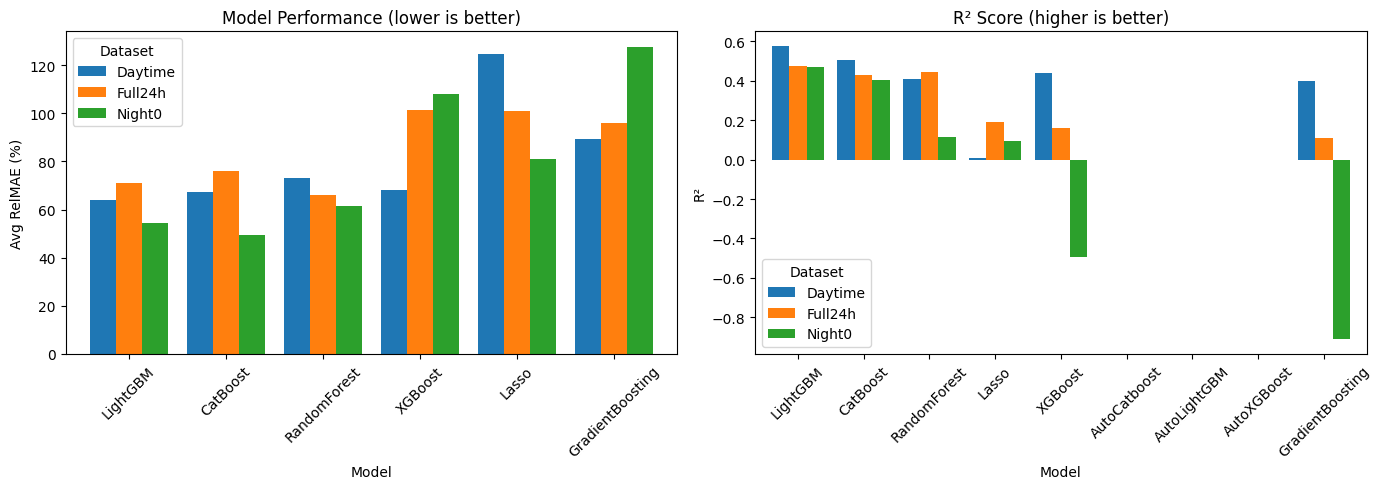

In [25]:
if len(results_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # RelMAE bar chart
    pivot = results_df.pivot_table(index='Model', columns='Dataset', values='AvgRelMAE')
    pivot = pivot.loc[pivot.mean(axis=1).sort_values().index]
    pivot.plot(kind='bar', ax=axes[0], width=0.8)
    axes[0].set_ylabel('Avg RelMAE (%)')
    axes[0].set_title('Model Performance (lower is better)')
    axes[0].legend(title='Dataset')
    axes[0].tick_params(axis='x', rotation=45)
    
    # R2 bar chart
    pivot_r2 = results_df.pivot_table(index='Model', columns='Dataset', values='R2')
    pivot_r2 = pivot_r2.loc[pivot_r2.mean(axis=1).sort_values(ascending=False).index]
    pivot_r2.plot(kind='bar', ax=axes[1], width=0.8)
    axes[1].set_ylabel('R²')
    axes[1].set_title('R² Score (higher is better)')
    axes[1].legend(title='Dataset')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(save_dir / 'comparison.png', dpi=150)
    plt.show()

In [26]:
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
for ds in datasets.keys():
    sub = results_df[results_df['Dataset'] == ds].dropna()
    if len(sub) == 0:
        continue
    best = sub.loc[sub['AvgRelMAE'].idxmin()]
    print(f"\n{ds}: Best = {best['Model']} ({best['Type']}) - RelMAE={best['AvgRelMAE']:.1f}%, R2={best['R2']:.3f}")


SUMMARY

Daytime: Best = LightGBM (Sklearn) - RelMAE=63.9%, R2=0.577

Full24h: Best = RandomForest (Sklearn) - RelMAE=65.9%, R2=0.445

Night0: Best = CatBoost (Sklearn) - RelMAE=49.4%, R2=0.403
